In [25]:
import torch
import torch.nn as nn
# !pip install easyfsl
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

class PrototypicalNetworks_dynamic_query(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks_dynamic_query, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images,
        support_labels,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        num_classes=len(list(support_labels))
        prototypes = []
        for class_label in range(num_classes):
            # print(type(support_images[class_label]),torch.cat(support_images[class_label].shape)
            support_images_eachclass=(support_images[class_label])
            # print("kk", support_images_eachclass.shape)
            class_features = self.backbone(support_images_eachclass.to(device))  # Select features for the current class
            class_prototype = class_features.mean(dim=0)  # Compute the mean along the batch dimension
            prototypes.append(class_prototype)
        prototypes = torch.stack(prototypes)


        distances=[]
        for each_query_class in query_images:

          query_features = self.backbone(each_query_class)

          # Compute the distance between query features and prototypes
          distance = torch.cdist(query_features, prototypes)
          distances.append(-distance)

        # print(distances.shape)

        return distances


In [26]:
root_path = '/home/asufian/Desktop/output_olchiki/code/asamese'

In [27]:
import os
import random
from collections import defaultdict
from PIL import Image, ImageOps
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PrototypicalOmniglotDataset(Dataset):
    def __init__(self, root, num_classes=1623, n_shot=5, n_query=10, transform=None):
        self.root = root
        self.num_classes = num_classes
        self.n_shot = n_shot
        self.n_query = n_query
        self.transform = transform
        self.samples_by_label = defaultdict(list)
        self.all_imgs = {}
        self.classes = []

        # Common image file extensions
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp']

        # Organize data into classes and image paths
        for alphabet in os.listdir(self.root):
            alphabet_path = os.path.join(self.root, alphabet)
            if not os.path.isdir(alphabet_path):
                continue

            for char_class in os.listdir(alphabet_path):
                char_class_path = os.path.join(alphabet_path, char_class)

                # Skip if the entry is not a directory
                if not os.path.isdir(char_class_path):
                    continue

                all_images = []
                for img_name in sorted(os.listdir(char_class_path)):
                    img_path = os.path.join(char_class_path, img_name)

                    # Check if it's a file with a recognized image extension
                    if os.path.isfile(img_path) and any(img_name.lower().endswith(ext) for ext in image_extensions):
                        all_images.append(img_path)

                if all_images:
                    char_class_name = f"{alphabet}_{char_class}"
                    self.samples_by_label[char_class_name] = list(range(len(all_images)))
                    self.all_imgs[char_class_name] = all_images
                    self.classes.append(char_class_name)
                    # print(char_class_name)

    def transform_image(self, raw_img):
        img = raw_img#ImageOps.invert(raw_img)
        if self.transform is not None:
            # print(self.transform)
            img = self.transform(img)
        # print(img.shape)
        return img

    def __getitem__(self, selected_classes,selected_supports):#
        # selected_classes = random.sample(self.classes, self.num_classes)
        class_indices = [self.samples_by_label[each_cls] for each_cls in selected_classes]
        # print("selected_classes: ",selected_classes)
        support_set = []
        query_set = []
        label_id = 0
        qs=[]
        ko=0
        ghj=[]
        for idx_set in class_indices:
            # Creating support set
            selected_support =selected_supports[ko]# random.sample(idx_set, self.n_shot)
            ko=ko+1
            ghj.append(selected_support)
            # print("selected_support images: ", ghj)
            support_images = [self.transform_image(Image.open(self.all_imgs[selected_classes[label_id]][each]).convert('L')) for each in selected_support]

            # Creating query set
            selected_query = [item for item in idx_set if item not in selected_support]
            query_images = [self.transform_image(Image.open(self.all_imgs[selected_classes[label_id]][each]).convert('L')) for each in selected_query]
            support_set.append((support_images, [label_id for _ in range(self.n_shot)]))
            # print("aaaaaaaaaa",label_id)
            query_set.append((query_images,  [label_id for _ in range(len(selected_query))]))

            label_id += 1
            # qs= [item for item in a for _ in range(self.n_query)]
        return support_set, query_set

    def __len__(self):
        return 10

# Set up the transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
])

# Set up the SiameseOmniglotDataset
# Training == evaluation
# root_path = './assamese'
num_classes = 5  # Set the desired number of classes per episode
n_shot = 5
n_query = 10

PrototypicalOmniglotDatasetLoader = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)


In [28]:
import torch
import torch.nn as nn

class PrototypicalNetworks_dynamic_query(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks_dynamic_query, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images,
        support_labels,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        num_classes=len(list(support_labels))
        prototypes = []
        for class_label in range(num_classes):
            # print(type(support_images[class_label]),torch.cat(support_images[class_label].shape)
            support_images_eachclass=(support_images[class_label])
            # print("kk", support_images_eachclass.shape)
            class_features = self.backbone(support_images_eachclass.to(device))  # Select features for the current class
            class_prototype = class_features.mean(dim=0)  # Compute the mean along the batch dimension
            prototypes.append(class_prototype)
        prototypes = torch.stack(prototypes)


        distances=[]
        for each_query_class in query_images:

          query_features = self.backbone(each_query_class)

          # Compute the distance between query features and prototypes
          distance = torch.cdist(query_features, prototypes)
          distances.append(-distance)

        # print(distances.shape)

        return distances


In [29]:
class PrototypicalNetworks33(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks33, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images,
        support_labels,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        num_classes = len(support_labels)
        prototypes = []
        for class_label in range(num_classes):
            support_images_eachclass = support_images[class_label]
            class_features = torch.stack([self.backbone(each.unsqueeze(0)) for each in support_images_eachclass])
            prototype_bymean = class_features.mean(dim=0)
            # print(prototype_bymean.shape)
            prototypes.append(prototype_bymean)

        query_features = torch.stack([self.backbone(each.unsqueeze(0)) for each in query_images])
        # print(query_features.shape,query_features[0].shape,torch.stack(prototypes).shape,torch.stack(prototypes)[0].shape)
        # distances = -torch.cdist(query_features, torch.stack(prototypes))
        distances = []  # Initialize list to store distances
        prototypes=torch.stack(prototypes)
        for each_query_feature in query_features:
            d = torch.cdist(prototypes, each_query_feature)  # Compute distances
            distances.append(d.squeeze())  # Remove singleton dimension and store
            # print(d.shape)  # Output: [5, 1], shape of each distance matrix

        distances = torch.stack(distances)

        return -distances


In [31]:
import pandas as pd
import os
import csv
def save_in_csv(cls,flnm,conf_matrix, acciuracy,precision_overall, recall_overall, f_betas):
  with open(flnm, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      headers=['Accuracy', 'Precision', 'Recall']
      beta=-5
      values=[]
      values.append(acciuracy)
      values.append(precision_overall)
      values.append(recall_overall)
      for each in f_betas:
              headers.append('F-betas (' +str(beta)+' )')
              beta=beta+1
              values.append(each)

    # Write confusion matrix
      writer.writerow(['used Class:'])
      writer.writerows([cls])
      writer.writerow([])
      writer.writerow([])
      writer.writerow(['Confusion Matrix'])
      writer.writerows(conf_matrix)
      writer.writerow([])
      writer.writerow([])  # Add an empty row for separation

      # Write metrics

      writer.writerow(headers)
      writer.writerow(values)


  # print("Metrics have been written to 'metrics.csv' file.")
def save_in_text_file(msg,cls, flnm, conf_matrix, accuracy, precision_overall, recall_overall, f_betas):
    with open(flnm, 'a') as textfile:
        textfile.write(str("\n\n\n                                 "+msg))
        textfile.write("\n\n\n")
        textfile.write("used Class:\n")
        textfile.write(str(cls) + "\n\n")

        textfile.write("Confusion Matrix:\n")
        for row in conf_matrix:
            textfile.write(' '.join([str(elem) for elem in row]) + "\n")
        textfile.write("\n")

        textfile.write("Metrics:\n")
        textfile.write("Accuracy: {}\n".format(accuracy))
        textfile.write("Precision: {}\n".format(precision_overall))
        textfile.write("Recall: {}\n".format(recall_overall))

        beta = -5
        for f_beta in f_betas:
            textfile.write("F-betas ({}): {}\n".format(beta, f_beta))
            beta += 1

    # print("Metrics have been written to '{}' file.".format(flnm))

def save_in_excel_final(msg, cls, flnm, conf_matrix, accuracy, precision_overall, recall_overall):
    data = {
        "Used Class": [cls],
        "Used support images idx": [msg],
        "Confusion Matrix": [conf_matrix],
        "Accuracy": [accuracy],
        "Precision": [precision_overall],
        "Recall": [recall_overall]
    }
    # for i, f_beta in enumerate(f_betas):
    #     data[f"F-beta ({i - 5})"] = [f_beta]

    df_new = pd.DataFrame(data)
    df_new = df_new.transpose()  # Transpose the DataFrame

    if os.path.exists(flnm):
        df_existing = pd.read_excel(flnm, index_col=0)  # Read existing file
        df_combined = pd.concat([df_existing, df_new], axis=1)  # Concatenate along columns
        df_combined.to_excel(flnm)  # Write to Excel
    else:
        df_new.to_excel(flnm)  # Write new DataFrame to Excel

    # print("Metrics have been written to '{}' file.".format(flnm))


In [32]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch
import torch.nn as nn
import torch.hub

# Define a modified version of DenseNet169 with dropout after each convolutional layer
class DenseNet169WithDropout(nn.Module):
    def __init__(self,modell, pretrained=False, dr=0.4):
        super(DenseNet169WithDropout, self).__init__()
        self.densenet169 = torch.hub.load('pytorch/vision:v0.10.0', modell, pretrained=pretrained)
        self.dropout = nn.Dropout(p=dr)  # Dropout with probability 0.5

        # Modify each dense block to include dropout after each convolutional layer
        for name, module in self.densenet169.features.named_children():
            if isinstance(module, nn.Sequential):
                for sub_name, sub_module in module.named_children():
                    if isinstance(sub_module, nn.Conv2d):
                        setattr(module, sub_name, nn.Sequential(sub_module, self.dropout))

    def forward(self, x):
        return self.densenet169(x)

# Instantiate the modified DenseNet169 model with dropout
# convolutional_network_with_dropout = DenseNet169WithDropout(modell='resnet18',pretrained=False,dr=0.4)

# Example usage:
# output = convolutional_network_with_dropout(input_tensor)

class ResNet18WithDropout(nn.Module):
    def __init__(self, pretrained=False, dr=0.4):
        super(ResNet18WithDropout, self).__init__()
        self.resnet18 = models.resnet18(pretrained=pretrained)
        self.dropout = nn.Dropout(p=dr)

        # Modify each residual block to include dropout after each convolutional layer
        for name, module in self.resnet18.named_children():
            if isinstance(module, nn.Sequential):
                for sub_name, sub_module in module.named_children():
                    if isinstance(sub_module, nn.Conv2d):
                        setattr(module, sub_name, nn.Sequential(sub_module, self.dropout))

    def forward(self, x):
        return self.resnet18(x)

# Instantiate the modified ResNet18 model with dropout
# convolutional_network_with_dropout = ResNet18WithDropout(pretrained=False, dr=0.4)


In [33]:
clss_5=[
    ['assamese1_BXG', 'assamese1_NAA', 'assamese1_KHYA', 'assamese1_CBN', 'assamese1_DHA'],
      ['assamese1_DRA', 'assamese1_OI', 'assamese1_CA', 'assamese1_JHA', 'assamese1_MA'],
     ['assamese1_KHA', 'assamese1_CARI', 'assamese1_CA', 'assamese1_CAY', 'assamese1_TA'],
    ['assamese1_CA', 'assamese1_MNA', 'assamese1_TR', 'assamese1_CAY', 'assamese1_KHYA'],
    ['assamese1_NA', 'assamese1_KTA', 'assamese1_MDA', 'assamese1_MDHA', 'assamese1_MTA'],
     ['assamese1_OI', 'assamese1_MXA', 'assamese1_ATH', 'assamese1_DA', 'assamese1_BHA'],
     ['assamese1_PAC', 'assamese1_ANSR', 'assamese1_E', 'assamese1_TR', 'assamese1_BHA'],
     ['assamese1_CA', 'assamese1_CARI', 'assamese1_A', 'assamese1_AYA', 'assamese1_NIYA'],
    ['assamese1_MDHA', 'assamese1_BHA', 'assamese1_MTA', 'assamese1_EK', 'assamese1_GHA'],
    ['assamese1_ATH', 'assamese1_CAY', 'assamese1_BHA', 'assamese1_TXA', 'assamese1_MDHA'],
    ['assamese1_OU', 'assamese1_AE', 'assamese1_BXG', 'assamese1_JA', 'assamese1_MDHA'],
    ['assamese1_MXA', 'assamese1_ANSR', 'assamese1_CA', 'assamese1_MTA', 'assamese1_THA'],
     ['assamese1_HA', 'assamese1_KHA', 'assamese1_OI', 'assamese1_NG', 'assamese1_MNA'],
    ['assamese1_NG', 'assamese1_MDHA', 'assamese1_KA', 'assamese1_THA', 'assamese1_BA'],
    ['assamese1_UU', 'assamese1_EK', 'assamese1_SUNYA', 'assamese1_CA', 'assamese1_TR'],

     ]

clss_support_imagesss_1_shot=[
    [[35], [11], [7], [4], [12]],
    [[1], [15], [2], [23], [43]],
    [[20], [44], [5], [15], [37]],
    [[37], [33], [44], [6], [17]],
    [[27], [33], [9], [40], [40]],
    [[22], [6], [18], [37], [7]],
    [[9], [40], [34], [8], [1]],
    [[9], [5], [10], [2], [9]],
    [[17], [10], [27], [39], [6]],
    [[28], [38], [38], [26], [43]],
    [[35], [2], [12], [27], [38]],
    [[12], [11], [2], [3], [19]],
     [[39], [1], [2], [2], [25]],
    [[19], [0], [10], [19], [3]],
    [[37], [1], [1], [7], [9]]







]


clss_support_imagesss_5_shot=[[[35, 8, 42, 10, 39], [11, 28, 8, 10, 26], [7, 10, 6, 21, 36], [4, 9, 24, 11, 1], [12, 34, 2, 40, 18]], [[1, 8, 13, 24, 7], [15, 42, 34, 19, 13], [2, 8, 1, 19, 40], [23, 14, 17, 11, 28], [43, 25, 2, 13, 21]], [[20, 30, 9, 22, 13], [44, 21, 13, 20, 36], [5, 20, 15, 41, 19], [15, 40, 33, 25, 14], [37, 15, 27, 7, 41]], [[37, 31, 39, 42, 15], [33, 15, 34, 19, 3], [44, 0, 24, 25, 26], [6, 17, 8, 15, 9], [17, 13, 15, 5, 44]], [[27, 17, 4, 12, 42], [33, 0, 30, 31, 15], [9, 11, 39, 41, 34], [40, 43, 9, 32, 41], [40, 3, 18, 38, 4]], [[22, 8, 10, 25, 15], [6, 28, 5, 3, 31], [18, 32, 23, 38, 4], [37, 1, 24, 13, 30], [7, 11, 38, 32, 5]], [[9, 28, 6, 5, 18], [40, 29, 12, 5, 39], [34, 22, 25, 23, 8], [8, 32, 41, 2, 30], [1, 18, 41, 39, 40]], [[9, 24, 28, 5, 14], [5, 28, 36, 4, 27], [10, 24, 17, 12, 14], [2, 17, 20, 9, 7], [9, 29, 3, 28, 37]], [[17, 6, 31, 39, 36], [10, 34, 8, 37, 14], [27, 38, 14, 15, 28], [39, 5, 38, 4, 2], [6, 26, 27, 31, 43]], [[28, 12, 25, 38, 1], [38, 15, 37, 43, 29], [38, 29, 2, 4, 11], [26, 4, 27, 13, 14], [43, 20, 11, 38, 16]], [[35, 18, 1, 11, 17], [2, 18, 25, 1, 12], [12, 25, 18, 24, 40], [27, 16, 30, 25, 35], [38, 39, 9, 22, 24]], [[12, 2, 27, 4, 17], [11, 16, 36, 20, 8], [2, 28, 17, 32, 26], [3, 20, 28, 22, 4], [19, 1, 9, 0, 11]], [[39, 16, 19, 32, 34], [1, 9, 20, 0, 8], [2, 22, 20, 43, 21], [2, 13, 44, 21, 19], [25, 1, 41, 3, 33]], [[19, 40, 42, 43, 27], [0, 1, 30, 12, 40], [10, 43, 15, 2, 20], [19, 43, 38, 16, 33], [3, 30, 17, 1, 41]], [[37, 11, 25, 28, 35], [1, 3, 35, 4, 33], [1, 31, 25, 32, 13], [7, 3, 10, 11, 35], [9, 19, 1, 22, 8]]]

clss_support_imagesss_10_shot=[[[35, 8, 42, 10, 39, 30, 15, 11, 44, 7], [11, 28, 8, 10, 26, 16, 12, 7, 44, 37], [7, 10, 6, 21, 36, 24, 22, 38, 9, 39], [4, 9, 24, 11, 1, 32, 13, 28, 30, 17], [12, 34, 2, 40, 18, 38, 1, 14, 22, 36]], [[1, 8, 13, 24, 7, 12, 44, 29, 22, 23], [15, 42, 34, 19, 13, 30, 0, 23, 1, 9], [2, 8, 1, 19, 40, 44, 32, 26, 27, 9], [23, 14, 17, 11, 28, 16, 24, 35, 6, 34], [43, 25, 2, 13, 21, 17, 20, 38, 24, 35]], [[20, 30, 9, 22, 13, 36, 18, 21, 3, 37], [44, 21, 13, 20, 36, 33, 22, 0, 34, 12], [5, 20, 15, 41, 19, 10, 44, 12, 28, 26], [15, 40, 33, 25, 14, 44, 19, 32, 24, 6], [37, 15, 27, 7, 41, 9, 43, 33, 35, 23]], [[37, 31, 39, 42, 15, 11, 25, 1, 36, 21], [33, 15, 34, 19, 3, 28, 25, 29, 40, 37], [44, 0, 24, 25, 26, 6, 4, 19, 12, 14], [6, 17, 8, 15, 9, 25, 27, 29, 7, 0], [17, 13, 15, 5, 44, 33, 8, 6, 34, 31]], [[27, 17, 4, 12, 42, 11, 6, 13, 33, 3], [33, 0, 30, 31, 15, 34, 17, 14, 36, 20], [9, 11, 39, 41, 34, 10, 8, 15, 31, 4], [40, 43, 9, 32, 41, 14, 35, 10, 20, 23], [40, 3, 18, 38, 4, 41, 22, 29, 15, 27]], [[22, 8, 10, 25, 15, 14, 29, 2, 41, 24], [6, 28, 5, 3, 31, 2, 32, 40, 16, 13], [18, 32, 23, 38, 4, 2, 34, 22, 16, 36], [37, 1, 24, 13, 30, 5, 36, 27, 39, 35], [7, 11, 38, 32, 5, 15, 8, 41, 10, 2]], [[9, 28, 6, 5, 18, 44, 3, 8, 2, 34], [40, 29, 12, 5, 39, 18, 9, 43, 19, 28], [34, 22, 25, 23, 8, 18, 17, 24, 19, 6], [8, 32, 41, 2, 30, 5, 9, 17, 44, 1], [1, 18, 41, 39, 40, 7, 0, 25, 24, 15]], [[9, 24, 28, 5, 14, 16, 25, 22, 32, 37], [5, 28, 36, 4, 27, 18, 32, 2, 10, 31], [10, 24, 17, 12, 14, 41, 4, 32, 42, 37], [2, 17, 20, 9, 7, 31, 44, 38, 1, 22], [9, 29, 3, 28, 37, 17, 41, 13, 21, 44]], [[17, 6, 31, 39, 36, 8, 11, 24, 10, 7], [10, 34, 8, 37, 14, 16, 29, 44, 31, 33], [27, 38, 14, 15, 28, 23, 7, 42, 35, 41], [39, 5, 38, 4, 2, 42, 6, 22, 21, 9], [6, 26, 27, 31, 43, 41, 10, 12, 36, 32]], [[28, 12, 25, 38, 1, 41, 15, 42, 33, 20], [38, 15, 37, 43, 29, 44, 41, 39, 12, 21], [38, 29, 2, 4, 11, 43, 33, 24, 7, 21], [26, 4, 27, 13, 14, 16, 28, 0, 3, 36], [43, 20, 11, 38, 16, 14, 27, 13, 19, 0]], [[35, 18, 1, 11, 17, 19, 31, 16, 7, 15], [2, 18, 25, 1, 12, 16, 9, 23, 11, 44], [12, 25, 18, 24, 40, 35, 17, 44, 28, 22], [27, 16, 30, 25, 35, 18, 26, 42, 33, 40], [38, 39, 9, 22, 24, 18, 29, 21, 1, 7]], [[12, 2, 27, 4, 17, 42, 37, 3, 18, 10], [11, 16, 36, 20, 8, 4, 42, 28, 44, 7], [2, 28, 17, 32, 26, 3, 37, 16, 10, 14], [3, 20, 28, 22, 4, 43, 17, 9, 0, 11], [19, 1, 9, 0, 11, 7, 27, 15, 18, 6]], [[39, 16, 19, 32, 34, 31, 13, 4, 37, 6], [1, 9, 20, 0, 8, 29, 4, 27, 26, 13], [2, 22, 20, 43, 21, 4, 15, 13, 14, 10], [2, 13, 44, 21, 19, 5, 14, 23, 43, 26], [25, 1, 41, 3, 33, 16, 9, 37, 7, 30]], [[19, 40, 42, 43, 27, 30, 3, 10, 21, 28], [0, 1, 30, 12, 40, 33, 11, 22, 44, 27], [10, 43, 15, 2, 20, 32, 14, 30, 11, 42], [19, 43, 38, 16, 33, 17, 35, 14, 10, 5], [3, 30, 17, 1, 41, 29, 40, 43, 8, 31]], [[37, 11, 25, 28, 35, 13, 5, 9, 31, 6], [1, 3, 35, 4, 33, 8, 41, 26, 12, 37], [1, 31, 25, 32, 13, 14, 22, 9, 26, 19], [7, 3, 10, 11, 35, 13, 41, 26, 43, 20], [9, 19, 1, 22, 8, 17, 40, 3, 32, 14]]]


In [34]:
!ls '/home/asufian/Desktop/output_olchiki/code/asamese_sce/denssecondary/model_1'

model_B_olchiki_1-shot_dens_14.pth


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/modelrdnet.pth',map_location=torch.device('cpu')))


convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own_1_shot = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own_1_shot.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/asamese_sce/denssecondary/model_1/model_B_olchiki_1-shot_dens.pth',map_location=torch.device('cpu')))

torch.save(model_own_1_shot.state_dict(), 'model_mu_path.pt')
torch.save(model_own.state_dict(), 'model_own_path.pt')

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


In [36]:
# !ls '/home/asufian/Desktop/output_olchiki/'

In [37]:
criterion = nn.CrossEntropyLoss()

In [38]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import numpy as np
import pandas as pd
# root_path = '/content/assamese'
num_classes = 5
n_shot = 1
n_query = 14
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformt_ugh = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.RandomResizedCrop(64),  # Randomly crop the image and resize to 224x224
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    # transforms.RandomAffine(degrees=0, translate=(0, 0), scale=(0.9, 1.1), shear=0),  # Random zoom (scaling)
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image with ImageNet statistics
])

print(f"Generated random values - num_classes: {num_classes}, n_shot: {n_shot}, n_query: {n_query}")

test_loader = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=20, transform=transformt_ugh)

def evaluate2(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlac=0
    precision=0
    recall=0
    
    with torch.no_grad():
        for episode in range(len(clss_5)):
            support_set, query_set = data_loader.__getitem__(clss_5[tlv_cls] , clss_support_imagesss_1_shot[tlv_cls])

            # msg="\n\n       Way: "+str(len(clss_5[tlv_cls]))+"  Shot: "+str(len(clss_support_imagesss_1_shot[tlv_cls][0]))    +" \n\n"
            # msg=str(clss_5[tlv_cls])
            clssa=str(clss_5[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_1_shot[tlv_cls])
            str(clss_5[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            precision_overall, recall_overall, f1ss= calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)
            precision=precision+precision_overall
            recall=recall+recall_overall
    print("---------------------->",ttlac/ttla,precision/ttla ,recall/ttla)
# %%%%%%%%%%%%%%%%%%%


pp='/home/asufian/Desktop/output_olchiki/faltu'






Generated random values - num_classes: 5, n_shot: 1, n_query: 14


In [39]:
import numpy as np

conf_matrix = np.array([[100, 0, 0, 0, 0],
                        [0, 100, 0, 0, 0],
                        [0, 0, 100, 0, 0],
                        [0, 0, 0, 100, 0],
                        [0, 0, 0, 0, 100]])

def calculate_metrics_get_per(msg, conf_matrix,acciuracy, cls, flnm):
    if conf_matrix.size == 0:
        raise ValueError("Confusion matrix is empty!")

    metrics = []
    for i in range(conf_matrix.shape[0]):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics.append((precision, recall, f1))

    # Compute overall scores
    precision_overall = np.mean([m[0] for m in metrics])
    recall_overall = np.mean([m[1] for m in metrics])
    f1_overall = np.mean([m[2] for m in metrics])

    # Compute overall accuracy
    total_samples = np.sum(conf_matrix)
    correct_predictions = np.sum(np.diag(conf_matrix))
    accuracy_overall = correct_predictions / total_samples if total_samples > 0 else 0
    # print(accuracy_overall)

    # Save results (Assuming these functions exist)
    save_in_excel_final(msg, cls, flnm + ".xlsx", conf_matrix, accuracy_overall, precision_overall, recall_overall)
    # save_in_text_file(msg, cls, flnm + ".txt", conf_matrix, accuracy_overall, precision_overall, recall_overall, f_betas)

    return precision_overall, recall_overall, f1_overall


# precision, recall, f_beta = calculate_metrics(conf_matrix)
# print(f'Overall Metrics for beta={beta}:')
# print(f'Overall Precision: {precision:.4f}')
# print(f'Overall Recall: {recall:.4f}')
# print(f'Overall F-beta ({f_beta}): ')
# print()


In [40]:


def evaluate2(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlal=[]
    ttlac=0
    precision=[]
    recall=[]
    
    with torch.no_grad():
        for episode in range(len(clss_5)):
            support_set, query_set = data_loader.__getitem__(clss_5[tlv_cls] , clss_support_imagesss_1_shot[tlv_cls])

           
            clssa=str(clss_5[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_1_shot[tlv_cls])
            str(clss_5[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            ttlal.append(accuracy)
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            precision_overall, recall_overall, f1ss= calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)
            precision.append(precision_overall)
            recall.append(recall_overall)
    print(f"---Accu-----pre----rec---------> {np.mean(ttlal):.4f} ± {np.std(ttlal, ddof=1):.4f}  "
      f"{np.mean(precision):.4f} ± {np.std(precision, ddof=1):.4f}  "
      f"{np.mean(recall):.4f} ± {np.std(recall, ddof=1):.4f}")

    # print("---Accu-----pre----rec---------->",np.mean(ttlal),'±',np.std(ttlal, ddof=1), np.mean(precision),'±',np.std(precision, ddof=1),np.mean(precision),'±',np.std(precision, ddof=1),)
# %%%%%%

def evaluate3(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlac=0
    with torch.no_grad():
        for episode in range(len(clss_5)):
            support_set, query_set = data_loader.__getitem__(clss_5[tlv_cls] , clss_support_imagesss_1_shot[tlv_cls])

            
            clssa=str(clss_5[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_1_shot[tlv_cls])
            str(clss_5[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            # confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            # calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)

    print("---------------------->",ttlac/ttla)
    return ttlac/ttla

In [41]:
def update_model_weights2(model_a, model_b, conv_ratio=0.8, fc_ratio=0.8, bias_ratio=0.8):
    """Updates model_a's weights using a weighted combination of model_a and model_b."""
    for name, param in model_a.named_parameters():
        if name in model_b.state_dict():
            weight_b = model_b.state_dict()[name]
            
            if 'weight' in name:
                # Separate conditions for convolutional and fully connected layers
                if 'conv' in name:  # Convolutional layer weights
                    # print('conv')
                    param.data = conv_ratio * weight_b + (1 - conv_ratio) * param.data
                elif 'fc' in name or 'linear' in name:  # Fully connected layer weights
                    # print('fc')
                    param.data = fc_ratio * weight_b + (1 - fc_ratio) * param.data
            
            elif 'bias' in name:
                param.data = bias_ratio * weight_b + (1 - bias_ratio) * param.data

In [42]:


import numpy as np
import torch
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to get model accuracy
def get_model_accuracy(b_a_r, c_a_r, f_a_r):
    try:
        print(f"Testing b_a_r = {b_a_r:.4f}, c_a_r = {c_a_r:.4f}, f_a_r = {f_a_r:.4f}")  # Debugging Output

        convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
        convolutional_network_with_dropout.fc = nn.Flatten()
        xyz = convolutional_network_with_dropout
        M3 = PrototypicalNetworks_dynamic_query(xyz).to(device)
        M3.load_state_dict(torch.load('model_own_path.pt'))

        # Load Model M2 (Reference)
        convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
        convolutional_network_with_dropout.fc = nn.Flatten()
        xyz2 = convolutional_network_with_dropout
        M2 = PrototypicalNetworks_dynamic_query(xyz2).to(device)
        M2.load_state_dict(torch.load('model_mu_path.pt'))

        # Apply bias adaptation to M3 using M2
        update_model_weights2(M3, M2, conv_ratio=c_a_r, fc_ratio=f_a_r, bias_ratio=b_a_r)
        
        # Evaluate accuracy
        accuracy = evaluate3('/_olchiki_5-wau-1-shot_matchine_unlearning_own', test_loader, M3, criterion)
        
        if accuracy is None:
            raise ValueError("Accuracy computation failed. Returning worst case.")

        return accuracy  # Ensure accuracy is valid
    except Exception as e:
        print(f"Error encountered: {e}. Assigning worst-case accuracy of 0.")
        return 0.0  # Assign lowest accuracy to prevent optimization failures


In [43]:
root_path

'/home/asufian/Desktop/output_olchiki/code/asamese'

In [44]:
criterion = nn.CrossEntropyLoss()


In [21]:
# !mkdir '/home/asufian/Desktop/output_assamese/Densnet_resluts/amul'

In [22]:

# Define the search space for b_a_r, c_a_r, and f_a_r
search_space = [
    Real(0.0, 1.0, name="b_a_r"),
    Real(0.0, 1.0, name="c_a_r"),
    Real(0.0, 1.0, name="f_a_r")
]

# Define the objective function for Bayesian Optimization
@use_named_args(search_space)
def objective(b_a_r, c_a_r, f_a_r):
    """
    Objective function to optimize the adaptation ratios.
    It applies adaptation, evaluates the model, and returns the negative accuracy.
    """
    accuracy = get_model_accuracy(b_a_r, c_a_r, f_a_r)
    print(f"Evaluated Accuracy: {accuracy:.4f}")  # Debugging Output
    
    return -accuracy  # We minimize, so return negative accuracy

# Perform Bayesian Optimization with additional settings
search_iteration=50
res = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=search_iteration,               # Number of evaluations
    n_initial_points=5,       # Initial random explorations before GP starts
    acq_func="EI",            # Acquisition function: Expected Improvement
    random_state=42,          # Ensure reproducibility
    n_jobs=-1,                # Parallel execution for faster optimization
)

# Extract optimal results
optimal_b_a_r, optimal_c_a_r, optimal_f_a_r = res.x
best_accuracy = -res.fun

print(f"\n✅ Optimal Values:")
print(f"   - b_a_r: {optimal_b_a_r:.4f}")
print(f"   - c_a_r: {optimal_c_a_r:.4f}")
print(f"   - f_a_r: {optimal_f_a_r:.4f}")
print(f"📈 Highest Accuracy Achieved: {best_accuracy:.4f}")




Testing b_a_r = 0.7965, c_a_r = 0.1834, f_a_r = 0.7797


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5457564738064334
Evaluated Accuracy: 0.5458
Testing b_a_r = 0.5969, c_a_r = 0.4458, f_a_r = 0.1000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5036694159095448
Evaluated Accuracy: 0.5037
Testing b_a_r = 0.4592, c_a_r = 0.3337, f_a_r = 0.1429


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5897166232460351
Evaluated Accuracy: 0.5897
Testing b_a_r = 0.6509, c_a_r = 0.0564, f_a_r = 0.7220


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4748512459874264
Evaluated Accuracy: 0.4749
Testing b_a_r = 0.9386, c_a_r = 0.0008, f_a_r = 0.9922


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.47059924854445406
Evaluated Accuracy: 0.4706
Testing b_a_r = 0.1219, c_a_r = 0.2840, f_a_r = 0.5669


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6048682260527547
Evaluated Accuracy: 0.6049
Testing b_a_r = 0.2213, c_a_r = 1.0000, f_a_r = 0.9428


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.48001638526215484
Evaluated Accuracy: 0.4800
Testing b_a_r = 0.0062, c_a_r = 0.7360, f_a_r = 0.0020


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.35638388471587507
Evaluated Accuracy: 0.3564
Testing b_a_r = 0.9804, c_a_r = 0.2521, f_a_r = 0.1407


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5921230654026787
Evaluated Accuracy: 0.5921
Testing b_a_r = 0.9970, c_a_r = 0.2973, f_a_r = 0.4347


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6075858754907909
Evaluated Accuracy: 0.6076
Testing b_a_r = 0.9627, c_a_r = 0.8911, f_a_r = 0.3195


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4076345867401468
Evaluated Accuracy: 0.4076
Testing b_a_r = 0.8648, c_a_r = 0.5719, f_a_r = 0.8242


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.41064443480237206
Evaluated Accuracy: 0.4106
Testing b_a_r = 0.9019, c_a_r = 0.2935, f_a_r = 0.9831


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6060707114534674
Evaluated Accuracy: 0.6061
Testing b_a_r = 0.0581, c_a_r = 0.3022, f_a_r = 0.0463


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6066809356817415
Evaluated Accuracy: 0.6067
Testing b_a_r = 0.9532, c_a_r = 0.3861, f_a_r = 0.9301


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5494381364002637
Evaluated Accuracy: 0.5494
Testing b_a_r = 0.9750, c_a_r = 0.2818, f_a_r = 0.0643


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6021368397919566
Evaluated Accuracy: 0.6021
Testing b_a_r = 0.0206, c_a_r = 0.2926, f_a_r = 0.9398


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.608500476155593
Evaluated Accuracy: 0.6085
Testing b_a_r = 0.0140, c_a_r = 0.2849, f_a_r = 0.9889


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6054742866588152
Evaluated Accuracy: 0.6055
Testing b_a_r = 0.9137, c_a_r = 0.3120, f_a_r = 0.9467


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6006175246545916
Evaluated Accuracy: 0.6006
Testing b_a_r = 0.0386, c_a_r = 0.2853, f_a_r = 0.0140


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6051712563557848
Evaluated Accuracy: 0.6052
Testing b_a_r = 0.0354, c_a_r = 0.2659, f_a_r = 0.9276


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6051657966887621
Evaluated Accuracy: 0.6052
Testing b_a_r = 0.0200, c_a_r = 0.2915, f_a_r = 0.0062


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6085018473334348
Evaluated Accuracy: 0.6085
Testing b_a_r = 0.0186, c_a_r = 0.3051, f_a_r = 0.9503


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6066740422260164
Evaluated Accuracy: 0.6067
Testing b_a_r = 0.0031, c_a_r = 0.2708, f_a_r = 0.9975


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6081905899633538
Evaluated Accuracy: 0.6082
Testing b_a_r = 0.0058, c_a_r = 0.2980, f_a_r = 0.9490


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6081988420747487
Evaluated Accuracy: 0.6082
Testing b_a_r = 0.9701, c_a_r = 0.2933, f_a_r = 0.9824


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6063737417564976
Evaluated Accuracy: 0.6064
Testing b_a_r = 0.0500, c_a_r = 0.2956, f_a_r = 0.0248


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6082002132525903
Evaluated Accuracy: 0.6082
Testing b_a_r = 0.9962, c_a_r = 0.2894, f_a_r = 0.9771


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6057704485504646
Evaluated Accuracy: 0.6058
Testing b_a_r = 0.0186, c_a_r = 0.2501, f_a_r = 0.9191


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5930349237117972
Evaluated Accuracy: 0.5930
Testing b_a_r = 0.0273, c_a_r = 0.3082, f_a_r = 0.9889


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6057704610726369
Evaluated Accuracy: 0.6058
Testing b_a_r = 0.9781, c_a_r = 0.2914, f_a_r = 0.0071


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6054632796695649
Evaluated Accuracy: 0.6055
Testing b_a_r = 0.0073, c_a_r = 0.2814, f_a_r = 0.0562


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6054701731252901
Evaluated Accuracy: 0.6055
Testing b_a_r = 0.9766, c_a_r = 0.2768, f_a_r = 0.9890


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6006189459211216
Evaluated Accuracy: 0.6006
Testing b_a_r = 0.0206, c_a_r = 0.3037, f_a_r = 0.0283


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6054633172360812
Evaluated Accuracy: 0.6055
Testing b_a_r = 0.0002, c_a_r = 0.3142, f_a_r = 0.9162


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5966794768486953
Evaluated Accuracy: 0.5967
Testing b_a_r = 0.0136, c_a_r = 0.2834, f_a_r = 0.0165


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6060789760870341
Evaluated Accuracy: 0.6061
Testing b_a_r = 0.9916, c_a_r = 0.2858, f_a_r = 0.0125


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6021368272697845
Evaluated Accuracy: 0.6021
Testing b_a_r = 0.0147, c_a_r = 0.2828, f_a_r = 0.9490


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6060762337313506
Evaluated Accuracy: 0.6061
Testing b_a_r = 0.9783, c_a_r = 0.2944, f_a_r = 0.9892


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6057676936726092
Evaluated Accuracy: 0.6058
Testing b_a_r = 0.0274, c_a_r = 0.2333, f_a_r = 0.0509


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5896988229784361
Evaluated Accuracy: 0.5897
Testing b_a_r = 0.0076, c_a_r = 0.3036, f_a_r = 0.0210


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6057677187169532
Evaluated Accuracy: 0.6058
Testing b_a_r = 0.0094, c_a_r = 0.2736, f_a_r = 0.0171


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.606372408145172
Evaluated Accuracy: 0.6064
Testing b_a_r = 0.9554, c_a_r = 0.3189, f_a_r = 0.0138


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5951588281000046
Evaluated Accuracy: 0.5952
Testing b_a_r = 0.0019, c_a_r = 0.2858, f_a_r = 0.8857


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.605475657836657
Evaluated Accuracy: 0.6055
Testing b_a_r = 0.0380, c_a_r = 0.1230, f_a_r = 0.6885


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5021391313494455
Evaluated Accuracy: 0.5021
Testing b_a_r = 0.9993, c_a_r = 0.2741, f_a_r = 0.0960


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6024385114393173
Evaluated Accuracy: 0.6024
Testing b_a_r = 0.0246, c_a_r = 0.2731, f_a_r = 0.9627


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6069784687512326
Evaluated Accuracy: 0.6070
Testing b_a_r = 0.0125, c_a_r = 0.2955, f_a_r = 0.0144


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6081988295525765
Evaluated Accuracy: 0.6082
Testing b_a_r = 0.9715, c_a_r = 0.6498, f_a_r = 0.8477


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3821581149623051
Evaluated Accuracy: 0.3822
Testing b_a_r = 0.0196, c_a_r = 0.3149, f_a_r = 0.9835


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5987993177920656
Evaluated Accuracy: 0.5988

✅ Optimal Values:
   - b_a_r: 0.0200
   - c_a_r: 0.2915
   - f_a_r: 0.0062
📈 Highest Accuracy Achieved: 0.6085


In [23]:
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz = convolutional_network_with_dropout
M3 = PrototypicalNetworks_dynamic_query(xyz).to(device)
M3.load_state_dict(torch.load('model_own_path.pt'))
evaluate2('/home/asufian/Desktop/output_assamese/Densnet_resluts/base/5_w_1_s_f__ff', test_loader, M3, criterion)
# Load Model M2
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz2 = convolutional_network_with_dropout
M2 = PrototypicalNetworks_dynamic_query(xyz2).to(device)
M2.load_state_dict(torch.load('model_mu_path.pt'))
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/secondary/5_w_1_s_f__ff", test_loader, M2, criterion)
# Update Model M3's weights using a weighted combination of Model M3 and Model M2
update_model_weights2(M3, M2, conv_ratio= optimal_c_a_r , fc_ratio=optimal_f_a_r , bias_ratio=optimal_b_a_r)

# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/amul/5_w_1_s_f__ff", test_loader, M3, criterion)


# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
# evaluate3(pp+'/_olchiki_5-wau-1-shot_matchine_unlearning_own', test_loader, M3, criterion)

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.4727 ± 0.1013  0.5204 ± 0.0908  0.4727 ± 0.1013


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.4361 ± 0.1289  0.4700 ± 0.1229  0.4362 ± 0.1289
---Accu-----pre----rec---------> 0.6085 ± 0.1197  0.6499 ± 0.1077  0.6085 ± 0.1197


In [24]:
import pickle

# Save the optimization results to a file
with open('asse_5w-1s-dens.pkl', 'wb') as f:
    pickle.dump(res, f)

print("Optimization results saved to 'bayesian_optimization_results.pkl'")

Optimization results saved to 'bayesian_optimization_results.pkl'


In [21]:
!ls /home/asufian/Desktop/output_olchiki/code/olchiki/model_5/model_B_olchiki_1-shot_30.pth

model_B_olchiki_1-shot_20.pth  model_B_olchiki_1-shot_80.pth
model_B_olchiki_1-shot_30.pth  model_B_olchiki_1-shot_90.pth
model_B_olchiki_1-shot_50.pth


In [ ]:
########################  5   way    5  shot    #########################

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



!rm model_mu_path.pt
!rm model_own_path.pt

convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/modelrdnet_169.pth',map_location=torch.device('cpu')))


convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own_1_shot = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own_1_shot.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/asamese_sce/denssecondary/model_5/model_B_olchiki_5-shot_dens.pth',map_location=torch.device('cpu')))

torch.save(model_own_1_shot.state_dict(), 'model_mu_path.pt')
torch.save(model_own.state_dict(), 'model_own_path.pt')

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


In [57]:


def evaluate2(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlal=[]
    ttlac=0
    precision=[]
    recall=[]
    
    with torch.no_grad():
        for episode in range(len(clss_5)):
            support_set, query_set = data_loader.__getitem__(clss_5[tlv_cls] , clss_support_imagesss_5_shot[tlv_cls])

           
            clssa=str(clss_5[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_5_shot[tlv_cls])
            str(clss_5[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            ttlal.append(accuracy)
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            precision_overall, recall_overall, f1ss= calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)
            precision.append(precision_overall)
            recall.append(recall_overall)
    print(f"---Accu-----pre----rec---------> {np.mean(ttlal):.4f} ± {np.std(ttlal, ddof=1):.4f}  "
      f"{np.mean(precision):.4f} ± {np.std(precision, ddof=1):.4f}  "
      f"{np.mean(recall):.4f} ± {np.std(recall, ddof=1):.4f}")

    # print("---Accu-----pre----rec---------->",np.mean(ttlal),'±',np.std(ttlal, ddof=1), np.mean(precision),'±',np.std(precision, ddof=1),np.mean(precision),'±',np.std(precision, ddof=1),)
# %%%%%%

def evaluate3(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlac=0
    with torch.no_grad():
        for episode in range(len(clss_5)):
            support_set, query_set = data_loader.__getitem__(clss_5[tlv_cls] , clss_support_imagesss_5_shot[tlv_cls])

            
            clssa=str(clss_5[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_5_shot[tlv_cls])
            str(clss_5[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            # confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            # calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)

    print("---------------------->",ttlac/ttla)
    return ttlac/ttla

In [58]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the search space for b_a_r, c_a_r, and f_a_r
search_space = [
    Real(0.0, 1.0, name="b_a_r"),
    Real(0.0, 1.0, name="c_a_r"),
    Real(0.0, 1.0, name="f_a_r")
]

# Define the objective function for Bayesian Optimization
@use_named_args(search_space)
def objective(b_a_r, c_a_r, f_a_r):
    """
    Objective function to optimize the adaptation ratios.
    It applies adaptation, evaluates the model, and returns the negative accuracy.
    """
    accuracy = get_model_accuracy(b_a_r, c_a_r, f_a_r)
    print(f"Evaluated Accuracy: {accuracy:.4f}")  # Debugging Output
    
    return -accuracy  # We minimize, so return negative accuracy

# Perform Bayesian Optimization with additional settings
search_iteration=50
res = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=search_iteration,               # Number of evaluations
    n_initial_points=5,       # Initial random explorations before GP starts
    acq_func="EI",            # Acquisition function: Expected Improvement
    random_state=42,          # Ensure reproducibility
    n_jobs=-1,                # Parallel execution for faster optimization
)

# Extract optimal results
optimal_b_a_r, optimal_c_a_r, optimal_f_a_r = res.x
best_accuracy = -res.fun

print(f"\n✅ Optimal Values:")
print(f"   - b_a_r: {optimal_b_a_r:.4f}")
print(f"   - c_a_r: {optimal_c_a_r:.4f}")
print(f"   - f_a_r: {optimal_f_a_r:.4f}")
print(f"📈 Highest Accuracy Achieved: {best_accuracy:.4f}")




Testing b_a_r = 0.7965, c_a_r = 0.1834, f_a_r = 0.7797


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6820290840604349
Evaluated Accuracy: 0.6820
Testing b_a_r = 0.5969, c_a_r = 0.4458, f_a_r = 0.1000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6243605423468919
Evaluated Accuracy: 0.6244
Testing b_a_r = 0.4592, c_a_r = 0.3337, f_a_r = 0.1429


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7283624840621015
Evaluated Accuracy: 0.7284
Testing b_a_r = 0.6509, c_a_r = 0.0564, f_a_r = 0.7220


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6240088835554222
Evaluated Accuracy: 0.6240
Testing b_a_r = 0.9386, c_a_r = 0.0008, f_a_r = 0.9922


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6303338750135421
Evaluated Accuracy: 0.6303
Testing b_a_r = 0.6476, c_a_r = 0.3017, f_a_r = 0.0567


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7383608090202256
Evaluated Accuracy: 0.7384
Testing b_a_r = 0.2213, c_a_r = 1.0000, f_a_r = 0.9428


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5847070093419002
Evaluated Accuracy: 0.5847
Testing b_a_r = 0.8853, c_a_r = 0.7332, f_a_r = 0.9375


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4410514679533654
Evaluated Accuracy: 0.4411
Testing b_a_r = 0.0098, c_a_r = 0.2672, f_a_r = 0.9921


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7343591506454328
Evaluated Accuracy: 0.7344
Testing b_a_r = 0.2660, c_a_r = 0.8925, f_a_r = 0.0086


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.48171654291357285
Evaluated Accuracy: 0.4817
Testing b_a_r = 0.0124, c_a_r = 0.3006, f_a_r = 0.9893


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7376958007283516
Evaluated Accuracy: 0.7377
Testing b_a_r = 0.9893, c_a_r = 0.2896, f_a_r = 0.9614


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7363574089352233
Evaluated Accuracy: 0.7364
Testing b_a_r = 0.0161, c_a_r = 0.5749, f_a_r = 0.0061


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4823515671225114
Evaluated Accuracy: 0.4824
Testing b_a_r = 0.0725, c_a_r = 0.2885, f_a_r = 0.0145


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7370257673108491
Evaluated Accuracy: 0.7370
Testing b_a_r = 0.9962, c_a_r = 0.2527, f_a_r = 0.0776


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7260224672283473
Evaluated Accuracy: 0.7260
Testing b_a_r = 0.9773, c_a_r = 0.3115, f_a_r = 0.9066


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7363658174787703
Evaluated Accuracy: 0.7364
Testing b_a_r = 0.0502, c_a_r = 0.3690, f_a_r = 0.9544


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7226991341450204
Evaluated Accuracy: 0.7227
Testing b_a_r = 0.0200, c_a_r = 0.2851, f_a_r = 0.4866


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7376957673941849
Evaluated Accuracy: 0.7377
Testing b_a_r = 0.2158, c_a_r = 0.1278, f_a_r = 0.0285


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.647367325849813
Evaluated Accuracy: 0.6474
Testing b_a_r = 0.0785, c_a_r = 0.3169, f_a_r = 0.9689


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.731359167312516
Evaluated Accuracy: 0.7314
Testing b_a_r = 0.9965, c_a_r = 0.2831, f_a_r = 0.0639


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7363607923531422
Evaluated Accuracy: 0.7364
Testing b_a_r = 0.9365, c_a_r = 0.2859, f_a_r = 0.9953


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7363607590189755
Evaluated Accuracy: 0.7364
Testing b_a_r = 0.1324, c_a_r = 0.2309, f_a_r = 0.8923


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7130207755193879
Evaluated Accuracy: 0.7130
Testing b_a_r = 0.9720, c_a_r = 0.3966, f_a_r = 0.0320


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6913740260173171
Evaluated Accuracy: 0.6914
Testing b_a_r = 0.9973, c_a_r = 0.3449, f_a_r = 0.9670


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7213624507279348
Evaluated Accuracy: 0.7214
Testing b_a_r = 0.0200, c_a_r = 0.2937, f_a_r = 0.0964


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.738694109019392
Evaluated Accuracy: 0.7387
Testing b_a_r = 0.0186, c_a_r = 0.3041, f_a_r = 0.0365


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7393608090202256
Evaluated Accuracy: 0.7394
Testing b_a_r = 0.0101, c_a_r = 0.2711, f_a_r = 0.0970


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7323591506454329
Evaluated Accuracy: 0.7324
Testing b_a_r = 0.0018, c_a_r = 0.3403, f_a_r = 0.0014


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7243658174787703
Evaluated Accuracy: 0.7244
Testing b_a_r = 0.0014, c_a_r = 0.2829, f_a_r = 0.9692


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7386958007283516
Evaluated Accuracy: 0.7387
Testing b_a_r = 0.9781, c_a_r = 0.2914, f_a_r = 0.0071


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7353590839770995
Evaluated Accuracy: 0.7354
Testing b_a_r = 0.0638, c_a_r = 0.2977, f_a_r = 0.9853


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7383591339783493
Evaluated Accuracy: 0.7384
Testing b_a_r = 0.9766, c_a_r = 0.2768, f_a_r = 0.9890


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7350241422702233
Evaluated Accuracy: 0.7350
Testing b_a_r = 0.0206, c_a_r = 0.3037, f_a_r = 0.0283


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7386941423535588
Evaluated Accuracy: 0.7387
Testing b_a_r = 0.0237, c_a_r = 0.2968, f_a_r = 0.9707


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7370241256031399
Evaluated Accuracy: 0.7370
Testing b_a_r = 0.9902, c_a_r = 0.3075, f_a_r = 0.9403


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7376991508121036
Evaluated Accuracy: 0.7377
Testing b_a_r = 0.9443, c_a_r = 0.8135, f_a_r = 0.9943


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4380081835379217
Evaluated Accuracy: 0.4380
Testing b_a_r = 0.9470, c_a_r = 0.2882, f_a_r = 0.0159


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7353557505604307
Evaluated Accuracy: 0.7354
Testing b_a_r = 0.0196, c_a_r = 0.3081, f_a_r = 0.9924


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7373608090202255
Evaluated Accuracy: 0.7374
Testing b_a_r = 0.9929, c_a_r = 0.3116, f_a_r = 0.0811


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7350324841454369
Evaluated Accuracy: 0.7350
Testing b_a_r = 0.0453, c_a_r = 0.2695, f_a_r = 0.9798


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7333591506454329
Evaluated Accuracy: 0.7334
Testing b_a_r = 0.1154, c_a_r = 0.6514, f_a_r = 0.9803


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4223630590764769
Evaluated Accuracy: 0.4224
Testing b_a_r = 0.8055, c_a_r = 0.5049, f_a_r = 0.9641


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.544035150878772
Evaluated Accuracy: 0.5440
Testing b_a_r = 0.0189, c_a_r = 0.0011, f_a_r = 0.5610


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6289988499712493
Evaluated Accuracy: 0.6290
Testing b_a_r = 0.9395, c_a_r = 0.9574, f_a_r = 0.7409


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5650284673783511
Evaluated Accuracy: 0.5650
Testing b_a_r = 0.9447, c_a_r = 0.3625, f_a_r = 0.0657


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7243674425193963
Evaluated Accuracy: 0.7244
Testing b_a_r = 0.9708, c_a_r = 0.2084, f_a_r = 0.1210


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7023607923531422
Evaluated Accuracy: 0.7024
Testing b_a_r = 0.7793, c_a_r = 0.0931, f_a_r = 0.8043


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.639687358850638
Evaluated Accuracy: 0.6397
Testing b_a_r = 0.0294, c_a_r = 0.3195, f_a_r = 0.0607


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7313608256873089
Evaluated Accuracy: 0.7314
Testing b_a_r = 0.0221, c_a_r = 0.2603, f_a_r = 0.0556


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7313508254373026
Evaluated Accuracy: 0.7314

✅ Optimal Values:
   - b_a_r: 0.0186
   - c_a_r: 0.3041
   - f_a_r: 0.0365
📈 Highest Accuracy Achieved: 0.7394


In [59]:
import pickle

# Save the optimization results to a file
with open('asse_5w-5s-dens.pkl', 'wb') as f:
    pickle.dump(res, f)

print("Optimization results saved to 'bayesian_optimization_results.pkl'")

Optimization results saved to 'bayesian_optimization_results.pkl'


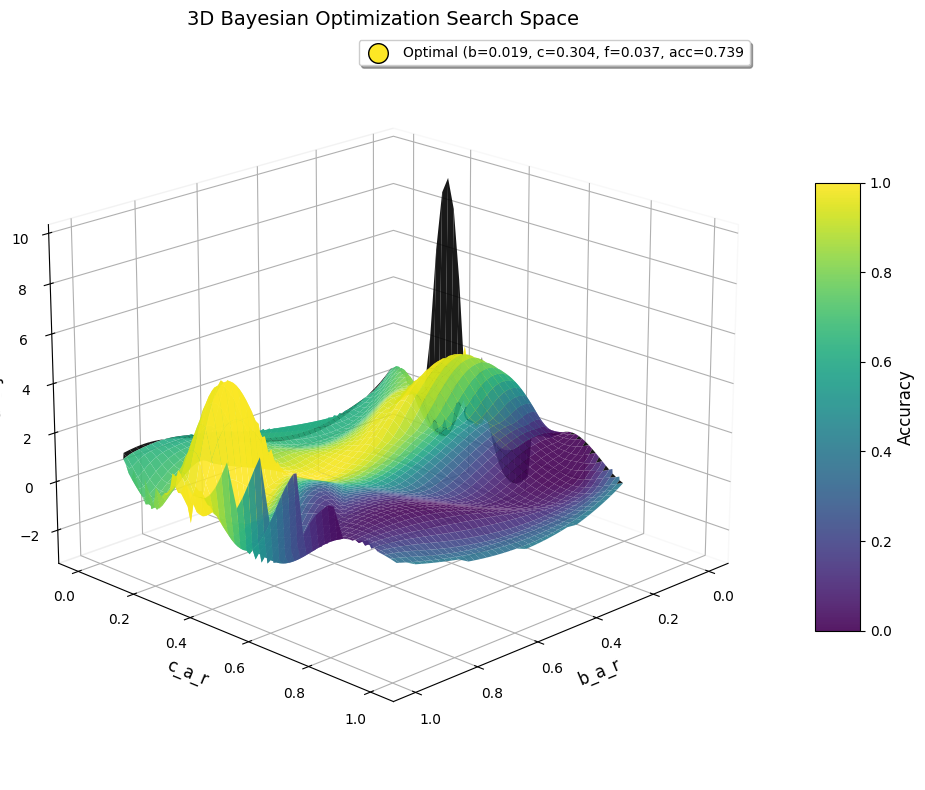

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from skopt import gp_minimize
from skopt.space import Real
from matplotlib import cm




# Extract values from optimizer log
b_a_r_vals, c_a_r_vals, f_a_r_vals = np.array(res.x_iters).T  # Extract search points
accuracy_vals = -np.array(res.func_vals)  # Convert from negative accuracy (since we minimized)

# Find the optimal point (highest accuracy)
optimal_idx = np.argmax(accuracy_vals)
optimal_b, optimal_c, optimal_f = b_a_r_vals[optimal_idx], c_a_r_vals[optimal_idx], f_a_r_vals[optimal_idx]
optimal_acc = accuracy_vals[optimal_idx]

# Create a 2D meshgrid for b_a_r and c_a_r
grid_b, grid_c = np.meshgrid(
    np.linspace(min(b_a_r_vals), max(b_a_r_vals), 100),
    np.linspace(min(c_a_r_vals), max(c_a_r_vals), 100)
)

# Interpolate f_a_r and accuracy values
grid_f = griddata((b_a_r_vals, c_a_r_vals), f_a_r_vals, (grid_b, grid_c), method='cubic')
grid_acc = griddata((b_a_r_vals, c_a_r_vals), accuracy_vals, (grid_b, grid_c), method='cubic')

# Normalize accuracy values for color mapping
norm = plt.Normalize(vmin=min(accuracy_vals), vmax=max(accuracy_vals))
colors = plt.cm.viridis(norm(grid_acc))

# Create figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface with accurate color mapping
surf = ax.plot_surface(grid_b, grid_c, grid_f, facecolors=colors, cmap='viridis', alpha=0.9, edgecolor='none')

# Mark the optimal point with a larger, more noticeable marker
optimal_color = plt.cm.viridis(norm(optimal_acc))  # Get color from the colormap based on accuracy
ax.scatter(optimal_b, optimal_c, optimal_f, color=optimal_color, s=200, edgecolors='black', label=f"Optimal (b={optimal_b:.3f}, c={optimal_c:.3f}, f={optimal_f:.3f}, acc={optimal_acc:.3f}")

# Add color bar with a label
cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Accuracy', fontsize=12)

# Labels with larger font size
ax.set_xlabel("b_a_r", fontsize=12)
ax.set_ylabel("c_a_r", fontsize=12)
ax.set_zlabel("f_a_r", fontsize=12)
ax.set_title("3D Bayesian Optimization Search Space", fontsize=14)

# Add grid lines for better readability
ax.grid(True)

# Adjust the viewing angle for better perspective
ax.view_init(elev=20, azim=45)

# Add a legend with a shadow and larger font size
ax.legend(loc='upper right', fontsize=10, shadow=True)

# Improve lighting for better depth perception
ax.set_facecolor('white')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Add a tight layout to prevent overlap
plt.tight_layout()

plt.show()

In [59]:
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz = convolutional_network_with_dropout
M3 = PrototypicalNetworks_dynamic_query(xyz).to(device)
M3.load_state_dict(torch.load('model_own_path.pt'))
evaluate2('/home/asufian/Desktop/output_assamese/Densnet_resluts/base/5_w_5_s_f', test_loader, M3, criterion)
# Load Model M2
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz2 = convolutional_network_with_dropout
M2 = PrototypicalNetworks_dynamic_query(xyz2).to(device)
M2.load_state_dict(torch.load('model_mu_path.pt'))
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/secondary/5_w_5_s_f", test_loader, M2, criterion)
# Update Model M3's weights using a weighted combination of Model M3 and Model M2
update_model_weights2(M3, M2, conv_ratio= optimal_c_a_r , fc_ratio=optimal_f_a_r , bias_ratio=optimal_b_a_r)

# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/amul/5_w_5_s_f", test_loader, M3, criterion)


# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
# evaluate3(pp+'/_olchiki_5-wau-1-shot_matchine_unlearning_own', test_loader, M3, criterion)

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.6287 ± 0.0554  0.6502 ± 0.0607  0.6286 ± 0.0553


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.5210 ± 0.0681  0.5310 ± 0.0738  0.5210 ± 0.0681
---Accu-----pre----rec---------> 0.7394 ± 0.0623  0.7523 ± 0.0575  0.7394 ± 0.0623


In [33]:
!ls /home/asufian/Desktop/output_olchiki/code/olchiki/model_10

model_B_olchiki_1-shot_20.pth  model_B_olchiki_1-shot_70.pth
model_B_olchiki_1-shot_40.pth  model_B_olchiki_1-shot_90.pth
model_B_olchiki_1-shot_50.pth


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



!rm model_mu_path.pt
!rm model_own_path.pt

convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/modelrdnet.pth',map_location=torch.device('cpu')))


convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own_1_shot = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own_1_shot.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/asamese_sce/denssecondary/model_10/model_B_olchiki_10-shot_dens.pth',map_location=torch.device('cpu')))

torch.save(model_own_1_shot.state_dict(), 'model_mu_path.pt')
torch.save(model_own.state_dict(), 'model_own_path.pt')

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


In [51]:


def evaluate2(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlal=[]
    ttlac=0
    precision=[]
    recall=[]
    
    with torch.no_grad():
        for episode in range(len(clss_5)):
            support_set, query_set = data_loader.__getitem__(clss_5[tlv_cls] , clss_support_imagesss_10_shot[tlv_cls])

           
            clssa=str(clss_5[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_10_shot[tlv_cls])
            str(clss_5[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            ttlal.append(accuracy)
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            precision_overall, recall_overall, f1ss= calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)
            precision.append(precision_overall)
            recall.append(recall_overall)
    print(f"---Accu-----pre----rec---------> {np.mean(ttlal):.4f} ± {np.std(ttlal, ddof=1):.4f}  "
      f"{np.mean(precision):.4f} ± {np.std(precision, ddof=1):.4f}  "
      f"{np.mean(recall):.4f} ± {np.std(recall, ddof=1):.4f}")

    # print("---Accu-----pre----rec---------->",np.mean(ttlal),'±',np.std(ttlal, ddof=1), np.mean(precision),'±',np.std(precision, ddof=1),np.mean(precision),'±',np.std(precision, ddof=1),)
# %%%%%%

def evaluate3(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlac=0
    with torch.no_grad():
        for episode in range(len(clss_5)):
            support_set, query_set = data_loader.__getitem__(clss_5[tlv_cls] , clss_support_imagesss_10_shot[tlv_cls])

            
            clssa=str(clss_5[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_10_shot[tlv_cls])
            str(clss_5[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            # confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            # calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)

    print("---------------------->",ttlac/ttla)
    return ttlac/ttla

In [52]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the search space for b_a_r, c_a_r, and f_a_r
search_space = [
    Real(0.0, 1.0, name="b_a_r"),
    Real(0.0, 1.0, name="c_a_r"),
    Real(0.0, 1.0, name="f_a_r")
]

# Define the objective function for Bayesian Optimization
@use_named_args(search_space)
def objective(b_a_r, c_a_r, f_a_r):
    """
    Objective function to optimize the adaptation ratios.
    It applies adaptation, evaluates the model, and returns the negative accuracy.
    """
    accuracy = get_model_accuracy(b_a_r, c_a_r, f_a_r)
    print(f"Evaluated Accuracy: {accuracy:.4f}")  # Debugging Output
    
    return -accuracy  # We minimize, so return negative accuracy

# Perform Bayesian Optimization with additional settings
search_iteration=50
res = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=search_iteration,               # Number of evaluations
    n_initial_points=5,       # Initial random explorations before GP starts
    acq_func="EI",            # Acquisition function: Expected Improvement
    random_state=42,          # Ensure reproducibility
    n_jobs=-1,                # Parallel execution for faster optimization
)

# Extract optimal results
optimal_b_a_r, optimal_c_a_r, optimal_f_a_r = res.x
best_accuracy = -res.fun

print(f"\n✅ Optimal Values:")
print(f"   - b_a_r: {optimal_b_a_r:.4f}")
print(f"   - c_a_r: {optimal_c_a_r:.4f}")
print(f"   - f_a_r: {optimal_f_a_r:.4f}")
print(f"📈 Highest Accuracy Achieved: {best_accuracy:.4f}")




Testing b_a_r = 0.7965, c_a_r = 0.1834, f_a_r = 0.7797


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6853495546598994
Evaluated Accuracy: 0.6853
Testing b_a_r = 0.5969, c_a_r = 0.4458, f_a_r = 0.1000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6575551077275216
Evaluated Accuracy: 0.6576
Testing b_a_r = 0.4592, c_a_r = 0.3337, f_a_r = 0.1429


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7387025924267304
Evaluated Accuracy: 0.7387
Testing b_a_r = 0.6509, c_a_r = 0.0564, f_a_r = 0.7220


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6327582972582972
Evaluated Accuracy: 0.6328
Testing b_a_r = 0.9386, c_a_r = 0.0008, f_a_r = 0.9922


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.631225755087824
Evaluated Accuracy: 0.6312
Testing b_a_r = 0.2064, c_a_r = 0.2892, f_a_r = 0.9884


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.746693909538737
Evaluated Accuracy: 0.7467
Testing b_a_r = 0.2213, c_a_r = 1.0000, f_a_r = 0.9428


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6686134995272925
Evaluated Accuracy: 0.6686
Testing b_a_r = 0.9816, c_a_r = 0.7599, f_a_r = 0.6116


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4388916007364284
Evaluated Accuracy: 0.4389
Testing b_a_r = 0.9582, c_a_r = 0.2595, f_a_r = 0.0220


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.736782554610141
Evaluated Accuracy: 0.7368
Testing b_a_r = 0.0582, c_a_r = 0.9219, f_a_r = 0.0018


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5718642334676817
Evaluated Accuracy: 0.5719
Testing b_a_r = 0.9382, c_a_r = 0.3038, f_a_r = 0.0258


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7463195253022838
Evaluated Accuracy: 0.7463
Testing b_a_r = 0.0133, c_a_r = 0.5748, f_a_r = 0.5463


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.47885278897347855
Evaluated Accuracy: 0.4789
Testing b_a_r = 0.0122, c_a_r = 0.3037, f_a_r = 0.0194


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7448043986664676
Evaluated Accuracy: 0.7448
Testing b_a_r = 0.8168, c_a_r = 0.3806, f_a_r = 0.9930


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7249903965766035
Evaluated Accuracy: 0.7250
Testing b_a_r = 0.9417, c_a_r = 0.3167, f_a_r = 0.9351


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7444037916106881
Evaluated Accuracy: 0.7444
Testing b_a_r = 0.8396, c_a_r = 0.1246, f_a_r = 0.0540


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6476264367816091
Evaluated Accuracy: 0.6476
Testing b_a_r = 0.0551, c_a_r = 0.2314, f_a_r = 0.8220


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7162003284072251
Evaluated Accuracy: 0.7162
Testing b_a_r = 0.9569, c_a_r = 0.6693, f_a_r = 0.1258


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.45677461810220427
Evaluated Accuracy: 0.4568
Testing b_a_r = 0.7890, c_a_r = 0.8485, f_a_r = 0.9742


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.48882479972135146
Evaluated Accuracy: 0.4888
Testing b_a_r = 0.9450, c_a_r = 0.2846, f_a_r = 0.1201


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7455510275165447
Evaluated Accuracy: 0.7456
Testing b_a_r = 0.9649, c_a_r = 0.2987, f_a_r = 0.9817


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7455554311588793
Evaluated Accuracy: 0.7456
Testing b_a_r = 0.1921, c_a_r = 0.2765, f_a_r = 0.9955


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7501202915858088
Evaluated Accuracy: 0.7501
Testing b_a_r = 0.0348, c_a_r = 0.3385, f_a_r = 0.9743


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7398520177140867
Evaluated Accuracy: 0.7399
Testing b_a_r = 0.0779, c_a_r = 0.2832, f_a_r = 0.0383


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7493605513260686
Evaluated Accuracy: 0.7494
Testing b_a_r = 0.0130, c_a_r = 0.2865, f_a_r = 0.9707


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7489839528287803
Evaluated Accuracy: 0.7490
Testing b_a_r = 0.9701, c_a_r = 0.2933, f_a_r = 0.9824


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7459341941583321
Evaluated Accuracy: 0.7459
Testing b_a_r = 0.0186, c_a_r = 0.3041, f_a_r = 0.0365


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7455663034283725
Evaluated Accuracy: 0.7456
Testing b_a_r = 0.0347, c_a_r = 0.2719, f_a_r = 0.9709


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7478367418022592
Evaluated Accuracy: 0.7478
Testing b_a_r = 0.0643, c_a_r = 0.3574, f_a_r = 0.0906


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7429061302681993
Evaluated Accuracy: 0.7429
Testing b_a_r = 0.0293, c_a_r = 0.2803, f_a_r = 0.0289


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.750884360849878
Evaluated Accuracy: 0.7509
Testing b_a_r = 0.9743, c_a_r = 0.3476, f_a_r = 0.2497


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.739847614071752
Evaluated Accuracy: 0.7398
Testing b_a_r = 0.9856, c_a_r = 0.2724, f_a_r = 0.0808


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7455553565208739
Evaluated Accuracy: 0.7456
Testing b_a_r = 0.0856, c_a_r = 0.3967, f_a_r = 0.0899


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7219493207941484
Evaluated Accuracy: 0.7219
Testing b_a_r = 0.0206, c_a_r = 0.3037, f_a_r = 0.0283


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7444278001691795
Evaluated Accuracy: 0.7444
Testing b_a_r = 0.0462, c_a_r = 0.2713, f_a_r = 0.9882


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7474557894213069
Evaluated Accuracy: 0.7475
Testing b_a_r = 0.9901, c_a_r = 0.2757, f_a_r = 0.9699


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.748602975568493
Evaluated Accuracy: 0.7486
Testing b_a_r = 0.9464, c_a_r = 0.3621, f_a_r = 0.0295


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7371852764094144
Evaluated Accuracy: 0.7372
Testing b_a_r = 0.0042, c_a_r = 0.2752, f_a_r = 0.0399


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7520250534905707
Evaluated Accuracy: 0.7520
Testing b_a_r = 0.9683, c_a_r = 0.2788, f_a_r = 0.0002


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7489817634472807
Evaluated Accuracy: 0.7490
Testing b_a_r = 0.9971, c_a_r = 0.9719, f_a_r = 0.6003


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6503516694033935
Evaluated Accuracy: 0.6504
Testing b_a_r = 0.0000, c_a_r = 0.1518, f_a_r = 0.5788


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6708711748022095
Evaluated Accuracy: 0.6709
Testing b_a_r = 0.0198, c_a_r = 0.4967, f_a_r = 0.0424


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5897320993183063
Evaluated Accuracy: 0.5897
Testing b_a_r = 0.0065, c_a_r = 0.3665, f_a_r = 0.5286


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7383259690501071
Evaluated Accuracy: 0.7383
Testing b_a_r = 0.0064, c_a_r = 0.2621, f_a_r = 0.1620


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7417436930885207
Evaluated Accuracy: 0.7417
Testing b_a_r = 0.0163, c_a_r = 0.0007, f_a_r = 0.5384


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6296975668010151
Evaluated Accuracy: 0.6297
Testing b_a_r = 0.0057, c_a_r = 0.3209, f_a_r = 0.7876


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7417502363536845
Evaluated Accuracy: 0.7418
Testing b_a_r = 0.9099, c_a_r = 0.3257, f_a_r = 0.0170


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7436484549932826
Evaluated Accuracy: 0.7436
Testing b_a_r = 0.9981, c_a_r = 0.2460, f_a_r = 0.8267


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7264946758222621
Evaluated Accuracy: 0.7265
Testing b_a_r = 0.9793, c_a_r = 0.9998, f_a_r = 0.6363


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6720659799970145
Evaluated Accuracy: 0.6721
Testing b_a_r = 0.9683, c_a_r = 0.2879, f_a_r = 0.0266


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.7436462904911181
Evaluated Accuracy: 0.7436

✅ Optimal Values:
   - b_a_r: 0.0042
   - c_a_r: 0.2752
   - f_a_r: 0.0399
📈 Highest Accuracy Achieved: 0.7520


In [54]:
import pickle

# Save the optimization results to a file
with open('asse_5w-10s-dens.pkl', 'wb') as f:
    pickle.dump(res, f)

print("Optimization results saved to 'bayesian_optimization_results.pkl'")


Optimization results saved to 'bayesian_optimization_results.pkl'


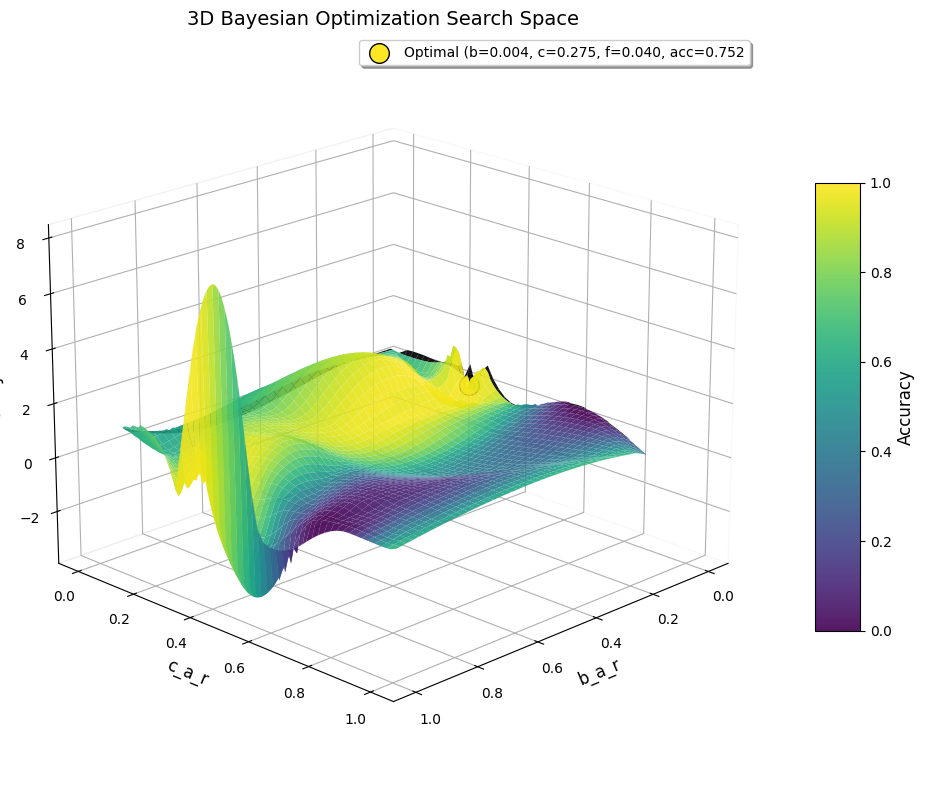

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from skopt import gp_minimize
from skopt.space import Real
from matplotlib import cm



# Extract values from optimizer log
b_a_r_vals, c_a_r_vals, f_a_r_vals = np.array(res.x_iters).T  # Extract search points
accuracy_vals = -np.array(res.func_vals)  # Convert from negative accuracy (since we minimized)

# Find the optimal point (highest accuracy)
optimal_idx = np.argmax(accuracy_vals)
optimal_b, optimal_c, optimal_f = b_a_r_vals[optimal_idx], c_a_r_vals[optimal_idx], f_a_r_vals[optimal_idx]
optimal_acc = accuracy_vals[optimal_idx]

# Create a 2D meshgrid for b_a_r and c_a_r
grid_b, grid_c = np.meshgrid(
    np.linspace(min(b_a_r_vals), max(b_a_r_vals), 100),
    np.linspace(min(c_a_r_vals), max(c_a_r_vals), 100)
)

# Interpolate f_a_r and accuracy values
grid_f = griddata((b_a_r_vals, c_a_r_vals), f_a_r_vals, (grid_b, grid_c), method='cubic')
grid_acc = griddata((b_a_r_vals, c_a_r_vals), accuracy_vals, (grid_b, grid_c), method='cubic')

# Normalize accuracy values for color mapping
norm = plt.Normalize(vmin=min(accuracy_vals), vmax=max(accuracy_vals))
colors = plt.cm.viridis(norm(grid_acc))

# Create figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface with accurate color mapping
surf = ax.plot_surface(grid_b, grid_c, grid_f, facecolors=colors, cmap='viridis', alpha=0.9, edgecolor='none')

# Mark the optimal point with a larger, more noticeable marker
optimal_color = plt.cm.viridis(norm(optimal_acc))  # Get color from the colormap based on accuracy
ax.scatter(optimal_b, optimal_c, optimal_f, color=optimal_color, s=200, edgecolors='black', label=f"Optimal (b={optimal_b:.3f}, c={optimal_c:.3f}, f={optimal_f:.3f}, acc={optimal_acc:.3f}")

# Add color bar with a label
cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Accuracy', fontsize=12)

# Labels with larger font size
ax.set_xlabel("b_a_r", fontsize=12)
ax.set_ylabel("c_a_r", fontsize=12)
ax.set_zlabel("f_a_r", fontsize=12)
ax.set_title("3D Bayesian Optimization Search Space", fontsize=14)

# Add grid lines for better readability
ax.grid(True)

# Adjust the viewing angle for better perspective
ax.view_init(elev=20, azim=45)

# Add a legend with a shadow and larger font size
ax.legend(loc='upper right', fontsize=10, shadow=True)

# Improve lighting for better depth perception
ax.set_facecolor('white')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Add a tight layout to prevent overlap
plt.tight_layout()

plt.show()

In [63]:
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz = convolutional_network_with_dropout
M3 = PrototypicalNetworks_dynamic_query(xyz).to(device)
M3.load_state_dict(torch.load('model_own_path.pt'))
evaluate2('/home/asufian/Desktop/output_assamese/Densnet_resluts/base/5_w_10_s_f', test_loader, M3, criterion)
# Load Model M2
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz2 = convolutional_network_with_dropout
M2 = PrototypicalNetworks_dynamic_query(xyz2).to(device)
M2.load_state_dict(torch.load('model_mu_path.pt'))
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/secondary/5_w_10_s_f", test_loader, M2, criterion)
# Update Model M3's weights using a weighted combination of Model M3 and Model M2
update_model_weights2(M3, M2, conv_ratio= optimal_c_a_r , fc_ratio=optimal_f_a_r , bias_ratio=optimal_b_a_r)

# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/amul/5_w_10_s_f", test_loader, M3, criterion)


# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
# evaluate3(pp+'/_olchiki_5-wau-1-shot_matchine_unlearning_own', test_loader, M3, criterion)

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.6305 ± 0.0457  0.6493 ± 0.0567  0.6303 ± 0.0456


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.6172 ± 0.0776  0.6232 ± 0.0824  0.6171 ± 0.0776
---Accu-----pre----rec---------> 0.7520 ± 0.0609  0.7598 ± 0.0575  0.7520 ± 0.0609


In [64]:
ls /home/asufian/Desktop/output_olchiki/lol

5_w_10_s.txt  5_w_10_s.xlsx


In [65]:
clss_8=[
       ['assamese1_DXA', 'assamese1_SUNYA', 'assamese1_KTA', 'assamese1_CARI', 'assamese1_AA', 'assamese1_ATH', 'assamese1_DUI', 'assamese1_MNA'],
     ['assamese1_BA', 'assamese1_OU', 'assamese1_NA', 'assamese1_TINI', 'assamese1_MDHA', 'assamese1_E', 'assamese1_A', 'assamese1_TXA'],
    ['assamese1_ATH', 'assamese1_CA', 'assamese1_NG', 'assamese1_EK', 'assamese1_ANSR', 'assamese1_AA', 'assamese1_KTA', 'assamese1_DHA'],
    ['assamese1_KA', 'assamese1_XAT', 'assamese1_E', 'assamese1_MA', 'assamese1_CCA', 'assamese1_MTA', 'assamese1_A', 'assamese1_AE'],
    ['assamese1_TINI', 'assamese1_KHYA', 'assamese1_NAA', 'assamese1_HA', 'assamese1_DUI', 'assamese1_CBN', 'assamese1_TR', 'assamese1_AE'],
     ['assamese1_DA', 'assamese1_SUNYA', 'assamese1_AJA', 'assamese1_ANSR', 'assamese1_PHA', 'assamese1_NAA', 'assamese1_MDHA', 'assamese1_NG'],
    ['assamese1_DUI', 'assamese1_E', 'assamese1_AYA', 'assamese1_MA', 'assamese1_THA', 'assamese1_MTA', 'assamese1_ATH', 'assamese1_NIYA'],
    ['assamese1_MA', 'assamese1_AYA', 'assamese1_NIYA', 'assamese1_KTA', 'assamese1_ATH', 'assamese1_PAC', 'assamese1_KHYA', 'assamese1_DUI'],
     ['assamese1_DXA', 'assamese1_CAY', 'assamese1_MNA', 'assamese1_ANSR', 'assamese1_AA', 'assamese1_TXA', 'assamese1_GA', 'assamese1_ATH'],
    ['assamese1_RA', 'assamese1_ATH', 'assamese1_CARI', 'assamese1_NG', 'assamese1_DA', 'assamese1_REE', 'assamese1_AJA', 'assamese1_A'],
    ['assamese1_KHA', 'assamese1_THA', 'assamese1_AA', 'assamese1_MNA', 'assamese1_SUNYA', 'assamese1_NIYA', 'assamese1_LA', 'assamese1_MDHA'],
     ['assamese1_KA', 'assamese1_AYA', 'assamese1_LA', 'assamese1_TINI', 'assamese1_MA', 'assamese1_KTA', 'assamese1_MDHA', 'assamese1_PA'],
    ['assamese1_DHRA', 'assamese1_CCA', 'assamese1_DXA', 'assamese1_TXA', 'assamese1_SUNYA', 'assamese1_ANSR', 'assamese1_HA', 'assamese1_OU'],
    ['assamese1_NG', 'assamese1_JHA', 'assamese1_GHA', 'assamese1_MTHA', 'assamese1_ANSR', 'assamese1_ATH', 'assamese1_PA', 'assamese1_MDHA'],
    ['assamese1_ATH', 'assamese1_CAY', 'assamese1_DUI', 'assamese1_AJA', 'assamese1_AA', 'assamese1_THA', 'assamese1_BHA', 'assamese1_HA'],
    ]

clss_support_imagesss_10_shot=[[[24, 30, 13, 26, 3, 2, 42, 12, 29, 33], [16, 31, 30, 15, 22, 33, 6, 41, 0, 12], [7, 31, 42, 1, 30, 35, 20, 39, 0, 3], [39, 41, 6, 34, 16, 36, 17, 1, 43, 44], [42, 5, 38, 41, 7, 37, 6, 1, 28, 2], [2, 10, 15, 24, 38, 5, 29, 18, 9, 32], [34, 38, 18, 5, 25, 14, 19, 29, 0, 2], [7, 13, 26, 43, 4, 41, 8, 2, 18, 30]], [[14, 31, 35, 11, 44, 40, 9, 20, 12, 24], [43, 35, 29, 0, 10, 24, 34, 27, 11, 38], [40, 42, 34, 41, 12, 31, 15, 10, 44, 5], [21, 29, 4, 10, 19, 34, 5, 2, 41, 0], [18, 25, 11, 5, 43, 8, 19, 13, 42, 39], [18, 41, 2, 3, 33, 6, 21, 36, 32, 23], [44, 1, 16, 29, 35, 26, 19, 18, 36, 37], [36, 12, 22, 44, 29, 1, 2, 39, 34, 35]], [[10, 26, 40, 36, 38, 16, 2, 39, 6, 11], [41, 23, 19, 24, 6, 34, 13, 35, 22, 44], [29, 0, 40, 32, 41, 3, 11, 34, 39, 13], [40, 6, 0, 24, 14, 41, 37, 25, 27, 36], [36, 35, 32, 42, 7, 19, 33, 13, 17, 22], [13, 7, 12, 44, 19, 39, 40, 37, 29, 36], [17, 19, 23, 8, 31, 18, 32, 26, 22, 34], [19, 17, 0, 13, 28, 32, 20, 22, 1, 24]], [[23, 2, 25, 26, 12, 4, 34, 6, 13, 19], [15, 14, 24, 1, 26, 35, 28, 5, 13, 34], [28, 30, 25, 41, 33, 37, 20, 4, 3, 15], [39, 13, 41, 6, 35, 38, 29, 20, 14, 19], [38, 30, 10, 12, 3, 40, 25, 34, 0, 27], [0, 16, 27, 13, 40, 43, 41, 1, 39, 9], [27, 42, 35, 38, 40, 20, 15, 2, 26, 6], [14, 22, 29, 10, 37, 33, 28, 27, 43, 13]], [[7, 34, 0, 37, 21, 33, 44, 2, 24, 26], [28, 21, 36, 32, 33, 9, 1, 13, 5, 29], [28, 30, 18, 8, 27, 13, 22, 36, 33, 4], [32, 22, 36, 42, 0, 11, 39, 7, 37, 38], [16, 11, 40, 14, 38, 7, 33, 28, 26, 20], [36, 44, 43, 12, 38, 9, 13, 34, 30, 5], [22, 30, 25, 4, 44, 40, 16, 21, 36, 18], [11, 12, 26, 9, 29, 20, 37, 19, 30, 0]], [[37, 8, 41, 16, 27, 2, 13, 39, 38, 24], [10, 43, 42, 5, 8, 16, 34, 23, 9, 1], [13, 11, 41, 44, 32, 17, 3, 9, 34, 28], [36, 1, 4, 18, 24, 42, 22, 17, 10, 15], [37, 35, 40, 12, 41, 28, 22, 18, 4, 17], [8, 33, 15, 1, 3, 0, 17, 44, 20, 12], [4, 19, 20, 24, 12, 15, 6, 14, 10, 17], [21, 13, 38, 24, 9, 26, 22, 23, 41, 6]], [[42, 30, 16, 39, 41, 8, 23, 37, 9, 12], [13, 3, 29, 10, 25, 38, 40, 14, 11, 5], [36, 26, 14, 27, 6, 0, 38, 18, 42, 44], [20, 38, 33, 6, 36, 8, 40, 4, 18, 44], [30, 26, 38, 24, 8, 14, 0, 6, 19, 37], [8, 27, 34, 17, 43, 23, 11, 30, 21, 44], [12, 36, 35, 25, 39, 43, 29, 44, 10, 21], [12, 7, 22, 0, 36, 8, 28, 29, 15, 26]], [[40, 8, 43, 38, 23, 3, 24, 12, 25, 22], [27, 20, 14, 31, 9, 11, 42, 23, 5, 38], [22, 12, 27, 1, 17, 38, 41, 21, 13, 2], [6, 16, 8, 42, 3, 7, 35, 22, 44, 21], [2, 12, 30, 44, 4, 10, 38, 6, 36, 42], [32, 17, 21, 38, 36, 43, 10, 29, 20, 4], [15, 25, 43, 10, 5, 35, 19, 20, 12, 0], [2, 13, 15, 16, 43, 8, 9, 5, 41, 24]], [[1, 26, 39, 8, 5, 22, 16, 38, 29, 19], [12, 11, 43, 28, 40, 6, 38, 24, 8, 16], [6, 14, 20, 2, 31, 28, 35, 19, 34, 33], [29, 23, 1, 25, 3, 31, 18, 27, 9, 12], [22, 42, 35, 3, 37, 6, 31, 38, 7, 41], [14, 23, 37, 44, 30, 18, 24, 32, 4, 25], [26, 10, 13, 32, 25, 36, 7, 29, 41, 15], [31, 16, 35, 9, 6, 11, 3, 41, 2, 25]], [[25, 37, 5, 10, 33, 36, 3, 19, 43, 29], [11, 2, 23, 29, 3, 43, 37, 21, 44, 7], [40, 17, 11, 14, 31, 38, 7, 3, 4, 42], [39, 29, 16, 19, 6, 37, 4, 23, 5, 15], [22, 5, 34, 36, 13, 44, 29, 16, 33, 25], [20, 15, 17, 38, 33, 29, 30, 13, 1, 8], [42, 44, 22, 0, 29, 19, 6, 13, 25, 1], [4, 38, 3, 35, 19, 34, 20, 29, 42, 6]], [[7, 29, 19, 4, 40, 6, 30, 12, 41, 31], [38, 3, 29, 17, 14, 28, 37, 33, 36, 40], [22, 30, 11, 17, 10, 32, 39, 12, 2, 6], [29, 17, 9, 44, 20, 21, 12, 19, 25, 4], [5, 21, 37, 23, 41, 40, 38, 16, 12, 25], [23, 8, 21, 15, 43, 44, 7, 12, 26, 16], [6, 4, 26, 38, 10, 20, 28, 13, 0, 39], [27, 36, 2, 1, 28, 4, 5, 24, 13, 33]], [[42, 1, 20, 12, 34, 24, 8, 26, 15, 18], [40, 41, 43, 11, 24, 27, 10, 21, 29, 38], [16, 34, 19, 39, 7, 22, 29, 5, 35, 17], [24, 34, 37, 16, 35, 31, 20, 1, 42, 38], [33, 2, 16, 7, 3, 4, 39, 20, 11, 35], [43, 17, 24, 14, 40, 5, 29, 39, 13, 38], [6, 3, 21, 27, 19, 10, 44, 9, 30, 26], [16, 3, 25, 22, 38, 42, 27, 23, 20, 18]], [[40, 30, 1, 23, 41, 0, 12, 25, 43, 35], [18, 7, 20, 31, 21, 30, 43, 11, 42, 12], [25, 14, 2, 28, 24, 3, 39, 9, 36, 33], [23, 14, 32, 35, 17, 20, 29, 5, 30, 16], [19, 17, 34, 18, 20, 39, 7, 24, 29, 35], [4, 39, 15, 25, 44, 7, 6, 23, 29, 37], [39, 34, 23, 13, 2, 6, 42, 25, 7, 1], [7, 9, 19, 34, 39, 28, 4, 41, 29, 33]], [[1, 29, 19, 21, 43, 41, 36, 15, 14, 18], [36, 33, 23, 31, 19, 25, 11, 32, 21, 28], [43, 26, 42, 29, 2, 13, 39, 41, 33, 19], [36, 27, 34, 20, 43, 10, 33, 7, 37, 28], [33, 25, 9, 16, 2, 26, 39, 41, 11, 8], [16, 39, 40, 12, 13, 0, 1, 27, 5, 9], [31, 13, 11, 15, 27, 32, 4, 8, 43, 41], [11, 33, 40, 28, 20, 30, 22, 15, 12, 21]], [[18, 24, 21, 32, 19, 40, 35, 20, 9, 38], [5, 28, 0, 19, 40, 33, 29, 10, 24, 27], [11, 22, 27, 14, 40, 9, 36, 16, 41, 5], [9, 28, 34, 15, 39, 20, 4, 33, 43, 16], [8, 25, 26, 31, 27, 20, 6, 40, 2, 30], [3, 15, 33, 28, 44, 0, 36, 12, 21, 18], [39, 17, 22, 9, 1, 33, 21, 29, 15, 36], [38, 30, 36, 40, 21, 4, 5, 22, 7, 3]]]

clss_support_imagesss_5_shot=[[[24, 30, 13, 26, 3], [16, 31, 30, 15, 22], [7, 31, 42, 1, 30], [39, 41, 6, 34, 16], [42, 5, 38, 41, 7], [2, 10, 15, 24, 38], [34, 38, 18, 5, 25], [7, 13, 26, 43, 4]], [[14, 31, 35, 11, 44], [43, 35, 29, 0, 10], [40, 42, 34, 41, 12], [21, 29, 4, 10, 19], [18, 25, 11, 5, 43], [18, 41, 2, 3, 33], [44, 1, 16, 29, 35], [36, 12, 22, 44, 29]], [[10, 26, 40, 36, 38], [41, 23, 19, 24, 6], [29, 0, 40, 32, 41], [40, 6, 0, 24, 14], [36, 35, 32, 42, 7], [13, 7, 12, 44, 19], [17, 19, 23, 8, 31], [19, 17, 0, 13, 28]], [[23, 2, 25, 26, 12], [15, 14, 24, 1, 26], [28, 30, 25, 41, 33], [39, 13, 41, 6, 35], [38, 30, 10, 12, 3], [0, 16, 27, 13, 40], [27, 42, 35, 38, 40], [14, 22, 29, 10, 37]], [[7, 34, 0, 37, 21], [28, 21, 36, 32, 33], [28, 30, 18, 8, 27], [32, 22, 36, 42, 0], [16, 11, 40, 14, 38], [36, 44, 43, 12, 38], [22, 30, 25, 4, 44], [11, 12, 26, 9, 29]], [[37, 8, 41, 16, 27], [10, 43, 42, 5, 8], [13, 11, 41, 44, 32], [36, 1, 4, 18, 24], [37, 35, 40, 12, 41], [8, 33, 15, 1, 3], [4, 19, 20, 24, 12], [21, 13, 38, 24, 9]], [[42, 30, 16, 39, 41], [13, 3, 29, 10, 25], [36, 26, 14, 27, 6], [20, 38, 33, 6, 36], [30, 26, 38, 24, 8], [8, 27, 34, 17, 43], [12, 36, 35, 25, 39], [12, 7, 22, 0, 36]], [[40, 8, 43, 38, 23], [27, 20, 14, 31, 9], [22, 12, 27, 1, 17], [6, 16, 8, 42, 3], [2, 12, 30, 44, 4], [32, 17, 21, 38, 36], [15, 25, 43, 10, 5], [2, 13, 15, 16, 43]], [[1, 26, 39, 8, 5], [12, 11, 43, 28, 40], [6, 14, 20, 2, 31], [29, 23, 1, 25, 3], [22, 42, 35, 3, 37], [14, 23, 37, 44, 30], [26, 10, 13, 32, 25], [31, 16, 35, 9, 6]], [[25, 37, 5, 10, 33], [11, 2, 23, 29, 3], [40, 17, 11, 14, 31], [39, 29, 16, 19, 6], [22, 5, 34, 36, 13], [20, 15, 17, 38, 33], [42, 44, 22, 0, 29], [4, 38, 3, 35, 19]], [[7, 29, 19, 4, 40], [38, 3, 29, 17, 14], [22, 30, 11, 17, 10], [29, 17, 9, 44, 20], [5, 21, 37, 23, 41], [23, 8, 21, 15, 43], [6, 4, 26, 38, 10], [27, 36, 2, 1, 28]], [[42, 1, 20, 12, 34], [40, 41, 43, 11, 24], [16, 34, 19, 39, 7], [24, 34, 37, 16, 35], [33, 2, 16, 7, 3], [43, 17, 24, 14, 40], [6, 3, 21, 27, 19], [16, 3, 25, 22, 38]], [[40, 30, 1, 23, 41], [18, 7, 20, 31, 21], [25, 14, 2, 28, 24], [23, 14, 32, 35, 17], [19, 17, 34, 18, 20], [4, 39, 15, 25, 44], [39, 34, 23, 13, 2], [7, 9, 19, 34, 39]], [[1, 29, 19, 21, 43], [36, 33, 23, 31, 19], [43, 26, 42, 29, 2], [36, 27, 34, 20, 43], [33, 25, 9, 16, 2], [16, 39, 40, 12, 13], [31, 13, 11, 15, 27], [11, 33, 40, 28, 20]], [[18, 24, 21, 32, 19], [5, 28, 0, 19, 40], [11, 22, 27, 14, 40], [9, 28, 34, 15, 39], [8, 25, 26, 31, 27], [3, 15, 33, 28, 44], [39, 17, 22, 9, 1], [38, 30, 36, 40, 21]]]


clss_support_imagesss_1_shot=[
   [[24], [16], [7], [39], [42], [2], [34], [7]],
   [[14], [43], [40], [21], [18], [18], [44], [36]],
   [[10], [41], [29], [40], [36], [13], [17], [19]],
   [[23], [15], [28], [39], [38], [0], [27], [14]],
   [[7], [28], [28], [32], [16], [36], [22], [11]],
   [[37], [10], [13], [36], [37], [8], [4], [21]],
   [[42], [13], [36], [20], [30], [8], [12], [12]],
   [[40], [27], [22], [6], [2], [32], [15], [2]],
   [[1], [12], [6], [29], [22], [14], [26], [31]],
   [[25], [11], [40], [39], [22], [20], [42], [4]],
   [[7], [38], [22], [29], [5], [23], [6], [27]],
   [[42], [40], [16], [24], [33], [43], [6], [16]],
   [[40], [18], [25], [23], [19], [4], [39], [7]],
   [[1], [36], [43], [36], [33], [16], [31], [11]],
   [[18], [5], [11], [9], [8], [3], [39], [38]]

]



In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



!rm model_mu_path.pt
!rm model_own_path.pt

convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/modelrdnet.pth',map_location=torch.device('cpu')))


convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own_1_shot = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own_1_shot.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/asamese_sce/denssecondary/model_1/model_B_olchiki_1-shot_dens.pth',map_location=torch.device('cpu')))
torch.save(model_own_1_shot.state_dict(), 'model_mu_path.pt')
torch.save(model_own.state_dict(), 'model_own_path.pt')

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


In [67]:


def evaluate2(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlal=[]
    ttlac=0
    precision=[]
    recall=[]
    
    with torch.no_grad():
        for episode in range(len(clss_8)):
            support_set, query_set = data_loader.__getitem__(clss_8[tlv_cls] , clss_support_imagesss_1_shot[tlv_cls])

           
            clssa=str(clss_8[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_1_shot[tlv_cls])
            str(clss_8[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            ttlal.append(accuracy)
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            precision_overall, recall_overall, f1ss= calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)
            precision.append(precision_overall)
            recall.append(recall_overall)
    print(f"---Accu-----pre----rec---------> {np.mean(ttlal):.4f} ± {np.std(ttlal, ddof=1):.4f}  "
      f"{np.mean(precision):.4f} ± {np.std(precision, ddof=1):.4f}  "
      f"{np.mean(recall):.4f} ± {np.std(recall, ddof=1):.4f}")

    # print("---Accu-----pre----rec---------->",np.mean(ttlal),'±',np.std(ttlal, ddof=1), np.mean(precision),'±',np.std(precision, ddof=1),np.mean(precision),'±',np.std(precision, ddof=1),)
# %%%%%%

def evaluate3(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlac=0
    with torch.no_grad():
        for episode in range(len(clss_8)):
            support_set, query_set = data_loader.__getitem__(clss_8[tlv_cls] , clss_support_imagesss_1_shot[tlv_cls])

            
            clssa=str(clss_8[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_1_shot[tlv_cls])
            str(clss_8[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            # confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            # calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)

    print("---------------------->",ttlac/ttla)
    return ttlac/ttla

In [68]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the search space for b_a_r, c_a_r, and f_a_r
search_space = [
    Real(0.0, 1.0, name="b_a_r"),
    Real(0.0, 1.0, name="c_a_r"),
    Real(0.0, 1.0, name="f_a_r")
]

# Define the objective function for Bayesian Optimization
@use_named_args(search_space)
def objective(b_a_r, c_a_r, f_a_r):
    """
    Objective function to optimize the adaptation ratios.
    It applies adaptation, evaluates the model, and returns the negative accuracy.
    """
    accuracy = get_model_accuracy(b_a_r, c_a_r, f_a_r)
    print(f"Evaluated Accuracy: {accuracy:.4f}")  # Debugging Output
    
    return -accuracy  # We minimize, so return negative accuracy

# Perform Bayesian Optimization with additional settings
search_iteration=50
res = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=search_iteration,               # Number of evaluations
    n_initial_points=5,       # Initial random explorations before GP starts
    acq_func="EI",            # Acquisition function: Expected Improvement
    random_state=42,          # Ensure reproducibility
    n_jobs=-1,                # Parallel execution for faster optimization
)

# Extract optimal results
optimal_b_a_r, optimal_c_a_r, optimal_f_a_r = res.x
best_accuracy = -res.fun

print(f"\n✅ Optimal Values:")
print(f"   - b_a_r: {optimal_b_a_r:.4f}")
print(f"   - c_a_r: {optimal_c_a_r:.4f}")
print(f"   - f_a_r: {optimal_f_a_r:.4f}")
print(f"📈 Highest Accuracy Achieved: {best_accuracy:.4f}")




Testing b_a_r = 0.7965, c_a_r = 0.1834, f_a_r = 0.7797


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5052589265821088
Evaluated Accuracy: 0.5053
Testing b_a_r = 0.5969, c_a_r = 0.4458, f_a_r = 0.1000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.49260138949114385
Evaluated Accuracy: 0.4926
Testing b_a_r = 0.4592, c_a_r = 0.3337, f_a_r = 0.1429


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.558506203471973
Evaluated Accuracy: 0.5585
Testing b_a_r = 0.6509, c_a_r = 0.0564, f_a_r = 0.7220


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.45526579137296797
Evaluated Accuracy: 0.4553
Testing b_a_r = 0.9386, c_a_r = 0.0008, f_a_r = 0.9922


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4522322447251625
Evaluated Accuracy: 0.4522
Testing b_a_r = 0.2469, c_a_r = 0.2885, f_a_r = 0.9992


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5473179502098292
Evaluated Accuracy: 0.5473
Testing b_a_r = 0.6911, c_a_r = 0.9998, f_a_r = 0.9721


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.36737936372025143
Evaluated Accuracy: 0.3674
Testing b_a_r = 0.0663, c_a_r = 0.2900, f_a_r = 0.0000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5497795379523426
Evaluated Accuracy: 0.5498
Testing b_a_r = 0.3399, c_a_r = 0.7144, f_a_r = 0.0016


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.2686558999354089
Evaluated Accuracy: 0.2687
Testing b_a_r = 0.0459, c_a_r = 0.3706, f_a_r = 0.0648


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5549012527884104
Evaluated Accuracy: 0.5549
Testing b_a_r = 0.0752, c_a_r = 0.8774, f_a_r = 0.0486


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.2821319307332055
Evaluated Accuracy: 0.2821
Testing b_a_r = 0.9711, c_a_r = 0.3642, f_a_r = 0.0349


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5513006065473015
Evaluated Accuracy: 0.5513
Testing b_a_r = 0.0044, c_a_r = 0.3440, f_a_r = 0.9895


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5607735471345009
Evaluated Accuracy: 0.5608
Testing b_a_r = 0.0192, c_a_r = 0.5574, f_a_r = 0.0366


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.36037183687679447
Evaluated Accuracy: 0.3604
Testing b_a_r = 0.0061, c_a_r = 0.2399, f_a_r = 0.0684


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5346387900212264
Evaluated Accuracy: 0.5346
Testing b_a_r = 0.9965, c_a_r = 0.2590, f_a_r = 0.0523


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5425917442383449
Evaluated Accuracy: 0.5426
Testing b_a_r = 0.9198, c_a_r = 0.3330, f_a_r = 0.9947


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5575576272519143
Evaluated Accuracy: 0.5576
Testing b_a_r = 0.0847, c_a_r = 0.3268, f_a_r = 0.0061


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5571826011745747
Evaluated Accuracy: 0.5572
Testing b_a_r = 0.0582, c_a_r = 0.3401, f_a_r = 0.9855


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.560589000278566
Evaluated Accuracy: 0.5606
Testing b_a_r = 0.0238, c_a_r = 0.3824, f_a_r = 0.9507


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5441068743535695
Evaluated Accuracy: 0.5441
Testing b_a_r = 0.9179, c_a_r = 0.3269, f_a_r = 0.0081


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5562324031457649
Evaluated Accuracy: 0.5562
Testing b_a_r = 0.9303, c_a_r = 0.3277, f_a_r = 0.9558


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5575592368321358
Evaluated Accuracy: 0.5576
Testing b_a_r = 0.0230, c_a_r = 0.3408, f_a_r = 0.0633


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5596387961354912
Evaluated Accuracy: 0.5596
Testing b_a_r = 0.0895, c_a_r = 0.0039, f_a_r = 0.0076


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.456587238392007
Evaluated Accuracy: 0.4566
Testing b_a_r = 0.7807, c_a_r = 0.1520, f_a_r = 0.0156


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.48726106370110145
Evaluated Accuracy: 0.4873
Testing b_a_r = 0.9899, c_a_r = 0.3563, f_a_r = 0.9349


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5520565757817882
Evaluated Accuracy: 0.5521
Testing b_a_r = 0.0482, c_a_r = 0.4784, f_a_r = 0.9959


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.45774799641655156
Evaluated Accuracy: 0.4577
Testing b_a_r = 0.0162, c_a_r = 0.3395, f_a_r = 0.0608


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5613471156200146
Evaluated Accuracy: 0.5613
Testing b_a_r = 0.0018, c_a_r = 0.3403, f_a_r = 0.0014


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.560777315050214
Evaluated Accuracy: 0.5608
Testing b_a_r = 0.0054, c_a_r = 0.3172, f_a_r = 0.8785


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5581268821235771
Evaluated Accuracy: 0.5581
Testing b_a_r = 0.9806, c_a_r = 0.3038, f_a_r = 0.0707


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5465636119554911
Evaluated Accuracy: 0.5466
Testing b_a_r = 0.0066, c_a_r = 0.3493, f_a_r = 0.9221


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5611534141810347
Evaluated Accuracy: 0.5612
Testing b_a_r = 0.0289, c_a_r = 0.3474, f_a_r = 0.9976


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5605846897218475
Evaluated Accuracy: 0.5606
Testing b_a_r = 0.0358, c_a_r = 0.3156, f_a_r = 0.9547


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5575592398892683
Evaluated Accuracy: 0.5576
Testing b_a_r = 0.0319, c_a_r = 0.3287, f_a_r = 0.0511


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.557940713458891
Evaluated Accuracy: 0.5579
Testing b_a_r = 0.0132, c_a_r = 0.3518, f_a_r = 0.0048


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.559449408310362
Evaluated Accuracy: 0.5594
Testing b_a_r = 0.9288, c_a_r = 0.3424, f_a_r = 0.9693


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5564196356925346
Evaluated Accuracy: 0.5564
Testing b_a_r = 0.0112, c_a_r = 0.3568, f_a_r = 0.9992


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5585008229189061
Evaluated Accuracy: 0.5585
Testing b_a_r = 0.9908, c_a_r = 0.3911, f_a_r = 0.9681


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5399439694883511
Evaluated Accuracy: 0.5399
Testing b_a_r = 0.9844, c_a_r = 0.3430, f_a_r = 0.0648


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5556615234082184
Evaluated Accuracy: 0.5557
Testing b_a_r = 0.0395, c_a_r = 0.3295, f_a_r = 0.9416


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5571815189496964
Evaluated Accuracy: 0.5572
Testing b_a_r = 0.0140, c_a_r = 0.3584, f_a_r = 0.0677


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5569845922360087
Evaluated Accuracy: 0.5570
Testing b_a_r = 0.0019, c_a_r = 0.2706, f_a_r = 0.9603


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5512973996153883
Evaluated Accuracy: 0.5513
Testing b_a_r = 0.0088, c_a_r = 0.3079, f_a_r = 0.0115


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5564201875049373
Evaluated Accuracy: 0.5564
Testing b_a_r = 0.0202, c_a_r = 0.3343, f_a_r = 0.9898


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5619169161898151
Evaluated Accuracy: 0.5619
Testing b_a_r = 0.0082, c_a_r = 0.3591, f_a_r = 0.9558


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5566058043572208
Evaluated Accuracy: 0.5566
Testing b_a_r = 0.9924, c_a_r = 0.3399, f_a_r = 0.9163


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5575538501648037
Evaluated Accuracy: 0.5576
Testing b_a_r = 0.0015, c_a_r = 0.3255, f_a_r = 0.9809


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5585072795825865
Evaluated Accuracy: 0.5585
Testing b_a_r = 0.9468, c_a_r = 0.2837, f_a_r = 0.9970


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5423915586214925
Evaluated Accuracy: 0.5424
Testing b_a_r = 0.9695, c_a_r = 0.3459, f_a_r = 0.0163


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5552795041404579
Evaluated Accuracy: 0.5553

✅ Optimal Values:
   - b_a_r: 0.0202
   - c_a_r: 0.3343
   - f_a_r: 0.9898
📈 Highest Accuracy Achieved: 0.5619


In [69]:
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz = convolutional_network_with_dropout
M3 = PrototypicalNetworks_dynamic_query(xyz).to(device)
M3.load_state_dict(torch.load('model_own_path.pt'))
evaluate2('/home/asufian/Desktop/output_assamese/Densnet_resluts/base/8_w_1_s_f', test_loader, M3, criterion)
# Load Model M2
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz2 = convolutional_network_with_dropout
M2 = PrototypicalNetworks_dynamic_query(xyz2).to(device)
M2.load_state_dict(torch.load('model_mu_path.pt'))
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/secondary/8_w_1_s_f", test_loader, M2, criterion)
# Update Model M3's weights using a weighted combination of Model M3 and Model M2
update_model_weights2(M3, M2, conv_ratio= optimal_c_a_r , fc_ratio=optimal_f_a_r , bias_ratio=optimal_b_a_r)

# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/amul/8_w_1_s_f", test_loader, M3, criterion)


# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
# evaluate3(pp+'/_olchiki_5-wau-1-shot_matchine_unlearning_own', test_loader, M3, criterion)

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.4566 ± 0.0955  0.5222 ± 0.0990  0.4567 ± 0.0955


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.3064 ± 0.0457  0.3470 ± 0.0524  0.3066 ± 0.0458
---Accu-----pre----rec---------> 0.5619 ± 0.0783  0.6122 ± 0.0862  0.5620 ± 0.0782


In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



!rm model_mu_path.pt
!rm model_own_path.pt

convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/modelrdnet.pth',map_location=torch.device('cpu')))


convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own_1_shot = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own_1_shot.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/asamese_sce/denssecondary/model_5/model_B_olchiki_5-shot_dens.pth',map_location=torch.device('cpu')))

torch.save(model_own_1_shot.state_dict(), 'model_mu_path.pt')
torch.save(model_own.state_dict(), 'model_own_path.pt')

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


In [71]:
def evaluate2(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlal=[]
    ttlac=0
    precision=[]
    recall=[]
    
    with torch.no_grad():
        for episode in range(len(clss_8)):
            support_set, query_set = data_loader.__getitem__(clss_8[tlv_cls] , clss_support_imagesss_5_shot[tlv_cls])

           
            clssa=str(clss_8[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_5_shot[tlv_cls])
            str(clss_8[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            ttlal.append(accuracy)
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            precision_overall, recall_overall, f1ss= calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)
            precision.append(precision_overall)
            recall.append(recall_overall)
    print(f"---Accu-----pre----rec---------> {np.mean(ttlal):.4f} ± {np.std(ttlal, ddof=1):.4f}  "
      f"{np.mean(precision):.4f} ± {np.std(precision, ddof=1):.4f}  "
      f"{np.mean(recall):.4f} ± {np.std(recall, ddof=1):.4f}")

    # print("---Accu-----pre----rec---------->",np.mean(ttlal),'±',np.std(ttlal, ddof=1), np.mean(precision),'±',np.std(precision, ddof=1),np.mean(precision),'±',np.std(precision, ddof=1),)
# %%%%%%

def evaluate3(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlac=0
    with torch.no_grad():
        for episode in range(len(clss_8)):
            support_set, query_set = data_loader.__getitem__(clss_8[tlv_cls] , clss_support_imagesss_5_shot[tlv_cls])

            
            clssa=str(clss_8[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_5_shot[tlv_cls])
            str(clss_8[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            # confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            # calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)

    print("---------------------->",ttlac/ttla)
    return ttlac/ttla

In [72]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the search space for b_a_r, c_a_r, and f_a_r
search_space = [
    Real(0.0, 1.0, name="b_a_r"),
    Real(0.0, 1.0, name="c_a_r"),
    Real(0.0, 1.0, name="f_a_r")
]

# Define the objective function for Bayesian Optimization
@use_named_args(search_space)
def objective(b_a_r, c_a_r, f_a_r):
    """
    Objective function to optimize the adaptation ratios.
    It applies adaptation, evaluates the model, and returns the negative accuracy.
    """
    accuracy = get_model_accuracy(b_a_r, c_a_r, f_a_r)
    print(f"Evaluated Accuracy: {accuracy:.4f}")  # Debugging Output
    
    return -accuracy  # We minimize, so return negative accuracy

# Perform Bayesian Optimization with additional settings
search_iteration=50
res = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=search_iteration,               # Number of evaluations
    n_initial_points=5,       # Initial random explorations before GP starts
    acq_func="EI",            # Acquisition function: Expected Improvement
    random_state=42,          # Ensure reproducibility
    n_jobs=-1,                # Parallel execution for faster optimization
)

# Extract optimal results
optimal_b_a_r, optimal_c_a_r, optimal_f_a_r = res.x
best_accuracy = -res.fun

print(f"\n✅ Optimal Values:")
print(f"   - b_a_r: {optimal_b_a_r:.4f}")
print(f"   - c_a_r: {optimal_c_a_r:.4f}")
print(f"   - f_a_r: {optimal_f_a_r:.4f}")
print(f"📈 Highest Accuracy Achieved: {best_accuracy:.4f}")




Testing b_a_r = 0.7965, c_a_r = 0.1834, f_a_r = 0.7797


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6160490682688959
Evaluated Accuracy: 0.6160
Testing b_a_r = 0.5969, c_a_r = 0.4458, f_a_r = 0.1000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5864539957258698
Evaluated Accuracy: 0.5865
Testing b_a_r = 0.4592, c_a_r = 0.3337, f_a_r = 0.1429


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6537666749675289
Evaluated Accuracy: 0.6538
Testing b_a_r = 0.6509, c_a_r = 0.0564, f_a_r = 0.7220


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5604187378131947
Evaluated Accuracy: 0.5604
Testing b_a_r = 0.9386, c_a_r = 0.0008, f_a_r = 0.9922


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.544569089623271
Evaluated Accuracy: 0.5446
Testing b_a_r = 0.1296, c_a_r = 0.2839, f_a_r = 0.0157


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6591872438532927
Evaluated Accuracy: 0.6592
Testing b_a_r = 0.2213, c_a_r = 1.0000, f_a_r = 0.9428


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.47724922240451567
Evaluated Accuracy: 0.4772
Testing b_a_r = 0.0094, c_a_r = 0.7240, f_a_r = 0.0546


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3228302095235305
Evaluated Accuracy: 0.3228
Testing b_a_r = 0.9981, c_a_r = 0.2981, f_a_r = 0.9893


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6575121074587317
Evaluated Accuracy: 0.6575
Testing b_a_r = 0.9714, c_a_r = 0.2579, f_a_r = 0.0592


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6466852439151424
Evaluated Accuracy: 0.6467
Testing b_a_r = 0.0124, c_a_r = 0.3006, f_a_r = 0.9893


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6629372641985436
Evaluated Accuracy: 0.6629
Testing b_a_r = 0.0515, c_a_r = 0.5598, f_a_r = 0.8639


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.44785269916372883
Evaluated Accuracy: 0.4479
Testing b_a_r = 0.9344, c_a_r = 0.8950, f_a_r = 0.9526


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3926539464089818
Evaluated Accuracy: 0.3927
Testing b_a_r = 0.0303, c_a_r = 0.3692, f_a_r = 0.8922


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6433421713102667
Evaluated Accuracy: 0.6433
Testing b_a_r = 0.0298, c_a_r = 0.2361, f_a_r = 0.9896


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6364801271659555
Evaluated Accuracy: 0.6365
Testing b_a_r = 0.8376, c_a_r = 0.3185, f_a_r = 0.0049


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.65814037694053
Evaluated Accuracy: 0.6581
Testing b_a_r = 0.0387, c_a_r = 0.3012, f_a_r = 0.0127


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6625192913667777
Evaluated Accuracy: 0.6625
Testing b_a_r = 0.0659, c_a_r = 0.3136, f_a_r = 0.9427


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6587666831056294
Evaluated Accuracy: 0.6588
Testing b_a_r = 0.0131, c_a_r = 0.3176, f_a_r = 0.0161


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6545947917785655
Evaluated Accuracy: 0.6546
Testing b_a_r = 0.9772, c_a_r = 0.3131, f_a_r = 0.9891


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6608513185350117
Evaluated Accuracy: 0.6609
Testing b_a_r = 0.9990, c_a_r = 0.2875, f_a_r = 0.9856


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6535596355921445
Evaluated Accuracy: 0.6536
Testing b_a_r = 0.9797, c_a_r = 0.3230, f_a_r = 0.0283


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6583474122468645
Evaluated Accuracy: 0.6583
Testing b_a_r = 0.0372, c_a_r = 0.3262, f_a_r = 0.9999


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6541781291809489
Evaluated Accuracy: 0.6542
Testing b_a_r = 0.0268, c_a_r = 0.3014, f_a_r = 0.0070


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6635622682675937
Evaluated Accuracy: 0.6636
Testing b_a_r = 0.0130, c_a_r = 0.2865, f_a_r = 0.9707


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6583532615064599
Evaluated Accuracy: 0.6584
Testing b_a_r = 0.9976, c_a_r = 0.3046, f_a_r = 0.0495


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.659391679036579
Evaluated Accuracy: 0.6594
Testing b_a_r = 0.9206, c_a_r = 0.3553, f_a_r = 0.0277


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6489710898055645
Evaluated Accuracy: 0.6490
Testing b_a_r = 0.0623, c_a_r = 0.2864, f_a_r = 0.0124


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6583532655755102
Evaluated Accuracy: 0.6584
Testing b_a_r = 0.9690, c_a_r = 0.2984, f_a_r = 0.9608


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6577210898055644
Evaluated Accuracy: 0.6577
Testing b_a_r = 0.0201, c_a_r = 0.3071, f_a_r = 0.0023


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6633584943049573
Evaluated Accuracy: 0.6634
Testing b_a_r = 0.9781, c_a_r = 0.2914, f_a_r = 0.0071


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6552263063278613
Evaluated Accuracy: 0.6552
Testing b_a_r = 0.0096, c_a_r = 0.3141, f_a_r = 0.9653


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6573063905246471
Evaluated Accuracy: 0.6573
Testing b_a_r = 0.0307, c_a_r = 0.2890, f_a_r = 0.0348


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6583532696445603
Evaluated Accuracy: 0.6584
Testing b_a_r = 0.0555, c_a_r = 0.3398, f_a_r = 0.0450


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6539750042318122
Evaluated Accuracy: 0.6540
Testing b_a_r = 0.9480, c_a_r = 0.3193, f_a_r = 0.9891


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.657724367425463
Evaluated Accuracy: 0.6577
Testing b_a_r = 0.0645, c_a_r = 0.1363, f_a_r = 0.0362


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5952098165021144
Evaluated Accuracy: 0.5952
Testing b_a_r = 0.0646, c_a_r = 0.2842, f_a_r = 0.9967


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6587699241040765
Evaluated Accuracy: 0.6588
Testing b_a_r = 0.0015, c_a_r = 0.3172, f_a_r = 0.0212


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6545947877095153
Evaluated Accuracy: 0.6546
Testing b_a_r = 0.9683, c_a_r = 0.2788, f_a_r = 0.0002


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6533519390651602
Evaluated Accuracy: 0.6534
Testing b_a_r = 0.9852, c_a_r = 0.3630, f_a_r = 0.9947


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6456357972245822
Evaluated Accuracy: 0.6456
Testing b_a_r = 0.9920, c_a_r = 0.3104, f_a_r = 0.9378


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.661058353841346
Evaluated Accuracy: 0.6611
Testing b_a_r = 0.0047, c_a_r = 0.2947, f_a_r = 0.9278


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6606429852016783
Evaluated Accuracy: 0.6606
Testing b_a_r = 0.0050, c_a_r = 0.3313, f_a_r = 0.9912


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6535550802904976
Evaluated Accuracy: 0.6536
Testing b_a_r = 0.0535, c_a_r = 0.3866, f_a_r = 0.0750


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6360465698721016
Evaluated Accuracy: 0.6360
Testing b_a_r = 0.0169, c_a_r = 0.2751, f_a_r = 0.9444


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6556462099239251
Evaluated Accuracy: 0.6556
Testing b_a_r = 0.0537, c_a_r = 0.2574, f_a_r = 0.0130


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6510635215350412
Evaluated Accuracy: 0.6511
Testing b_a_r = 0.9971, c_a_r = 0.3110, f_a_r = 0.0314


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6610609621024945
Evaluated Accuracy: 0.6611
Testing b_a_r = 0.9951, c_a_r = 0.2995, f_a_r = 0.9767


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6587647157198799
Evaluated Accuracy: 0.6588
Testing b_a_r = 0.9970, c_a_r = 0.3050, f_a_r = 0.0298


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6598089987857954
Evaluated Accuracy: 0.6598
Testing b_a_r = 0.0164, c_a_r = 0.3095, f_a_r = 0.0091


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6616892234461924
Evaluated Accuracy: 0.6617

✅ Optimal Values:
   - b_a_r: 0.0268
   - c_a_r: 0.3014
   - f_a_r: 0.0070
📈 Highest Accuracy Achieved: 0.6636


In [73]:
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz = convolutional_network_with_dropout
M3 = PrototypicalNetworks_dynamic_query(xyz).to(device)
M3.load_state_dict(torch.load('model_own_path.pt'))
evaluate2('/home/asufian/Desktop/output_assamese/Densnet_resluts/base/8_w_5_s_f', test_loader, M3, criterion)
# Load Model M2
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz2 = convolutional_network_with_dropout
M2 = PrototypicalNetworks_dynamic_query(xyz2).to(device)
M2.load_state_dict(torch.load('model_mu_path.pt'))
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/secondary/8_w_5_s_f", test_loader, M2, criterion)
# Update Model M3's weights using a weighted combination of Model M3 and Model M2
update_model_weights2(M3, M2, conv_ratio= optimal_c_a_r , fc_ratio=optimal_f_a_r , bias_ratio=optimal_b_a_r)

# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/amul/8_w_5_s_f", test_loader, M3, criterion)


# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
# evaluate3(pp+'/_olchiki_5-wau-1-shot_matchine_unlearning_own', test_loader, M3, criterion)

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.5487 ± 0.0621  0.5758 ± 0.0713  0.5488 ± 0.0620


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.4208 ± 0.0692  0.4371 ± 0.0721  0.4209 ± 0.0692
---Accu-----pre----rec---------> 0.6636 ± 0.0674  0.6792 ± 0.0665  0.6637 ± 0.0673


In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



!rm model_mu_path.pt
!rm model_own_path.pt

convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/modelrdnet.pth',map_location=torch.device('cpu')))


convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own_1_shot = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own_1_shot.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/asamese_sce/denssecondary/model_10/model_B_olchiki_10-shot_dens.pth',map_location=torch.device('cpu')))

torch.save(model_own_1_shot.state_dict(), 'model_mu_path.pt')
torch.save(model_own.state_dict(), 'model_own_path.pt')

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


In [75]:
def evaluate2(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlal=[]
    ttlac=0
    precision=[]
    recall=[]
    
    with torch.no_grad():
        for episode in range(len(clss_8)):
            support_set, query_set = data_loader.__getitem__(clss_8[tlv_cls] , clss_support_imagesss_10_shot[tlv_cls])

           
            clssa=str(clss_8[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_10_shot[tlv_cls])
            str(clss_8[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            ttlal.append(accuracy)
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            precision_overall, recall_overall, f1ss= calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)
            precision.append(precision_overall)
            recall.append(recall_overall)
    print(f"---Accu-----pre----rec---------> {np.mean(ttlal):.4f} ± {np.std(ttlal, ddof=1):.4f}  "
      f"{np.mean(precision):.4f} ± {np.std(precision, ddof=1):.4f}  "
      f"{np.mean(recall):.4f} ± {np.std(recall, ddof=1):.4f}")

    # print("---Accu-----pre----rec---------->",np.mean(ttlal),'±',np.std(ttlal, ddof=1), np.mean(precision),'±',np.std(precision, ddof=1),np.mean(precision),'±',np.std(precision, ddof=1),)
# %%%%%%

def evaluate3(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlac=0
    with torch.no_grad():
        for episode in range(len(clss_8)):
            support_set, query_set = data_loader.__getitem__(clss_8[tlv_cls] , clss_support_imagesss_10_shot[tlv_cls])

            
            clssa=str(clss_8[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_10_shot[tlv_cls])
            str(clss_8[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            # confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            # calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)

    print("---------------------->",ttlac/ttla)
    return ttlac/ttla

In [76]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the search space for b_a_r, c_a_r, and f_a_r
search_space = [
    Real(0.0, 1.0, name="b_a_r"),
    Real(0.0, 1.0, name="c_a_r"),
    Real(0.0, 1.0, name="f_a_r")
]

# Define the objective function for Bayesian Optimization
@use_named_args(search_space)
def objective(b_a_r, c_a_r, f_a_r):
    """
    Objective function to optimize the adaptation ratios.
    It applies adaptation, evaluates the model, and returns the negative accuracy.
    """
    accuracy = get_model_accuracy(b_a_r, c_a_r, f_a_r)
    print(f"Evaluated Accuracy: {accuracy:.4f}")  # Debugging Output
    
    return -accuracy  # We minimize, so return negative accuracy

# Perform Bayesian Optimization with additional settings
search_iteration=80
res = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=search_iteration,               # Number of evaluations
    n_initial_points=5,       # Initial random explorations before GP starts
    acq_func="EI",            # Acquisition function: Expected Improvement
    random_state=42,          # Ensure reproducibility
    n_jobs=-1,                # Parallel execution for faster optimization
)

# Extract optimal results
optimal_b_a_r, optimal_c_a_r, optimal_f_a_r = res.x
best_accuracy = -res.fun

print(f"\n✅ Optimal Values:")
print(f"   - b_a_r: {optimal_b_a_r:.4f}")
print(f"   - c_a_r: {optimal_c_a_r:.4f}")
print(f"   - f_a_r: {optimal_f_a_r:.4f}")
print(f"📈 Highest Accuracy Achieved: {best_accuracy:.4f}")




Testing b_a_r = 0.7965, c_a_r = 0.1834, f_a_r = 0.7797


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6202725071201711
Evaluated Accuracy: 0.6203
Testing b_a_r = 0.5969, c_a_r = 0.4458, f_a_r = 0.1000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6185888516556637
Evaluated Accuracy: 0.6186
Testing b_a_r = 0.4592, c_a_r = 0.3337, f_a_r = 0.1429


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6802922990392857
Evaluated Accuracy: 0.6803
Testing b_a_r = 0.6509, c_a_r = 0.0564, f_a_r = 0.7220


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.580000191328971
Evaluated Accuracy: 0.5800
Testing b_a_r = 0.9386, c_a_r = 0.0008, f_a_r = 0.9922


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.566423648503777
Evaluated Accuracy: 0.5664
Testing b_a_r = 0.0810, c_a_r = 0.2906, f_a_r = 0.9497


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6757531649759867
Evaluated Accuracy: 0.6758
Testing b_a_r = 0.2213, c_a_r = 1.0000, f_a_r = 0.9428


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6169553334924704
Evaluated Accuracy: 0.6170
Testing b_a_r = 0.1858, c_a_r = 0.7610, f_a_r = 0.0837


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3337000441575117
Evaluated Accuracy: 0.3337
Testing b_a_r = 0.2345, c_a_r = 0.3704, f_a_r = 0.9823


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6762216749606257
Evaluated Accuracy: 0.6762
Testing b_a_r = 0.9840, c_a_r = 0.3393, f_a_r = 0.9964


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6833841418045297
Evaluated Accuracy: 0.6834
Testing b_a_r = 0.7980, c_a_r = 0.9284, f_a_r = 0.0948


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5102194695146135
Evaluated Accuracy: 0.5102
Testing b_a_r = 0.0112, c_a_r = 0.3349, f_a_r = 0.9566


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6814836407655831
Evaluated Accuracy: 0.6815
Testing b_a_r = 0.7391, c_a_r = 0.5700, f_a_r = 0.9692


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4492226577234039
Evaluated Accuracy: 0.4492
Testing b_a_r = 0.9765, c_a_r = 0.2521, f_a_r = 0.0905


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6571817121088157
Evaluated Accuracy: 0.6572
Testing b_a_r = 0.9417, c_a_r = 0.3167, f_a_r = 0.9351


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6793365166829752
Evaluated Accuracy: 0.6793
Testing b_a_r = 0.0449, c_a_r = 0.3487, f_a_r = 0.0011


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6793314206510165
Evaluated Accuracy: 0.6793
Testing b_a_r = 0.9783, c_a_r = 0.3549, f_a_r = 0.1105


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6824300480023129
Evaluated Accuracy: 0.6824
Testing b_a_r = 0.9914, c_a_r = 0.9989, f_a_r = 0.2452


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6019442030055049
Evaluated Accuracy: 0.6019
Testing b_a_r = 0.0034, c_a_r = 0.2257, f_a_r = 0.4828


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6455166975526292
Evaluated Accuracy: 0.6455
Testing b_a_r = 0.9969, c_a_r = 0.3977, f_a_r = 0.9721


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6681281193455455
Evaluated Accuracy: 0.6681
Testing b_a_r = 0.0009, c_a_r = 0.0008, f_a_r = 0.3820


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5695205933749156
Evaluated Accuracy: 0.5695
Testing b_a_r = 0.0298, c_a_r = 0.1297, f_a_r = 0.5026


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5962136907722948
Evaluated Accuracy: 0.5962
Testing b_a_r = 0.0174, c_a_r = 0.4027, f_a_r = 0.0866


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6655047987128114
Evaluated Accuracy: 0.6655
Testing b_a_r = 0.1740, c_a_r = 0.3123, f_a_r = 0.0200


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.680516788661663
Evaluated Accuracy: 0.6805
Testing b_a_r = 0.9898, c_a_r = 0.3642, f_a_r = 0.0794


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6824232391205185
Evaluated Accuracy: 0.6824
Testing b_a_r = 0.9976, c_a_r = 0.3046, f_a_r = 0.0495


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6786060469673144
Evaluated Accuracy: 0.6786
Testing b_a_r = 0.9781, c_a_r = 0.3452, f_a_r = 0.9396


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6850525152470969
Evaluated Accuracy: 0.6851
Testing b_a_r = 0.9960, c_a_r = 0.3567, f_a_r = 0.0012


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6840958612810294
Evaluated Accuracy: 0.6841
Testing b_a_r = 0.0018, c_a_r = 0.3403, f_a_r = 0.0014


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6798084523672862
Evaluated Accuracy: 0.6798
Testing b_a_r = 0.9873, c_a_r = 0.3261, f_a_r = 0.9828


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6802871847855203
Evaluated Accuracy: 0.6803
Testing b_a_r = 0.0123, c_a_r = 0.2889, f_a_r = 0.1183


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6752786691278254
Evaluated Accuracy: 0.6753
Testing b_a_r = 0.0355, c_a_r = 0.3628, f_a_r = 0.9675


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6802786812756966
Evaluated Accuracy: 0.6803
Testing b_a_r = 0.9485, c_a_r = 0.3703, f_a_r = 0.0303


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.676466603376258
Evaluated Accuracy: 0.6765
Testing b_a_r = 0.9973, c_a_r = 0.3193, f_a_r = 0.0504


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6786196768787747
Evaluated Accuracy: 0.6786
Testing b_a_r = 0.0155, c_a_r = 0.3253, f_a_r = 0.9644


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6800525030992258
Evaluated Accuracy: 0.6801
Testing b_a_r = 0.9914, c_a_r = 0.2863, f_a_r = 0.9519


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6716995722127166
Evaluated Accuracy: 0.6717
Testing b_a_r = 0.0073, c_a_r = 0.3727, f_a_r = 0.9140


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.676702973616646
Evaluated Accuracy: 0.6767
Testing b_a_r = 0.9866, c_a_r = 0.3583, f_a_r = 0.9520


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6817115014222119
Evaluated Accuracy: 0.6817
Testing b_a_r = 0.0196, c_a_r = 0.3081, f_a_r = 0.9924


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6802769866476674
Evaluated Accuracy: 0.6803
Testing b_a_r = 0.9747, c_a_r = 0.3467, f_a_r = 0.9321


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6848135726949869
Evaluated Accuracy: 0.6848
Testing b_a_r = 0.0453, c_a_r = 0.2695, f_a_r = 0.9798


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6707548353082735
Evaluated Accuracy: 0.6708
Testing b_a_r = 0.9994, c_a_r = 0.3842, f_a_r = 0.0611


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6757471912603356
Evaluated Accuracy: 0.6757
Testing b_a_r = 0.9798, c_a_r = 0.3380, f_a_r = 0.0043


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6821928122261034
Evaluated Accuracy: 0.6822
Testing b_a_r = 0.0088, c_a_r = 0.3079, f_a_r = 0.0115


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6802769866476674
Evaluated Accuracy: 0.6803
Testing b_a_r = 0.0112, c_a_r = 0.4936, f_a_r = 0.6646


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5666362696560149
Evaluated Accuracy: 0.5666
Testing b_a_r = 0.4042, c_a_r = 0.3500, f_a_r = 0.9998


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6821928122261035
Evaluated Accuracy: 0.6822
Testing b_a_r = 0.0049, c_a_r = 0.6544, f_a_r = 0.9822


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.36583540910082063
Evaluated Accuracy: 0.3658
Testing b_a_r = 0.0015, c_a_r = 0.3255, f_a_r = 0.9809


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.680288897635356
Evaluated Accuracy: 0.6803
Testing b_a_r = 0.9821, c_a_r = 0.3603, f_a_r = 0.9953


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6821868385104524
Evaluated Accuracy: 0.6822
Testing b_a_r = 0.9982, c_a_r = 0.1197, f_a_r = 0.0980


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5907315205065177
Evaluated Accuracy: 0.5907
Testing b_a_r = 0.0324, c_a_r = 0.3631, f_a_r = 0.0497


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.680991272361953
Evaluated Accuracy: 0.6810
Testing b_a_r = 0.9923, c_a_r = 0.3360, f_a_r = 0.1010


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6821987677199478
Evaluated Accuracy: 0.6822
Testing b_a_r = 0.9951, c_a_r = 0.3197, f_a_r = 0.9904


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6788577721168699
Evaluated Accuracy: 0.6789
Testing b_a_r = 0.0011, c_a_r = 0.3445, f_a_r = 0.1151


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6781426330146338
Evaluated Accuracy: 0.6781
Testing b_a_r = 0.0099, c_a_r = 0.3806, f_a_r = 0.9932


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.672646838911332
Evaluated Accuracy: 0.6726
Testing b_a_r = 0.9922, c_a_r = 0.3040, f_a_r = 0.0413


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6778926207149143
Evaluated Accuracy: 0.6779
Testing b_a_r = 0.9925, c_a_r = 0.3684, f_a_r = 0.9660


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6783722125950344
Evaluated Accuracy: 0.6784
Testing b_a_r = 0.0199, c_a_r = 0.2779, f_a_r = 0.0178


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6750397144278445
Evaluated Accuracy: 0.6750
Testing b_a_r = 0.9639, c_a_r = 0.3431, f_a_r = 0.0283


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6855278462614014
Evaluated Accuracy: 0.6855
Testing b_a_r = 0.9964, c_a_r = 0.3493, f_a_r = 0.0136


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6836213897286105
Evaluated Accuracy: 0.6836
Testing b_a_r = 0.0045, c_a_r = 0.8617, f_a_r = 0.3178


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.37993666403665255
Evaluated Accuracy: 0.3799
Testing b_a_r = 0.0284, c_a_r = 0.9739, f_a_r = 0.0782


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5840776485851678
Evaluated Accuracy: 0.5841
Testing b_a_r = 0.0358, c_a_r = 0.4188, f_a_r = 0.9498


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.647168856624143
Evaluated Accuracy: 0.6472
Testing b_a_r = 0.0049, c_a_r = 0.3192, f_a_r = 0.0002


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.679335663295025
Evaluated Accuracy: 0.6793
Testing b_a_r = 0.0208, c_a_r = 0.2538, f_a_r = 0.9960


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6607616502640035
Evaluated Accuracy: 0.6608
Testing b_a_r = 0.9694, c_a_r = 0.2821, f_a_r = 0.9443


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.670746343946321
Evaluated Accuracy: 0.6707
Testing b_a_r = 0.9980, c_a_r = 0.2209, f_a_r = 0.9455


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6433780891277162
Evaluated Accuracy: 0.6434
Testing b_a_r = 0.0648, c_a_r = 0.3055, f_a_r = 0.9800


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6817055580762388
Evaluated Accuracy: 0.6817
Testing b_a_r = 0.9983, c_a_r = 0.4017, f_a_r = 0.0184


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6650311684004715
Evaluated Accuracy: 0.6650
Testing b_a_r = 0.9972, c_a_r = 0.3479, f_a_r = 0.9880


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6838603383546559
Evaluated Accuracy: 0.6839
Testing b_a_r = 0.9977, c_a_r = 0.5016, f_a_r = 0.5667


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5480698885250601
Evaluated Accuracy: 0.5481
Testing b_a_r = 0.0551, c_a_r = 0.3525, f_a_r = 0.9706


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6819530162860435
Evaluated Accuracy: 0.6820
Testing b_a_r = 0.9928, c_a_r = 0.3342, f_a_r = 0.9018


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.682436009570093
Evaluated Accuracy: 0.6824
Testing b_a_r = 0.0389, c_a_r = 0.2952, f_a_r = 0.9719


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6781349828927604
Evaluated Accuracy: 0.6781
Testing b_a_r = 0.0050, c_a_r = 0.0899, f_a_r = 0.2147


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5928667336014369
Evaluated Accuracy: 0.5929
Testing b_a_r = 0.0522, c_a_r = 0.3847, f_a_r = 0.0462


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6707420709326346
Evaluated Accuracy: 0.6707
Testing b_a_r = 0.0063, c_a_r = 0.3483, f_a_r = 0.9239


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6786171349367309
Evaluated Accuracy: 0.6786
Testing b_a_r = 0.9721, c_a_r = 0.2947, f_a_r = 0.0086


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.675038038021622
Evaluated Accuracy: 0.6750
Testing b_a_r = 0.9855, c_a_r = 0.3333, f_a_r = 0.0426


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6831520020602789
Evaluated Accuracy: 0.6832
Testing b_a_r = 0.9931, c_a_r = 0.3764, f_a_r = 0.9645


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.6740796833535899
Evaluated Accuracy: 0.6741

✅ Optimal Values:
   - b_a_r: 0.9639
   - c_a_r: 0.3431
   - f_a_r: 0.0283
📈 Highest Accuracy Achieved: 0.6855


In [77]:
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz = convolutional_network_with_dropout
M3 = PrototypicalNetworks_dynamic_query(xyz).to(device)
M3.load_state_dict(torch.load('model_own_path.pt'))
evaluate2('/home/asufian/Desktop/output_assamese/Densnet_resluts/base/8_w_10_s_f', test_loader, M3, criterion)
# Load Model M2
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz2 = convolutional_network_with_dropout
M2 = PrototypicalNetworks_dynamic_query(xyz2).to(device)
M2.load_state_dict(torch.load('model_mu_path.pt'))
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/secondary/8_w_10_s_f", test_loader, M2, criterion)
# Update Model M3's weights using a weighted combination of Model M3 and Model M2
update_model_weights2(M3, M2, conv_ratio= optimal_c_a_r , fc_ratio=optimal_f_a_r , bias_ratio=optimal_b_a_r)

# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/amul/8_w_10_s_f", test_loader, M3, criterion)


# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
# evaluate3(pp+'/_olchiki_5-wau-1-shot_matchine_unlearning_own', test_loader, M3, criterion)

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.5693 ± 0.0638  0.5906 ± 0.0711  0.5693 ± 0.0637


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.5433 ± 0.0685  0.5487 ± 0.0780  0.5435 ± 0.0686
---Accu-----pre----rec---------> 0.6855 ± 0.0603  0.6942 ± 0.0589  0.6856 ± 0.0602


In [ ]:
###############################################   12 way 1 shot

In [78]:
clss_support_imagesss_10_shot=[[[4, 37, 38, 22, 13, 16, 5, 43, 27, 21], [23, 20, 4, 37, 0, 3, 34, 29, 6, 43], [38, 41, 12, 27, 43, 24, 22, 23, 8, 26], [41, 37, 8, 0, 20, 14, 21, 39, 7, 35], [43, 33, 21, 37, 25, 32, 34, 9, 11, 28], [25, 13, 27, 39, 1, 16, 28, 15, 38, 41], [1, 44, 32, 24, 12, 3, 40, 26, 33, 39], [37, 32, 30, 26, 39, 24, 7, 17, 36, 35], [40, 37, 16, 5, 25, 1, 4, 30, 38, 33], [8, 44, 10, 31, 3, 14, 0, 16, 15, 21], [27, 15, 31, 14, 1, 6, 22, 39, 21, 35], [35, 31, 12, 8, 22, 2, 30, 37, 21, 36]], [[20, 4, 39, 43, 12, 31, 14, 8, 30, 38], [5, 9, 17, 41, 37, 1, 34, 32, 21, 25], [15, 5, 35, 41, 42, 34, 4, 1, 37, 22], [36, 21, 9, 26, 5, 32, 24, 35, 11, 7], [40, 2, 30, 43, 14, 32, 0, 13, 12, 4], [29, 42, 32, 34, 8, 26, 3, 7, 33, 25], [22, 36, 25, 17, 28, 20, 39, 38, 27, 9], [1, 13, 20, 9, 40, 44, 35, 37, 10, 12], [10, 39, 27, 28, 26, 1, 23, 12, 40, 18], [22, 4, 37, 17, 18, 0, 44, 39, 24, 33], [35, 36, 13, 28, 26, 6, 0, 39, 43, 7], [42, 20, 25, 11, 8, 16, 22, 35, 31, 13]], [[21, 6, 0, 43, 34, 29, 33, 19, 2, 27], [7, 6, 38, 18, 11, 20, 30, 1, 33, 21], [25, 24, 32, 35, 28, 27, 2, 8, 31, 9], [24, 0, 28, 5, 6, 22, 32, 3, 2, 12], [17, 19, 32, 13, 0, 39, 25, 37, 15, 9], [14, 40, 13, 32, 33, 28, 5, 39, 16, 12], [31, 7, 42, 25, 39, 19, 27, 18, 15, 32], [27, 33, 28, 31, 38, 22, 42, 20, 19, 34], [40, 27, 43, 42, 15, 4, 35, 34, 20, 21], [12, 41, 27, 36, 9, 16, 10, 2, 43, 32], [42, 30, 41, 34, 7, 20, 9, 28, 36, 40], [13, 42, 36, 41, 44, 5, 24, 7, 9, 4]], [[33, 28, 15, 41, 3, 24, 4, 32, 39, 8], [29, 36, 5, 32, 34, 7, 15, 1, 10, 44], [6, 25, 21, 7, 0, 8, 40, 14, 12, 41], [37, 27, 10, 40, 12, 42, 7, 24, 21, 44], [43, 18, 12, 42, 25, 26, 32, 21, 13, 29], [10, 28, 27, 8, 32, 13, 16, 3, 30, 22], [6, 31, 27, 7, 1, 20, 30, 25, 38, 18], [44, 30, 32, 25, 13, 20, 16, 4, 9, 31], [17, 21, 6, 41, 20, 36, 43, 1, 9, 44], [12, 25, 18, 35, 44, 33, 10, 41, 21, 37], [21, 12, 29, 44, 30, 5, 34, 40, 42, 15], [10, 42, 41, 9, 26, 25, 19, 27, 37, 34]], [[1, 39, 41, 30, 6, 3, 10, 14, 25, 16], [6, 9, 28, 25, 5, 20, 4, 43, 0, 24], [21, 42, 7, 18, 2, 28, 9, 32, 1, 20], [43, 5, 37, 13, 25, 31, 12, 19, 26, 33], [13, 35, 29, 44, 31, 12, 34, 10, 43, 33], [17, 21, 20, 34, 8, 6, 35, 37, 1, 33], [38, 32, 13, 23, 19, 24, 2, 31, 43, 36], [35, 37, 12, 7, 24, 4, 38, 21, 16, 8], [10, 15, 32, 38, 33, 24, 18, 39, 1, 34], [4, 17, 8, 5, 43, 38, 22, 3, 13, 11], [17, 2, 1, 32, 34, 39, 7, 13, 16, 41], [28, 33, 16, 43, 29, 5, 3, 14, 13, 26]], [[25, 9, 3, 12, 33, 30, 2, 21, 43, 41], [37, 4, 27, 39, 2, 16, 1, 11, 10, 35], [24, 22, 10, 7, 18, 40, 31, 25, 14, 32], [3, 35, 26, 4, 21, 5, 30, 8, 38, 29], [12, 14, 24, 0, 16, 3, 43, 5, 41, 9], [20, 4, 27, 0, 2, 36, 12, 32, 29, 40], [21, 7, 24, 8, 36, 29, 17, 35, 14, 11], [40, 17, 38, 29, 2, 14, 36, 22, 37, 35], [30, 16, 1, 36, 18, 13, 28, 43, 39, 5], [11, 0, 19, 14, 33, 40, 30, 20, 13, 34], [16, 20, 5, 9, 37, 25, 23, 10, 17, 14], [20, 7, 44, 30, 29, 4, 39, 28, 26, 22]], [[34, 22, 31, 32, 11, 23, 42, 20, 15, 5], [1, 3, 36, 23, 43, 34, 16, 14, 21, 40], [20, 6, 42, 23, 25, 8, 31, 22, 7, 26], [37, 27, 35, 8, 42, 32, 16, 43, 36, 24], [44, 40, 20, 1, 14, 13, 3, 22, 33, 23], [18, 27, 34, 7, 11, 33, 6, 30, 43, 31], [44, 2, 0, 31, 13, 16, 9, 11, 20, 29], [25, 22, 28, 3, 4, 18, 31, 30, 23, 34], [38, 2, 18, 33, 17, 12, 32, 43, 34, 5], [13, 23, 19, 5, 36, 35, 1, 34, 32, 6], [44, 15, 25, 2, 43, 39, 24, 30, 42, 31], [20, 31, 30, 38, 29, 35, 16, 9, 26, 22]], [[42, 5, 41, 16, 24, 28, 26, 36, 17, 20], [39, 27, 33, 22, 37, 9, 11, 31, 38, 14], [44, 3, 17, 4, 35, 39, 10, 21, 18, 32], [26, 3, 41, 12, 38, 24, 25, 10, 0, 37], [29, 24, 32, 0, 36, 25, 19, 6, 3, 10], [31, 5, 21, 26, 14, 39, 22, 18, 15, 27], [3, 42, 26, 28, 41, 5, 10, 1, 15, 32], [41, 44, 12, 27, 21, 33, 38, 9, 13, 0], [9, 32, 22, 6, 20, 16, 7, 41, 24, 8], [30, 37, 11, 35, 23, 1, 10, 41, 28, 6], [1, 8, 12, 0, 4, 11, 16, 40, 2, 22], [38, 31, 2, 28, 33, 23, 44, 16, 43, 19]], [[41, 13, 0, 2, 42, 30, 43, 10, 14, 37], [38, 33, 9, 12, 21, 1, 8, 23, 13, 37], [33, 42, 24, 5, 36, 13, 11, 16, 19, 2], [29, 12, 31, 10, 32, 7, 41, 27, 33, 39], [3, 13, 41, 16, 10, 28, 42, 12, 22, 14], [5, 35, 28, 0, 33, 22, 40, 30, 36, 24], [16, 6, 38, 1, 26, 24, 39, 18, 7, 37], [37, 18, 12, 27, 24, 11, 29, 4, 21, 30], [18, 30, 0, 19, 34, 43, 22, 33, 3, 36], [30, 44, 38, 4, 40, 0, 32, 19, 23, 27], [26, 7, 22, 41, 4, 9, 5, 29, 32, 43], [44, 40, 5, 10, 11, 6, 25, 27, 23, 34]], [[28, 37, 1, 16, 19, 34, 3, 30, 44, 2], [10, 1, 8, 7, 12, 34, 20, 11, 32, 25], [2, 5, 16, 37, 32, 17, 6, 7, 28, 4], [15, 0, 12, 9, 19, 41, 1, 38, 28, 31], [15, 33, 17, 41, 9, 39, 22, 29, 10, 14], [44, 8, 41, 39, 4, 19, 29, 3, 12, 30], [33, 36, 26, 3, 9, 7, 21, 31, 8, 34], [36, 9, 42, 40, 33, 30, 6, 17, 1, 3], [21, 40, 39, 28, 6, 27, 18, 7, 20, 36], [42, 7, 44, 35, 28, 6, 8, 30, 1, 33], [11, 35, 26, 6, 44, 32, 8, 39, 13, 27], [10, 40, 28, 20, 22, 8, 29, 2, 33, 21]], [[20, 15, 39, 16, 5, 42, 24, 3, 23, 12], [29, 40, 21, 44, 36, 16, 33, 38, 15, 31], [19, 4, 9, 43, 11, 3, 22, 27, 5, 24], [36, 15, 20, 37, 25, 41, 16, 17, 21, 35], [10, 16, 41, 29, 14, 22, 37, 38, 31, 9], [9, 13, 21, 11, 4, 39, 5, 28, 37, 16], [41, 16, 21, 3, 24, 32, 19, 1, 34, 44], [3, 20, 0, 30, 41, 5, 4, 6, 28, 9], [32, 20, 27, 34, 8, 31, 0, 17, 18, 13], [21, 2, 15, 20, 32, 38, 12, 33, 17, 23], [33, 36, 31, 34, 22, 6, 12, 11, 20, 29], [13, 27, 32, 34, 26, 44, 17, 8, 21, 0]], [[34, 31, 35, 29, 42, 13, 41, 32, 37, 43], [17, 9, 0, 1, 26, 44, 16, 25, 12, 31], [23, 27, 6, 25, 8, 37, 15, 43, 30, 32], [1, 5, 16, 21, 15, 44, 35, 4, 28, 20], [23, 44, 35, 4, 12, 22, 34, 29, 26, 37], [17, 9, 20, 44, 21, 41, 13, 3, 35, 5], [17, 37, 41, 24, 28, 14, 16, 23, 44, 30], [26, 25, 9, 5, 44, 35, 16, 2, 6, 15], [42, 39, 0, 36, 11, 12, 37, 4, 32, 19], [35, 21, 31, 44, 10, 13, 0, 34, 29, 7], [14, 8, 6, 13, 5, 28, 35, 39, 1, 38], [2, 18, 26, 34, 17, 29, 24, 0, 11, 7]], [[8, 32, 11, 36, 17, 1, 24, 21, 6, 20], [40, 23, 13, 35, 37, 3, 22, 24, 21, 28], [3, 35, 8, 15, 25, 28, 37, 20, 5, 43], [41, 44, 43, 39, 29, 1, 7, 3, 6, 13], [40, 21, 19, 23, 7, 10, 14, 32, 24, 15], [33, 23, 21, 35, 19, 39, 28, 13, 25, 0], [5, 1, 40, 35, 11, 13, 34, 20, 10, 33], [24, 29, 27, 39, 44, 30, 18, 26, 1, 33], [0, 16, 34, 5, 8, 2, 44, 20, 38, 42], [33, 13, 20, 34, 31, 41, 6, 17, 0, 26], [7, 29, 28, 33, 34, 21, 26, 2, 40, 36], [16, 28, 44, 24, 29, 42, 25, 6, 10, 11]], [[7, 1, 13, 3, 41, 10, 11, 12, 25, 27], [15, 35, 26, 29, 21, 10, 27, 20, 18, 4], [28, 20, 23, 34, 39, 36, 0, 31, 15, 18], [24, 27, 33, 11, 2, 18, 42, 14, 26, 9], [9, 30, 35, 37, 24, 19, 44, 8, 10, 33], [7, 19, 25, 36, 26, 4, 16, 8, 15, 12], [24, 9, 15, 44, 22, 8, 19, 5, 27, 20], [34, 15, 35, 24, 27, 10, 25, 19, 12, 30], [27, 28, 12, 34, 0, 9, 1, 33, 42, 2], [7, 8, 36, 42, 25, 23, 17, 31, 33, 41], [15, 31, 0, 6, 25, 20, 32, 12, 35, 43], [6, 14, 28, 0, 26, 8, 9, 35, 5, 1]], [[31, 37, 25, 10, 28, 14, 34, 21, 39, 7], [19, 25, 7, 29, 18, 4, 32, 40, 42, 30], [44, 26, 11, 32, 19, 8, 16, 37, 29, 40], [13, 44, 38, 33, 0, 40, 22, 15, 1, 32], [34, 2, 28, 14, 23, 36, 39, 38, 5, 13], [7, 0, 26, 40, 25, 43, 37, 35, 15, 11], [35, 8, 30, 20, 43, 32, 29, 0, 12, 18], [33, 20, 25, 36, 7, 14, 21, 42, 37, 30], [41, 37, 13, 25, 38, 20, 29, 15, 30, 17], [42, 4, 14, 43, 12, 0, 13, 11, 40, 29], [41, 23, 22, 40, 21, 12, 0, 37, 16, 44], [41, 43, 2, 32, 16, 11, 8, 4, 1, 17]]]



clss_support_imagesss_5_shot=[[[4, 37, 38, 22, 13], [23, 20, 4, 37, 0], [38, 41, 12, 27, 43], [41, 37, 8, 0, 20], [43, 33, 21, 37, 25], [25, 13, 27, 39, 1], [1, 44, 32, 24, 12], [37, 32, 30, 26, 39], [40, 37, 16, 5, 25], [8, 44, 10, 31, 3], [27, 15, 31, 14, 1], [35, 31, 12, 8, 22]], [[20, 4, 39, 43, 12], [5, 9, 17, 41, 37], [15, 5, 35, 41, 42], [36, 21, 9, 26, 5], [40, 2, 30, 43, 14], [29, 42, 32, 34, 8], [22, 36, 25, 17, 28], [1, 13, 20, 9, 40], [10, 39, 27, 28, 26], [22, 4, 37, 17, 18], [35, 36, 13, 28, 26], [42, 20, 25, 11, 8]], [[21, 6, 0, 43, 34], [7, 6, 38, 18, 11], [25, 24, 32, 35, 28], [24, 0, 28, 5, 6], [17, 19, 32, 13, 0], [14, 40, 13, 32, 33], [31, 7, 42, 25, 39], [27, 33, 28, 31, 38], [40, 27, 43, 42, 15], [12, 41, 27, 36, 9], [42, 30, 41, 34, 7], [13, 42, 36, 41, 44]], [[33, 28, 15, 41, 3], [29, 36, 5, 32, 34], [6, 25, 21, 7, 0], [37, 27, 10, 40, 12], [43, 18, 12, 42, 25], [10, 28, 27, 8, 32], [6, 31, 27, 7, 1], [44, 30, 32, 25, 13], [17, 21, 6, 41, 20], [12, 25, 18, 35, 44], [21, 12, 29, 44, 30], [10, 42, 41, 9, 26]], [[1, 39, 41, 30, 6], [6, 9, 28, 25, 5], [21, 42, 7, 18, 2], [43, 5, 37, 13, 25], [13, 35, 29, 44, 31], [17, 21, 20, 34, 8], [38, 32, 13, 23, 19], [35, 37, 12, 7, 24], [10, 15, 32, 38, 33], [4, 17, 8, 5, 43], [17, 2, 1, 32, 34], [28, 33, 16, 43, 29]], [[25, 9, 3, 12, 33], [37, 4, 27, 39, 2], [24, 22, 10, 7, 18], [3, 35, 26, 4, 21], [12, 14, 24, 0, 16], [20, 4, 27, 0, 2], [21, 7, 24, 8, 36], [40, 17, 38, 29, 2], [30, 16, 1, 36, 18], [11, 0, 19, 14, 33], [16, 20, 5, 9, 37], [20, 7, 44, 30, 29]], [[34, 22, 31, 32, 11], [1, 3, 36, 23, 43], [20, 6, 42, 23, 25], [37, 27, 35, 8, 42], [44, 40, 20, 1, 14], [18, 27, 34, 7, 11], [44, 2, 0, 31, 13], [25, 22, 28, 3, 4], [38, 2, 18, 33, 17], [13, 23, 19, 5, 36], [44, 15, 25, 2, 43], [20, 31, 30, 38, 29]], [[42, 5, 41, 16, 24], [39, 27, 33, 22, 37], [44, 3, 17, 4, 35], [26, 3, 41, 12, 38], [29, 24, 32, 0, 36], [31, 5, 21, 26, 14], [3, 42, 26, 28, 41], [41, 44, 12, 27, 21], [9, 32, 22, 6, 20], [30, 37, 11, 35, 23], [1, 8, 12, 0, 4], [38, 31, 2, 28, 33]], [[41, 13, 0, 2, 42], [38, 33, 9, 12, 21], [33, 42, 24, 5, 36], [29, 12, 31, 10, 32], [3, 13, 41, 16, 10], [5, 35, 28, 0, 33], [16, 6, 38, 1, 26], [37, 18, 12, 27, 24], [18, 30, 0, 19, 34], [30, 44, 38, 4, 40], [26, 7, 22, 41, 4], [44, 40, 5, 10, 11]], [[28, 37, 1, 16, 19], [10, 1, 8, 7, 12], [2, 5, 16, 37, 32], [15, 0, 12, 9, 19], [15, 33, 17, 41, 9], [44, 8, 41, 39, 4], [33, 36, 26, 3, 9], [36, 9, 42, 40, 33], [21, 40, 39, 28, 6], [42, 7, 44, 35, 28], [11, 35, 26, 6, 44], [10, 40, 28, 20, 22]], [[20, 15, 39, 16, 5], [29, 40, 21, 44, 36], [19, 4, 9, 43, 11], [36, 15, 20, 37, 25], [10, 16, 41, 29, 14], [9, 13, 21, 11, 4], [41, 16, 21, 3, 24], [3, 20, 0, 30, 41], [32, 20, 27, 34, 8], [21, 2, 15, 20, 32], [33, 36, 31, 34, 22], [13, 27, 32, 34, 26]], [[34, 31, 35, 29, 42], [17, 9, 0, 1, 26], [23, 27, 6, 25, 8], [1, 5, 16, 21, 15], [23, 44, 35, 4, 12], [17, 9, 20, 44, 21], [17, 37, 41, 24, 28], [26, 25, 9, 5, 44], [42, 39, 0, 36, 11], [35, 21, 31, 44, 10], [14, 8, 6, 13, 5], [2, 18, 26, 34, 17]], [[8, 32, 11, 36, 17], [40, 23, 13, 35, 37], [3, 35, 8, 15, 25], [41, 44, 43, 39, 29], [40, 21, 19, 23, 7], [33, 23, 21, 35, 19], [5, 1, 40, 35, 11], [24, 29, 27, 39, 44], [0, 16, 34, 5, 8], [33, 13, 20, 34, 31], [7, 29, 28, 33, 34], [16, 28, 44, 24, 29]], [[7, 1, 13, 3, 41], [15, 35, 26, 29, 21], [28, 20, 23, 34, 39], [24, 27, 33, 11, 2], [9, 30, 35, 37, 24], [7, 19, 25, 36, 26], [24, 9, 15, 44, 22], [34, 15, 35, 24, 27], [27, 28, 12, 34, 0], [7, 8, 36, 42, 25], [15, 31, 0, 6, 25], [6, 14, 28, 0, 26]], [[31, 37, 25, 10, 28], [19, 25, 7, 29, 18], [44, 26, 11, 32, 19], [13, 44, 38, 33, 0], [34, 2, 28, 14, 23], [7, 0, 26, 40, 25], [35, 8, 30, 20, 43], [33, 20, 25, 36, 7], [41, 37, 13, 25, 38], [42, 4, 14, 43, 12], [41, 23, 22, 40, 21], [41, 43, 2, 32, 16]]]


clss_12=[['assamese1_PAC', 'assamese1_KTA', 'assamese1_A', 'assamese1_JA', 'assamese1_DXA', 'assamese1_KHA', 'assamese1_OI', 'assamese1_OU', 'assamese1_E', 'assamese1_CAY', 'assamese1_DHRA', 'assamese1_XAT'],
         ['assamese1_CCA', 'assamese1_PA', 'assamese1_DHA', 'assamese1_A', 'assamese1_PAC', 'assamese1_GA', 'assamese1_MTA', 'assamese1_CA', 'assamese1_EE', 'assamese1_CAY', 'assamese1_NIYA', 'assamese1_AA'],
        ['assamese1_OI', 'assamese1_EK', 'assamese1_MNA', 'assamese1_GA', 'assamese1_TINI', 'assamese1_CARI', 'assamese1_KHA', 'assamese1_DXA', 'assamese1_ANSR', 'assamese1_CA', 'assamese1_KTA', 'assamese1_AJA'],
         ['assamese1_ANSR', 'assamese1_HA', 'assamese1_AE', 'assamese1_AA', 'assamese1_MDHA', 'assamese1_DHA', 'assamese1_CAY', 'assamese1_O', 'assamese1_ATH', 'assamese1_KHA', 'assamese1_BXG', 'assamese1_NAA'],
          ['assamese1_E', 'assamese1_OU', 'assamese1_TINI', 'assamese1_GHA', 'assamese1_CCA', 'assamese1_NA', 'assamese1_NG', 'assamese1_MNA', 'assamese1_PAC', 'assamese1_AE', 'assamese1_TXA', 'assamese1_BXG'],
          ['assamese1_TA', 'assamese1_MDHA', 'assamese1_DA', 'assamese1_TINI', 'assamese1_KA', 'assamese1_EE', 'assamese1_GHA', 'assamese1_OI', 'assamese1_AA', 'assamese1_DXA', 'assamese1_DHRA', 'assamese1_CCA'],
          ['assamese1_SUNYA', 'assamese1_KHA', 'assamese1_ATH', 'assamese1_AA', 'assamese1_CAY', 'assamese1_DUI', 'assamese1_NG', 'assamese1_MA', 'assamese1_CA', 'assamese1_MNA', 'assamese1_REE', 'assamese1_KHYA'],
         ['assamese1_KHA', 'assamese1_NAA', 'assamese1_OU', 'assamese1_DRA', 'assamese1_DXA', 'assamese1_CBN', 'assamese1_SUNYA', 'assamese1_BXG', 'assamese1_AYA', 'assamese1_BHA', 'assamese1_JHA', 'assamese1_AE'],
        ['assamese1_CAY', 'assamese1_E', 'assamese1_XAT', 'assamese1_KTA', 'assamese1_JHA', 'assamese1_PHA', 'assamese1_KHA', 'assamese1_TXA', 'assamese1_UU', 'assamese1_CA', 'assamese1_DUI', 'assamese1_AJA'],
         ['assamese1_EK', 'assamese1_CA', 'assamese1_TINI', 'assamese1_DRA', 'assamese1_DXA', 'assamese1_CAY', 'assamese1_JA', 'assamese1_HA', 'assamese1_CCA', 'assamese1_O', 'assamese1_NIYA', 'assamese1_ATH'],
        ['assamese1_THA', 'assamese1_DRA', 'assamese1_DHRA', 'assamese1_BA', 'assamese1_BHA', 'assamese1_KTA', 'assamese1_NAA', 'assamese1_PAC', 'assamese1_E', 'assamese1_CAY', 'assamese1_JHA', 'assamese1_ANSR'],
         ['assamese1_BXG', 'assamese1_REE', 'assamese1_CA', 'assamese1_TR', 'assamese1_NAA', 'assamese1_THA', 'assamese1_LA', 'assamese1_U', 'assamese1_CCA', 'assamese1_DUI', 'assamese1_MNA', 'assamese1_MDA'],
        ['assamese1_AE', 'assamese1_MXA', 'assamese1_O', 'assamese1_TR', 'assamese1_E', 'assamese1_PA', 'assamese1_CCA', 'assamese1_GA', 'assamese1_MTHA', 'assamese1_ANSR', 'assamese1_MDHA', 'assamese1_HA'],
         ['assamese1_EK', 'assamese1_CAY', 'assamese1_U', 'assamese1_CCA', 'assamese1_BXG', 'assamese1_ANSR', 'assamese1_NIYA', 'assamese1_PHA', 'assamese1_GA', 'assamese1_DHA', 'assamese1_A', 'assamese1_MDHA'],
         ['assamese1_NG', 'assamese1_NA', 'assamese1_NIYA', 'assamese1_ATH', 'assamese1_MNA', 'assamese1_DXA', 'assamese1_O', 'assamese1_MTA', 'assamese1_CAY', 'assamese1_SUNYA', 'assamese1_AE', 'assamese1_XAT'],
    ]
clss_support_imagesss_1_shot=[
    [[4], [23], [38], [41], [43], [25], [1], [37], [40], [8], [27], [35]],
    [[20], [5], [15], [36], [40], [29], [22], [1], [10], [22], [35], [42]],
    [[21], [7], [25], [24], [17], [14], [31], [27], [40], [12], [42], [13]],
    [[33], [29], [6], [37], [43], [10], [6], [44], [17], [12], [21], [10]],
    [[1], [6], [21], [43], [13], [17], [38], [35], [10], [4], [17], [28]],
    [[25], [37], [24], [3], [12], [20], [21], [40], [30], [11], [16], [20]],
    [[34], [1], [20], [37], [44], [18], [44], [25], [38], [13], [44], [20]],
    [[42], [39], [44], [26], [29], [31], [3], [41], [9], [30], [1], [38]],
     [[41], [38], [33], [29], [3], [5], [16], [37], [18], [30], [26], [44]],
    [[28], [10], [2], [15], [15], [44], [33], [36], [21], [42], [11], [10]],
    [[20], [29], [19], [36], [10], [9], [41], [3], [32], [21], [33], [13]],
     [[34], [17], [23], [1], [23], [17], [17], [26], [42], [35], [14], [2]],
    [[8], [40], [3], [41], [40], [33], [5], [24], [0], [33], [7], [16]],
    [[7], [15], [28], [24], [9], [7], [24], [34], [27], [7], [15], [6]],
    [[31], [19], [44], [13], [34], [7], [35], [33], [41], [42], [41], [41]]
 ]














In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



!rm model_mu_path.pt
!rm model_own_path.pt

convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/modelrdnet.pth',map_location=torch.device('cpu')))


convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own_1_shot = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own_1_shot.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/asamese_sce/denssecondary/model_1/model_B_olchiki_1-shot_dens.pth',map_location=torch.device('cpu')))

torch.save(model_own_1_shot.state_dict(), 'model_mu_path.pt')
torch.save(model_own.state_dict(), 'model_own_path.pt')


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


In [80]:

def evaluate2(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlal=[]
    ttlac=0
    precision=[]
    recall=[]
    
    with torch.no_grad():
        for episode in range(len(clss_12)):
            support_set, query_set = data_loader.__getitem__(clss_12[tlv_cls] , clss_support_imagesss_1_shot[tlv_cls])

           
            clssa=str(clss_12[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_1_shot[tlv_cls])
            str(clss_12[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            ttlal.append(accuracy)
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            precision_overall, recall_overall, f1ss= calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)
            precision.append(precision_overall)
            recall.append(recall_overall)
    print(f"---Accu-----pre----rec---------> {np.mean(ttlal):.4f} ± {np.std(ttlal, ddof=1):.4f}  "
      f"{np.mean(precision):.4f} ± {np.std(precision, ddof=1):.4f}  "
      f"{np.mean(recall):.4f} ± {np.std(recall, ddof=1):.4f}")

    # print("---Accu-----pre----rec---------->",np.mean(ttlal),'±',np.std(ttlal, ddof=1), np.mean(precision),'±',np.std(precision, ddof=1),np.mean(precision),'±',np.std(precision, ddof=1),)
# %%%%%%

def evaluate3(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlac=0
    with torch.no_grad():
        for episode in range(len(clss_12)):
            support_set, query_set = data_loader.__getitem__(clss_12[tlv_cls] , clss_support_imagesss_1_shot[tlv_cls])

            
            clssa=str(clss_12[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_1_shot[tlv_cls])
            str(clss_12[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            # confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            # calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)

    print("---------------------->",ttlac/ttla)
    return ttlac/ttla

In [81]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the search space for b_a_r, c_a_r, and f_a_r
search_space = [
    Real(0.0, 1.0, name="b_a_r"),
    Real(0.0, 1.0, name="c_a_r"),
    Real(0.0, 1.0, name="f_a_r")
]

# Define the objective function for Bayesian Optimization
@use_named_args(search_space)
def objective(b_a_r, c_a_r, f_a_r):
    """
    Objective function to optimize the adaptation ratios.
    It applies adaptation, evaluates the model, and returns the negative accuracy.
    """
    accuracy = get_model_accuracy(b_a_r, c_a_r, f_a_r)
    print(f"Evaluated Accuracy: {accuracy:.4f}")  # Debugging Output
    
    return -accuracy  # We minimize, so return negative accuracy

# Perform Bayesian Optimization with additional settings
search_iteration=50
res = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=search_iteration,               # Number of evaluations
    n_initial_points=5,       # Initial random explorations before GP starts
    acq_func="EI",            # Acquisition function: Expected Improvement
    random_state=42,          # Ensure reproducibility
    n_jobs=-1,                # Parallel execution for faster optimization
)

# Extract optimal results
optimal_b_a_r, optimal_c_a_r, optimal_f_a_r = res.x
best_accuracy = -res.fun

print(f"\n✅ Optimal Values:")
print(f"   - b_a_r: {optimal_b_a_r:.4f}")
print(f"   - c_a_r: {optimal_c_a_r:.4f}")
print(f"   - f_a_r: {optimal_f_a_r:.4f}")
print(f"📈 Highest Accuracy Achieved: {best_accuracy:.4f}")




Testing b_a_r = 0.7965, c_a_r = 0.1834, f_a_r = 0.7797


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.34690991879410116
Evaluated Accuracy: 0.3469
Testing b_a_r = 0.5969, c_a_r = 0.4458, f_a_r = 0.1000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.35537125793432583
Evaluated Accuracy: 0.3554
Testing b_a_r = 0.4592, c_a_r = 0.3337, f_a_r = 0.1429


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4114326785942298
Evaluated Accuracy: 0.4114
Testing b_a_r = 0.6509, c_a_r = 0.0564, f_a_r = 0.7220


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3366477142089391
Evaluated Accuracy: 0.3366
Testing b_a_r = 0.9386, c_a_r = 0.0008, f_a_r = 0.9922


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3327331080973709
Evaluated Accuracy: 0.3327
Testing b_a_r = 0.3628, c_a_r = 0.9709, f_a_r = 0.3054


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.25331348669807624
Evaluated Accuracy: 0.2533
Testing b_a_r = 0.1327, c_a_r = 0.6740, f_a_r = 0.9825


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.18590319992720464
Evaluated Accuracy: 0.1859
Testing b_a_r = 0.0663, c_a_r = 0.2761, f_a_r = 0.0000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3981834205615142
Evaluated Accuracy: 0.3982
Testing b_a_r = 0.2345, c_a_r = 0.3704, f_a_r = 0.9823


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4049882542379821
Evaluated Accuracy: 0.4050
Testing b_a_r = 0.9330, c_a_r = 0.8430, f_a_r = 0.0853


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.18032133406195694
Evaluated Accuracy: 0.1803
Testing b_a_r = 0.8162, c_a_r = 0.3209, f_a_r = 0.9849


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4051212071987169
Evaluated Accuracy: 0.4051
Testing b_a_r = 0.0000, c_a_r = 0.3290, f_a_r = 0.9662


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4096649972974883
Evaluated Accuracy: 0.4097
Testing b_a_r = 0.0154, c_a_r = 0.3608, f_a_r = 0.0257


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4100402031389528
Evaluated Accuracy: 0.4100
Testing b_a_r = 0.9235, c_a_r = 0.3557, f_a_r = 0.0750


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4063761956157586
Evaluated Accuracy: 0.4064
Testing b_a_r = 0.0344, c_a_r = 0.3152, f_a_r = 0.1034


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.40903536217441644
Evaluated Accuracy: 0.4090
Testing b_a_r = 0.0003, c_a_r = 0.5465, f_a_r = 0.0694


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.2549907928232195
Evaluated Accuracy: 0.2550
Testing b_a_r = 0.0245, c_a_r = 0.3365, f_a_r = 0.0667


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4129471158707405
Evaluated Accuracy: 0.4129
Testing b_a_r = 0.9301, c_a_r = 0.2967, f_a_r = 0.0396


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4029766402560254
Evaluated Accuracy: 0.4030
Testing b_a_r = 0.0135, c_a_r = 0.3924, f_a_r = 0.0634


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3885719330259868
Evaluated Accuracy: 0.3886
Testing b_a_r = 0.9692, c_a_r = 0.3360, f_a_r = 0.9885


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4105481214478131
Evaluated Accuracy: 0.4105
Testing b_a_r = 0.9677, c_a_r = 0.3416, f_a_r = 0.0153


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4091592352712358
Evaluated Accuracy: 0.4092
Testing b_a_r = 0.0180, c_a_r = 0.3408, f_a_r = 0.9957


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4137039764787352
Evaluated Accuracy: 0.4137
Testing b_a_r = 0.0372, c_a_r = 0.3262, f_a_r = 0.9999


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4082758706224447
Evaluated Accuracy: 0.4083
Testing b_a_r = 0.9659, c_a_r = 0.2574, f_a_r = 0.9904


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.38630635446497674
Evaluated Accuracy: 0.3863
Testing b_a_r = 0.9980, c_a_r = 0.3569, f_a_r = 0.9639


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4056186198581828
Evaluated Accuracy: 0.4056
Testing b_a_r = 0.0281, c_a_r = 0.3386, f_a_r = 0.0345


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4129468771839001
Evaluated Accuracy: 0.4129
Testing b_a_r = 0.0209, c_a_r = 0.1188, f_a_r = 0.2392


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3384359665639924
Evaluated Accuracy: 0.3384
Testing b_a_r = 0.0365, c_a_r = 0.3071, f_a_r = 0.9837


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4103025243210419
Evaluated Accuracy: 0.4103
Testing b_a_r = 0.0018, c_a_r = 0.3403, f_a_r = 0.0014


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.41269411233872144
Evaluated Accuracy: 0.4127
Testing b_a_r = 0.9780, c_a_r = 0.3164, f_a_r = 0.0902


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4051209721351282
Evaluated Accuracy: 0.4051
Testing b_a_r = 0.0100, c_a_r = 0.3465, f_a_r = 0.0579


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4129425745672452
Evaluated Accuracy: 0.4129
Testing b_a_r = 0.7238, c_a_r = 0.9996, f_a_r = 0.7567


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.27302336700346724
Evaluated Accuracy: 0.2730
Testing b_a_r = 0.0289, c_a_r = 0.3474, f_a_r = 0.9976


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4131967733143288
Evaluated Accuracy: 0.4132
Testing b_a_r = 0.0380, c_a_r = 0.2345, f_a_r = 0.2376


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3729210532291097
Evaluated Accuracy: 0.3729
Testing b_a_r = 0.0502, c_a_r = 0.7572, f_a_r = 0.9667


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.17439723952005365
Evaluated Accuracy: 0.1744
Testing b_a_r = 0.0123, c_a_r = 0.2920, f_a_r = 0.8704


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4036170269669629
Evaluated Accuracy: 0.4036
Testing b_a_r = 0.0573, c_a_r = 0.3589, f_a_r = 0.9608


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4113025952386762
Evaluated Accuracy: 0.4113
Testing b_a_r = 0.0184, c_a_r = 0.3441, f_a_r = 0.9826


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.41294448493189073
Evaluated Accuracy: 0.4129
Testing b_a_r = 0.0071, c_a_r = 0.4900, f_a_r = 0.9976


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3161080329330975
Evaluated Accuracy: 0.3161
Testing b_a_r = 0.9852, c_a_r = 0.3630, f_a_r = 0.9947


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.40473597309179327
Evaluated Accuracy: 0.4047
Testing b_a_r = 0.0418, c_a_r = 0.3492, f_a_r = 0.9968


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.41306859851179467
Evaluated Accuracy: 0.4131
Testing b_a_r = 0.0140, c_a_r = 0.3584, f_a_r = 0.0677


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4097874428177117
Evaluated Accuracy: 0.4098
Testing b_a_r = 0.0050, c_a_r = 0.3313, f_a_r = 0.9912


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.41105412758552917
Evaluated Accuracy: 0.4111
Testing b_a_r = 0.0088, c_a_r = 0.3079, f_a_r = 0.0115


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.41068059614956304
Evaluated Accuracy: 0.4107
Testing b_a_r = 0.0064, c_a_r = 0.3306, f_a_r = 0.0267


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.41092762808405203
Evaluated Accuracy: 0.4109
Testing b_a_r = 0.9687, c_a_r = 0.3961, f_a_r = 0.9106


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.38882829167892996
Evaluated Accuracy: 0.3888
Testing b_a_r = 0.9870, c_a_r = 0.3391, f_a_r = 0.0882


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4082763489019384
Evaluated Accuracy: 0.4083
Testing b_a_r = 0.0099, c_a_r = 0.3017, f_a_r = 0.9700


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.40714690254208236
Evaluated Accuracy: 0.4071
Testing b_a_r = 0.9881, c_a_r = 0.3180, f_a_r = 0.9645


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4041106306316882
Evaluated Accuracy: 0.4041
Testing b_a_r = 0.0091, c_a_r = 0.0218, f_a_r = 0.4557


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.33727450320618513
Evaluated Accuracy: 0.3373

✅ Optimal Values:
   - b_a_r: 0.0180
   - c_a_r: 0.3408
   - f_a_r: 0.9957
📈 Highest Accuracy Achieved: 0.4137


In [82]:
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz = convolutional_network_with_dropout
M3 = PrototypicalNetworks_dynamic_query(xyz).to(device)
M3.load_state_dict(torch.load('model_own_path.pt'))
evaluate2('/home/asufian/Desktop/output_assamese/Densnet_resluts/base/12_w_1_s_f', test_loader, M3, criterion)
# Load Model M2
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz2 = convolutional_network_with_dropout
M2 = PrototypicalNetworks_dynamic_query(xyz2).to(device)
M2.load_state_dict(torch.load('model_mu_path.pt'))
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/secondary/12_w_1_s_f", test_loader, M2, criterion)
# Update Model M3's weights using a weighted combination of Model M3 and Model M2
update_model_weights2(M3, M2, conv_ratio= optimal_c_a_r , fc_ratio=optimal_f_a_r , bias_ratio=optimal_b_a_r)

# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/amul/12_w_1_s_f", test_loader, M3, criterion)


# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
# evaluate3(pp+'/_olchiki_5-wau-1-shot_matchine_unlearning_own', test_loader, M3, criterion)

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.3324 ± 0.0425  0.3585 ± 0.0561  0.3325 ± 0.0424


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.2675 ± 0.0321  0.2821 ± 0.0391  0.2675 ± 0.0321
---Accu-----pre----rec---------> 0.4137 ± 0.0703  0.4434 ± 0.0560  0.4136 ± 0.0705


In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



!rm model_mu_path.pt
!rm model_own_path.pt

convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/modelrdnet.pth',map_location=torch.device('cpu')))


convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own_1_shot = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own_1_shot.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/asamese_sce/denssecondary/model_5/model_B_olchiki_5-shot_dens.pth',map_location=torch.device('cpu')))

torch.save(model_own_1_shot.state_dict(), 'model_mu_path.pt')
torch.save(model_own.state_dict(), 'model_own_path.pt')

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


In [84]:

def evaluate2(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlal=[]
    ttlac=0
    precision=[]
    recall=[]
    
    with torch.no_grad():
        for episode in range(len(clss_12)):
            support_set, query_set = data_loader.__getitem__(clss_12[tlv_cls] , clss_support_imagesss_5_shot[tlv_cls])

           
            clssa=str(clss_12[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_5_shot[tlv_cls])
            str(clss_12[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            ttlal.append(accuracy)
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            precision_overall, recall_overall, f1ss= calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)
            precision.append(precision_overall)
            recall.append(recall_overall)
    print(f"---Accu-----pre----rec---------> {np.mean(ttlal):.4f} ± {np.std(ttlal, ddof=1):.4f}  "
      f"{np.mean(precision):.4f} ± {np.std(precision, ddof=1):.4f}  "
      f"{np.mean(recall):.4f} ± {np.std(recall, ddof=1):.4f}")

    # print("---Accu-----pre----rec---------->",np.mean(ttlal),'±',np.std(ttlal, ddof=1), np.mean(precision),'±',np.std(precision, ddof=1),np.mean(precision),'±',np.std(precision, ddof=1),)
# %%%%%%

def evaluate3(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlac=0
    with torch.no_grad():
        for episode in range(len(clss_12)):
            support_set, query_set = data_loader.__getitem__(clss_12[tlv_cls] , clss_support_imagesss_5_shot[tlv_cls])

            
            clssa=str(clss_12[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_5_shot[tlv_cls])
            str(clss_12[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            # confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            # calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)

    print("---------------------->",ttlac/ttla)
    return ttlac/ttla

In [85]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the search space for b_a_r, c_a_r, and f_a_r
search_space = [
    Real(0.0, 1.0, name="b_a_r"),
    Real(0.0, 1.0, name="c_a_r"),
    Real(0.0, 1.0, name="f_a_r")
]

# Define the objective function for Bayesian Optimization
@use_named_args(search_space)
def objective(b_a_r, c_a_r, f_a_r):
    """
    Objective function to optimize the adaptation ratios.
    It applies adaptation, evaluates the model, and returns the negative accuracy.
    """
    accuracy = get_model_accuracy(b_a_r, c_a_r, f_a_r)
    print(f"Evaluated Accuracy: {accuracy:.4f}")  # Debugging Output
    
    return -accuracy  # We minimize, so return negative accuracy

# Perform Bayesian Optimization with additional settings
search_iteration=50
res = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=search_iteration,               # Number of evaluations
    n_initial_points=5,       # Initial random explorations before GP starts
    acq_func="EI",            # Acquisition function: Expected Improvement
    random_state=42,          # Ensure reproducibility
    n_jobs=-1,                # Parallel execution for faster optimization
)

# Extract optimal results
optimal_b_a_r, optimal_c_a_r, optimal_f_a_r = res.x
best_accuracy = -res.fun

print(f"\n✅ Optimal Values:")
print(f"   - b_a_r: {optimal_b_a_r:.4f}")
print(f"   - c_a_r: {optimal_c_a_r:.4f}")
print(f"   - f_a_r: {optimal_f_a_r:.4f}")
print(f"📈 Highest Accuracy Achieved: {best_accuracy:.4f}")




Testing b_a_r = 0.7965, c_a_r = 0.1834, f_a_r = 0.7797


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.47856280565085646
Evaluated Accuracy: 0.4786
Testing b_a_r = 0.5969, c_a_r = 0.4458, f_a_r = 0.1000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.45842211088891155
Evaluated Accuracy: 0.4584
Testing b_a_r = 0.4592, c_a_r = 0.3337, f_a_r = 0.1429


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5360605788075491
Evaluated Accuracy: 0.5361
Testing b_a_r = 0.6509, c_a_r = 0.0564, f_a_r = 0.7220


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.44646171155963116
Evaluated Accuracy: 0.4465
Testing b_a_r = 0.9386, c_a_r = 0.0008, f_a_r = 0.9922


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.43200363316594614
Evaluated Accuracy: 0.4320
Testing b_a_r = 0.0071, c_a_r = 0.2948, f_a_r = 0.2053


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5387124880284904
Evaluated Accuracy: 0.5387
Testing b_a_r = 0.6911, c_a_r = 0.9998, f_a_r = 0.9721


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.37257377915435413
Evaluated Accuracy: 0.3726
Testing b_a_r = 0.0683, c_a_r = 0.3207, f_a_r = 1.0000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5355044589834176
Evaluated Accuracy: 0.5355
Testing b_a_r = 0.8113, c_a_r = 0.7220, f_a_r = 0.0023


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.2341883582670167
Evaluated Accuracy: 0.2342
Testing b_a_r = 0.9963, c_a_r = 0.3107, f_a_r = 0.0038


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5398152181023763
Evaluated Accuracy: 0.5398
Testing b_a_r = 0.9689, c_a_r = 0.2735, f_a_r = 0.9877


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5223267477231367
Evaluated Accuracy: 0.5223
Testing b_a_r = 0.1997, c_a_r = 0.3714, f_a_r = 0.9975


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5328638074968712
Evaluated Accuracy: 0.5329
Testing b_a_r = 0.9303, c_a_r = 0.3464, f_a_r = 0.0148


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5373117229804745
Evaluated Accuracy: 0.5373
Testing b_a_r = 0.0420, c_a_r = 0.3361, f_a_r = 0.9407


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5375883541815549
Evaluated Accuracy: 0.5376
Testing b_a_r = 0.1004, c_a_r = 0.2592, f_a_r = 0.0085


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5180292880414157
Evaluated Accuracy: 0.5180
Testing b_a_r = 0.0056, c_a_r = 0.3294, f_a_r = 0.0389


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5363406834440562
Evaluated Accuracy: 0.5363
Testing b_a_r = 0.1500, c_a_r = 0.8852, f_a_r = 0.0583


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.2797677600605229
Evaluated Accuracy: 0.2798
Testing b_a_r = 0.9859, c_a_r = 0.3350, f_a_r = 0.9237


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5364743591544543
Evaluated Accuracy: 0.5365
Testing b_a_r = 0.9931, c_a_r = 0.3624, f_a_r = 0.0122


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5348073904904893
Evaluated Accuracy: 0.5348
Testing b_a_r = 0.0520, c_a_r = 0.5643, f_a_r = 0.9934


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.32269727139879334
Evaluated Accuracy: 0.3227
Testing b_a_r = 0.9987, c_a_r = 0.3165, f_a_r = 0.9852


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5405076424854295
Evaluated Accuracy: 0.5405
Testing b_a_r = 0.9797, c_a_r = 0.3230, f_a_r = 0.0283


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5381456554858525
Evaluated Accuracy: 0.5381
Testing b_a_r = 0.0372, c_a_r = 0.3262, f_a_r = 0.9999


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5373105980602363
Evaluated Accuracy: 0.5373
Testing b_a_r = 0.0268, c_a_r = 0.3014, f_a_r = 0.0070


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5400999415828893
Evaluated Accuracy: 0.5401
Testing b_a_r = 0.0539, c_a_r = 0.1256, f_a_r = 0.2313


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4604962197137069
Evaluated Accuracy: 0.4605
Testing b_a_r = 0.8666, c_a_r = 0.3905, f_a_r = 0.0190


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5167593063783583
Evaluated Accuracy: 0.5168
Testing b_a_r = 0.0002, c_a_r = 0.3465, f_a_r = 0.0219


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5389755069442935
Evaluated Accuracy: 0.5390
Testing b_a_r = 0.9588, c_a_r = 0.3170, f_a_r = 0.0174


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5393968189189692
Evaluated Accuracy: 0.5394
Testing b_a_r = 0.0018, c_a_r = 0.3403, f_a_r = 0.0014


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5396696650422211
Evaluated Accuracy: 0.5397
Testing b_a_r = 0.0273, c_a_r = 0.3082, f_a_r = 0.9889


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5406520357143738
Evaluated Accuracy: 0.5407
Testing b_a_r = 0.0198, c_a_r = 0.3119, f_a_r = 0.0253


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5396757589242256
Evaluated Accuracy: 0.5397
Testing b_a_r = 0.9388, c_a_r = 0.3030, f_a_r = 0.0076


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5380125500647162
Evaluated Accuracy: 0.5380
Testing b_a_r = 0.0566, c_a_r = 0.2983, f_a_r = 0.9739


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5395461101121125
Evaluated Accuracy: 0.5395
Testing b_a_r = 0.0986, c_a_r = 0.8055, f_a_r = 0.9349


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.2225410163708204
Evaluated Accuracy: 0.2225
Testing b_a_r = 0.0366, c_a_r = 0.2283, f_a_r = 0.9817


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5002405075141649
Evaluated Accuracy: 0.5002
Testing b_a_r = 0.9809, c_a_r = 0.3533, f_a_r = 0.9892


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5374459918347275
Evaluated Accuracy: 0.5374
Testing b_a_r = 0.1001, c_a_r = 0.6381, f_a_r = 0.9031


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.24780875395094812
Evaluated Accuracy: 0.2478
Testing b_a_r = 0.9366, c_a_r = 0.4969, f_a_r = 0.9729


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4064547165382996
Evaluated Accuracy: 0.4065
Testing b_a_r = 0.0332, c_a_r = 0.3611, f_a_r = 0.1135


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5374459990610512
Evaluated Accuracy: 0.5374
Testing b_a_r = 0.9980, c_a_r = 0.9518, f_a_r = 0.4538


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.35727863893194717
Evaluated Accuracy: 0.3573
Testing b_a_r = 0.9382, c_a_r = 0.2933, f_a_r = 0.0424


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.533156056584469
Evaluated Accuracy: 0.5332
Testing b_a_r = 0.9962, c_a_r = 0.1107, f_a_r = 0.9503


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.45382807197334785
Evaluated Accuracy: 0.4538
Testing b_a_r = 0.0152, c_a_r = 0.3545, f_a_r = 0.9514


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5385591266316477
Evaluated Accuracy: 0.5386
Testing b_a_r = 0.0092, c_a_r = 0.3992, f_a_r = 0.9363


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5114815177723511
Evaluated Accuracy: 0.5115
Testing b_a_r = 0.0236, c_a_r = 0.2848, f_a_r = 0.8439


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5362133530812226
Evaluated Accuracy: 0.5362
Testing b_a_r = 0.0251, c_a_r = 0.0008, f_a_r = 0.8417


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.43269807881602856
Evaluated Accuracy: 0.4327
Testing b_a_r = 0.9984, c_a_r = 0.2358, f_a_r = 0.3413


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5009375567619098
Evaluated Accuracy: 0.5009
Testing b_a_r = 0.0059, c_a_r = 0.3046, f_a_r = 0.9366


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5405166046401461
Evaluated Accuracy: 0.5405
Testing b_a_r = 0.9821, c_a_r = 0.3603, f_a_r = 0.9953


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5349485893966962
Evaluated Accuracy: 0.5349
Testing b_a_r = 0.0041, c_a_r = 0.4768, f_a_r = 0.1770


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4299417469861167
Evaluated Accuracy: 0.4299

✅ Optimal Values:
   - b_a_r: 0.0273
   - c_a_r: 0.3082
   - f_a_r: 0.9889
📈 Highest Accuracy Achieved: 0.5407


In [86]:
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz = convolutional_network_with_dropout
M3 = PrototypicalNetworks_dynamic_query(xyz).to(device)
M3.load_state_dict(torch.load('model_own_path.pt'))
evaluate2('/home/asufian/Desktop/output_assamese/Densnet_resluts/base/12_w_5_s_f', test_loader, M3, criterion)
# Load Model M2
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz2 = convolutional_network_with_dropout
M2 = PrototypicalNetworks_dynamic_query(xyz2).to(device)
M2.load_state_dict(torch.load('model_mu_path.pt'))
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/secondary/12_w_5_s_f", test_loader, M2, criterion)
# Update Model M3's weights using a weighted combination of Model M3 and Model M2
update_model_weights2(M3, M2, conv_ratio= optimal_c_a_r , fc_ratio=optimal_f_a_r , bias_ratio=optimal_b_a_r)

# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/amul/12_w_5_s_f", test_loader, M3, criterion)


# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
# evaluate3(pp+'/_olchiki_5-wau-1-shot_matchine_unlearning_own', test_loader, M3, criterion)

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.4333 ± 0.0572  0.4498 ± 0.0599  0.4332 ± 0.0573


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.3456 ± 0.0422  0.3614 ± 0.0555  0.3456 ± 0.0422
---Accu-----pre----rec---------> 0.5407 ± 0.0606  0.5433 ± 0.0625  0.5405 ± 0.0607


In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



!rm model_mu_path.pt
!rm model_own_path.pt

convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/modelrdnet.pth',map_location=torch.device('cpu')))


convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
model_own_1_shot = PrototypicalNetworks_dynamic_query(convolutional_network_with_dropout).to(device)
model_own_1_shot.load_state_dict(torch.load('/home/asufian/Desktop/output_olchiki/code/asamese_sce/denssecondary/model_10/model_B_olchiki_10-shot_dens.pth',map_location=torch.device('cpu')))

torch.save(model_own_1_shot.state_dict(), 'model_mu_path.pt')
torch.save(model_own.state_dict(), 'model_own_path.pt')

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


In [88]:

def evaluate2(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlal=[]
    ttlac=0
    precision=[]
    recall=[]
    
    with torch.no_grad():
        for episode in range(len(clss_12)):
            support_set, query_set = data_loader.__getitem__(clss_12[tlv_cls] , clss_support_imagesss_10_shot[tlv_cls])

           
            clssa=str(clss_12[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_10_shot[tlv_cls])
            str(clss_12[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            ttlal.append(accuracy)
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            precision_overall, recall_overall, f1ss= calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)
            precision.append(precision_overall)
            recall.append(recall_overall)
    print(f"---Accu-----pre----rec---------> {np.mean(ttlal):.4f} ± {np.std(ttlal, ddof=1):.4f}  "
      f"{np.mean(precision):.4f} ± {np.std(precision, ddof=1):.4f}  "
      f"{np.mean(recall):.4f} ± {np.std(recall, ddof=1):.4f}")

    # print("---Accu-----pre----rec---------->",np.mean(ttlal),'±',np.std(ttlal, ddof=1), np.mean(precision),'±',np.std(precision, ddof=1),np.mean(precision),'±',np.std(precision, ddof=1),)
# %%%%%%

def evaluate3(fname,data_loader, model, criterion=nn.CrossEntropyLoss()):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0.0
    accuracy = 0
    datta = ""
    model.eval()
    tlv_cls=0
    ttla=0
    ttlac=0
    with torch.no_grad():
        for episode in range(len(clss_12)):
            support_set, query_set = data_loader.__getitem__(clss_12[tlv_cls] , clss_support_imagesss_10_shot[tlv_cls])

            
            clssa=str(clss_12[tlv_cls])
            clss=str(clssa).replace(',',' ').replace('\'',' ').replace('\'',' ')
            msg=str(clss_support_imagesss_10_shot[tlv_cls])
            str(clss_12[tlv_cls])

            tlv_cls+=1
            # print(len(support_set),len(query_set))
            support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
            query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

            support_images, support_labels = zip(*support_set)

            query_images, query_labels = zip(*query_set)

            classification_scores = model(support_images, support_labels, query_images)
            cortt = 0
            totl = 0
            confusion_mat=None
            all_predicted_labels = []
            all_actual_labels = []
            # print(len(classification_scores),len(query_labels))
            for ei in range(len(classification_scores)):
                classification_scores_each_class = classification_scores[ei]
                # print(classification_scores_each_class)
                predicted_labels_eachclas = torch.argmax(classification_scores_each_class, dim=1)
                pp = predicted_labels_eachclas.tolist()
                act = query_labels[ei]
                all_predicted_labels.extend(pp)
                all_actual_labels.extend(act)
                for iiii in range(len(pp)):
                    if pp[iiii] == act[iiii]:
                        cortt = cortt + 1
                totl = totl + len(pp)
                # print(len(act))
            accuracy = cortt / totl
            ttla+=1
            ttlac+=accuracy
            # print(cortt , totl,"Validation Accuracy:              ", cortt / totl)
            # confusion_mat = confusion_matrix(all_actual_labels, all_predicted_labels)
            # print("Confusion Matrix:")
            # print(confusion_mat)

            # fname='./own35_mapi_5_way_1_shot'

            # calculate_metrics_get_per(msg,confusion_mat,acciuracy=cortt / totl,cls=clss,flnm=fname)

    print("---------------------->",ttlac/ttla)
    return ttlac/ttla

In [89]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the search space for b_a_r, c_a_r, and f_a_r
search_space = [
    Real(0.0, 1.0, name="b_a_r"),
    Real(0.0, 1.0, name="c_a_r"),
    Real(0.0, 1.0, name="f_a_r")
]

# Define the objective function for Bayesian Optimization
@use_named_args(search_space)
def objective(b_a_r, c_a_r, f_a_r):
    """
    Objective function to optimize the adaptation ratios.
    It applies adaptation, evaluates the model, and returns the negative accuracy.
    """
    accuracy = get_model_accuracy(b_a_r, c_a_r, f_a_r)
    print(f"Evaluated Accuracy: {accuracy:.4f}")  # Debugging Output
    
    return -accuracy  # We minimize, so return negative accuracy

# Perform Bayesian Optimization with additional settings
search_iteration=50
res = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=search_iteration,               # Number of evaluations
    n_initial_points=5,       # Initial random explorations before GP starts
    acq_func="EI",            # Acquisition function: Expected Improvement
    random_state=42,          # Ensure reproducibility
    n_jobs=-1,                # Parallel execution for faster optimization
)

# Extract optimal results
optimal_b_a_r, optimal_c_a_r, optimal_f_a_r = res.x
best_accuracy = -res.fun

print(f"\n✅ Optimal Values:")
print(f"   - b_a_r: {optimal_b_a_r:.4f}")
print(f"   - c_a_r: {optimal_c_a_r:.4f}")
print(f"   - f_a_r: {optimal_f_a_r:.4f}")
print(f"📈 Highest Accuracy Achieved: {best_accuracy:.4f}")




Testing b_a_r = 0.7965, c_a_r = 0.1834, f_a_r = 0.7797


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.49853138632019955
Evaluated Accuracy: 0.4985
Testing b_a_r = 0.5969, c_a_r = 0.4458, f_a_r = 0.1000


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.48662736419571945
Evaluated Accuracy: 0.4866
Testing b_a_r = 0.4592, c_a_r = 0.3337, f_a_r = 0.1429


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5602745815786687
Evaluated Accuracy: 0.5603
Testing b_a_r = 0.6509, c_a_r = 0.0564, f_a_r = 0.7220


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4642277825754173
Evaluated Accuracy: 0.4642
Testing b_a_r = 0.9386, c_a_r = 0.0008, f_a_r = 0.9922


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.4565917091223014
Evaluated Accuracy: 0.4566
Testing b_a_r = 0.1829, c_a_r = 0.2931, f_a_r = 0.6797


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5612356146454527
Evaluated Accuracy: 0.5612
Testing b_a_r = 0.2213, c_a_r = 1.0000, f_a_r = 0.9428


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5002533238290018
Evaluated Accuracy: 0.5003
Testing b_a_r = 0.7498, c_a_r = 0.7686, f_a_r = 0.0543


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.23925247903104327
Evaluated Accuracy: 0.2393
Testing b_a_r = 0.9955, c_a_r = 0.5723, f_a_r = 0.9830


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3165705374583601
Evaluated Accuracy: 0.3166
Testing b_a_r = 1.0000, c_a_r = 0.3076, f_a_r = 0.9698


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5596430489283865
Evaluated Accuracy: 0.5596
Testing b_a_r = 0.0007, c_a_r = 0.3226, f_a_r = 0.8633


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5610644620597606
Evaluated Accuracy: 0.5611
Testing b_a_r = 0.0382, c_a_r = 0.3685, f_a_r = 0.9927


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5563164895599562
Evaluated Accuracy: 0.5563
Testing b_a_r = 0.0801, c_a_r = 0.9293, f_a_r = 0.0654


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3988209818149355
Evaluated Accuracy: 0.3988
Testing b_a_r = 0.0325, c_a_r = 0.2586, f_a_r = 0.9334


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5420348526483497
Evaluated Accuracy: 0.5420
Testing b_a_r = 0.9978, c_a_r = 0.3322, f_a_r = 0.0559


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5632946145616473
Evaluated Accuracy: 0.5633
Testing b_a_r = 0.0056, c_a_r = 0.3294, f_a_r = 0.0389


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5582107089101648
Evaluated Accuracy: 0.5582
Testing b_a_r = 0.9793, c_a_r = 0.3510, f_a_r = 0.9400


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5615519635631849
Evaluated Accuracy: 0.5616
Testing b_a_r = 0.9859, c_a_r = 0.3350, f_a_r = 0.9237


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5642492559274795
Evaluated Accuracy: 0.5642
Testing b_a_r = 0.9931, c_a_r = 0.3624, f_a_r = 0.0122


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5586891418158817
Evaluated Accuracy: 0.5587
Testing b_a_r = 0.9808, c_a_r = 0.2968, f_a_r = 0.0212


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5599639115383029
Evaluated Accuracy: 0.5600
Testing b_a_r = 0.9987, c_a_r = 0.3165, f_a_r = 0.9852


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5580500792233679
Evaluated Accuracy: 0.5581
Testing b_a_r = 0.0104, c_a_r = 0.3451, f_a_r = 0.0350


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.556787406971992
Evaluated Accuracy: 0.5568
Testing b_a_r = 0.0372, c_a_r = 0.3262, f_a_r = 0.9999


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.55979764063931
Evaluated Accuracy: 0.5598
Testing b_a_r = 0.9907, c_a_r = 0.3841, f_a_r = 0.9967


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5459978568330385
Evaluated Accuracy: 0.5460
Testing b_a_r = 0.9788, c_a_r = 0.2946, f_a_r = 0.0489


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5593316229618678
Evaluated Accuracy: 0.5593
Testing b_a_r = 0.0153, c_a_r = 0.3189, f_a_r = 0.0054


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5610659737969217
Evaluated Accuracy: 0.5611
Testing b_a_r = 0.9359, c_a_r = 0.3364, f_a_r = 0.9468


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5640875076934425
Evaluated Accuracy: 0.5641
Testing b_a_r = 0.9888, c_a_r = 0.3360, f_a_r = 0.0410


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5640882581694044
Evaluated Accuracy: 0.5641
Testing b_a_r = 0.9545, c_a_r = 0.3183, f_a_r = 0.9674


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5580504544677459
Evaluated Accuracy: 0.5581
Testing b_a_r = 0.9743, c_a_r = 0.2870, f_a_r = 0.0403


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5559944887343476
Evaluated Accuracy: 0.5560
Testing b_a_r = 0.0100, c_a_r = 0.3465, f_a_r = 0.0579


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5582156049558573
Evaluated Accuracy: 0.5582
Testing b_a_r = 0.0096, c_a_r = 0.3141, f_a_r = 0.9653


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5596400433996073
Evaluated Accuracy: 0.5596
Testing b_a_r = 0.9922, c_a_r = 0.3394, f_a_r = 0.9543


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5640882743280696
Evaluated Accuracy: 0.5641
Testing b_a_r = 0.9973, c_a_r = 0.3193, f_a_r = 0.0504


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5582099386889878
Evaluated Accuracy: 0.5582
Testing b_a_r = 0.9259, c_a_r = 0.2474, f_a_r = 0.0092


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5313980593652956
Evaluated Accuracy: 0.5314
Testing b_a_r = 0.0930, c_a_r = 0.1213, f_a_r = 0.1131


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.48026146225223215
Evaluated Accuracy: 0.4803
Testing b_a_r = 0.9996, c_a_r = 0.3556, f_a_r = 0.0689


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5588508900627125
Evaluated Accuracy: 0.5589
Testing b_a_r = 0.0112, c_a_r = 0.3568, f_a_r = 0.9992


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5575825677031322
Evaluated Accuracy: 0.5576
Testing b_a_r = 0.0397, c_a_r = 0.2944, f_a_r = 0.9921


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5598051580350141
Evaluated Accuracy: 0.5598
Testing b_a_r = 0.0336, c_a_r = 0.3795, f_a_r = 0.0007


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5474241678609526
Evaluated Accuracy: 0.5474
Testing b_a_r = 0.0076, c_a_r = 0.3036, f_a_r = 0.0210


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5604378344151487
Evaluated Accuracy: 0.5604
Testing b_a_r = 0.0118, c_a_r = 0.6692, f_a_r = 0.7892


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.24605903484859315
Evaluated Accuracy: 0.2461
Testing b_a_r = 0.9875, c_a_r = 0.2877, f_a_r = 0.9560


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5566309246929794
Evaluated Accuracy: 0.5566
Testing b_a_r = 0.0611, c_a_r = 0.3454, f_a_r = 0.9912


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.557897397748985
Evaluated Accuracy: 0.5579
Testing b_a_r = 0.0077, c_a_r = 0.2945, f_a_r = 0.0708


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5602821025737164
Evaluated Accuracy: 0.5603
Testing b_a_r = 0.9906, c_a_r = 0.9992, f_a_r = 0.0217


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5015314634625796
Evaluated Accuracy: 0.5015
Testing b_a_r = 0.0241, c_a_r = 0.2193, f_a_r = 0.2492


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5223376120775026
Evaluated Accuracy: 0.5223
Testing b_a_r = 0.0340, c_a_r = 0.2807, f_a_r = 0.0258


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.5577480683553603
Evaluated Accuracy: 0.5577
Testing b_a_r = 0.0163, c_a_r = 0.5004, f_a_r = 0.5321


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.41294009494907563
Evaluated Accuracy: 0.4129
Testing b_a_r = 0.9998, c_a_r = 0.8621, f_a_r = 0.9680


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------> 0.3127750088226887
Evaluated Accuracy: 0.3128

✅ Optimal Values:
   - b_a_r: 0.9859
   - c_a_r: 0.3350
   - f_a_r: 0.9237
📈 Highest Accuracy Achieved: 0.5642


In [90]:
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz = convolutional_network_with_dropout
M3 = PrototypicalNetworks_dynamic_query(xyz).to(device)
M3.load_state_dict(torch.load('model_own_path.pt'))
evaluate2('/home/asufian/Desktop/output_assamese/Densnet_resluts/base/12_w_10_s_f', test_loader, M3, criterion)
# Load Model M2
convolutional_network_with_dropout = DenseNet169WithDropout(modell='densenet169',pretrained=False,dr=0.0)
convolutional_network_with_dropout.fc = nn.Flatten()
xyz2 = convolutional_network_with_dropout
M2 = PrototypicalNetworks_dynamic_query(xyz2).to(device)
M2.load_state_dict(torch.load('model_mu_path.pt'))
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/secondary/12_w_10_s_f", test_loader, M2, criterion)
# Update Model M3's weights using a weighted combination of Model M3 and Model M2
update_model_weights2(M3, M2, conv_ratio= optimal_c_a_r , fc_ratio=optimal_f_a_r , bias_ratio=optimal_b_a_r)

# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
evaluate2("/home/asufian/Desktop/output_assamese/Densnet_resluts/amul/12_w_10_s_f", test_loader, M3, criterion)


# Assuming you have the evaluate2 function defined
# Evaluate the updated model (M3) using evaluate2 function with some arguments
# evaluate3(pp+'/_olchiki_5-wau-1-shot_matchine_unlearning_own', test_loader, M3, criterion)

Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.4575 ± 0.0500  0.4769 ± 0.0489  0.4574 ± 0.0501


Using cache found in /home/asufian/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asufian/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


---Accu-----pre----rec---------> 0.4279 ± 0.0409  0.4268 ± 0.0361  0.4278 ± 0.0410
---Accu-----pre----rec---------> 0.5642 ± 0.0575  0.5679 ± 0.0590  0.5642 ± 0.0576
